In [ ]:
%run MUSE_spaxel_fit.py --galaxy FCC249 --loc center

In [ ]:
%whos


## Start Here

In [1]:
%matplotlib inline

# Primary imports
import gc
import sep
import yaml
import lmfit
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import mcerp.umath as umath
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle, Ellipse, Circle

# Astropy and astroquery imports
from astropy import units as u
from astropy.table import Table
from astropy.io import ascii, fits
from astropy.wcs import WCS, utils, wcs
from astropy.coordinates import SkyCoord, Angle

from astroquery.vizier import Vizier

# Other imports
from mcerp import *
from tqdm import tqdm
from scipy import stats
from IPython.display import display
from photutils import CircularAperture
from lmfit import minimize, Minimizer, report_fit, Model, Parameters

# Import from local .py files that I make
from ppxf_gal_L import ppxf_L_tot
from scripts.low_number_stats import poissonLimits
from PNLF import open_data, reconstructed_image, KS2_test, completeness
from MUSE_Models import PNe_residuals_3D, PNe_spectrum_extractor, PNextractor, PSF_residuals_3D, robust_sigma

# look into Pandas_profiling and cufflinks

%config InlineBackend.figure_format = 'retina'

In [2]:
galaxy_name = "FCC219"
# loc = ""
loc = "center"
# loc = "middle"
# loc = "halo"

# functions
# Open Fits file and assign to raw_data

RAW_DIR = f"/local/tspriggs/Fornax_data_cubes/{galaxy_name}"
RAW_DATA = f"/local/tspriggs/Fornax_data_cubes/{galaxy_name}{loc}.fits"
DATA_DIR = f"galaxy_data/{galaxy_name}_data/"
EXPORT_DIR = f"exported_data/{galaxy_name}/"
PLOT_DIR = "Plots/"+galaxy_name+"/"+galaxy_name

hdulist = fits.open(f"{DATA_DIR}{galaxy_name}{loc}_residuals_list.fits")
hdr = hdulist[0].header
wavelength = np.exp(hdulist[1].data)
    
x_data = hdr["XAXIS"]
y_data = hdr["YAXIS"]

n_pixels = 9    # minicube FOV in pixels
c = 299792458.0 # speed of light

coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]
x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])


# Load in data files for galaxy, from spaxel by spaxel fit

In [3]:
# Pull out the 1D flux data from 1D fits to do radial comparison

gauss_1D_A = np.load(EXPORT_DIR+galaxy_name+f"{loc}_gauss_A_cen.npy")
A_rN_plot = np.load(EXPORT_DIR+galaxy_name+f"{loc}_A_rN_cen.npy")

gauss_A_shape = gauss_1D_A.reshape(y_data, x_data)

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)

gal_centre_pix = Table.read("exported_data/galaxy_centre_pix.dat", format="ascii")

gal_ind = np.where(gal_centre_pix["Galaxy"]==galaxy_name)
gal_x_c = gal_centre_pix["x_pix"][gal_ind]
gal_y_c = gal_centre_pix["y_pix"][gal_ind]


########## Read in Yaml config file, and select galaxy

with open("galaxy_info.yaml", "r") as yaml_data:
    galaxy_info = yaml.load(yaml_data, Loader=yaml.FullLoader)
    
galaxy_data = galaxy_info[f"{galaxy_name}_{loc}"]

emission_dict = galaxy_data["emissions"]

gal_vel = galaxy_data["velocity"]
z = gal_vel*1e3 / c

gal_mask_params = galaxy_data["gal_mask"]
star_mask_params = galaxy_data["star_mask"]

print(f"{galaxy_name}'s redshift (z) = {z}")

FCC219's redshift (z) = 0.006447793960180279


# SEP - Source Detection

99


<Figure size 1440x1440 with 0 Axes>

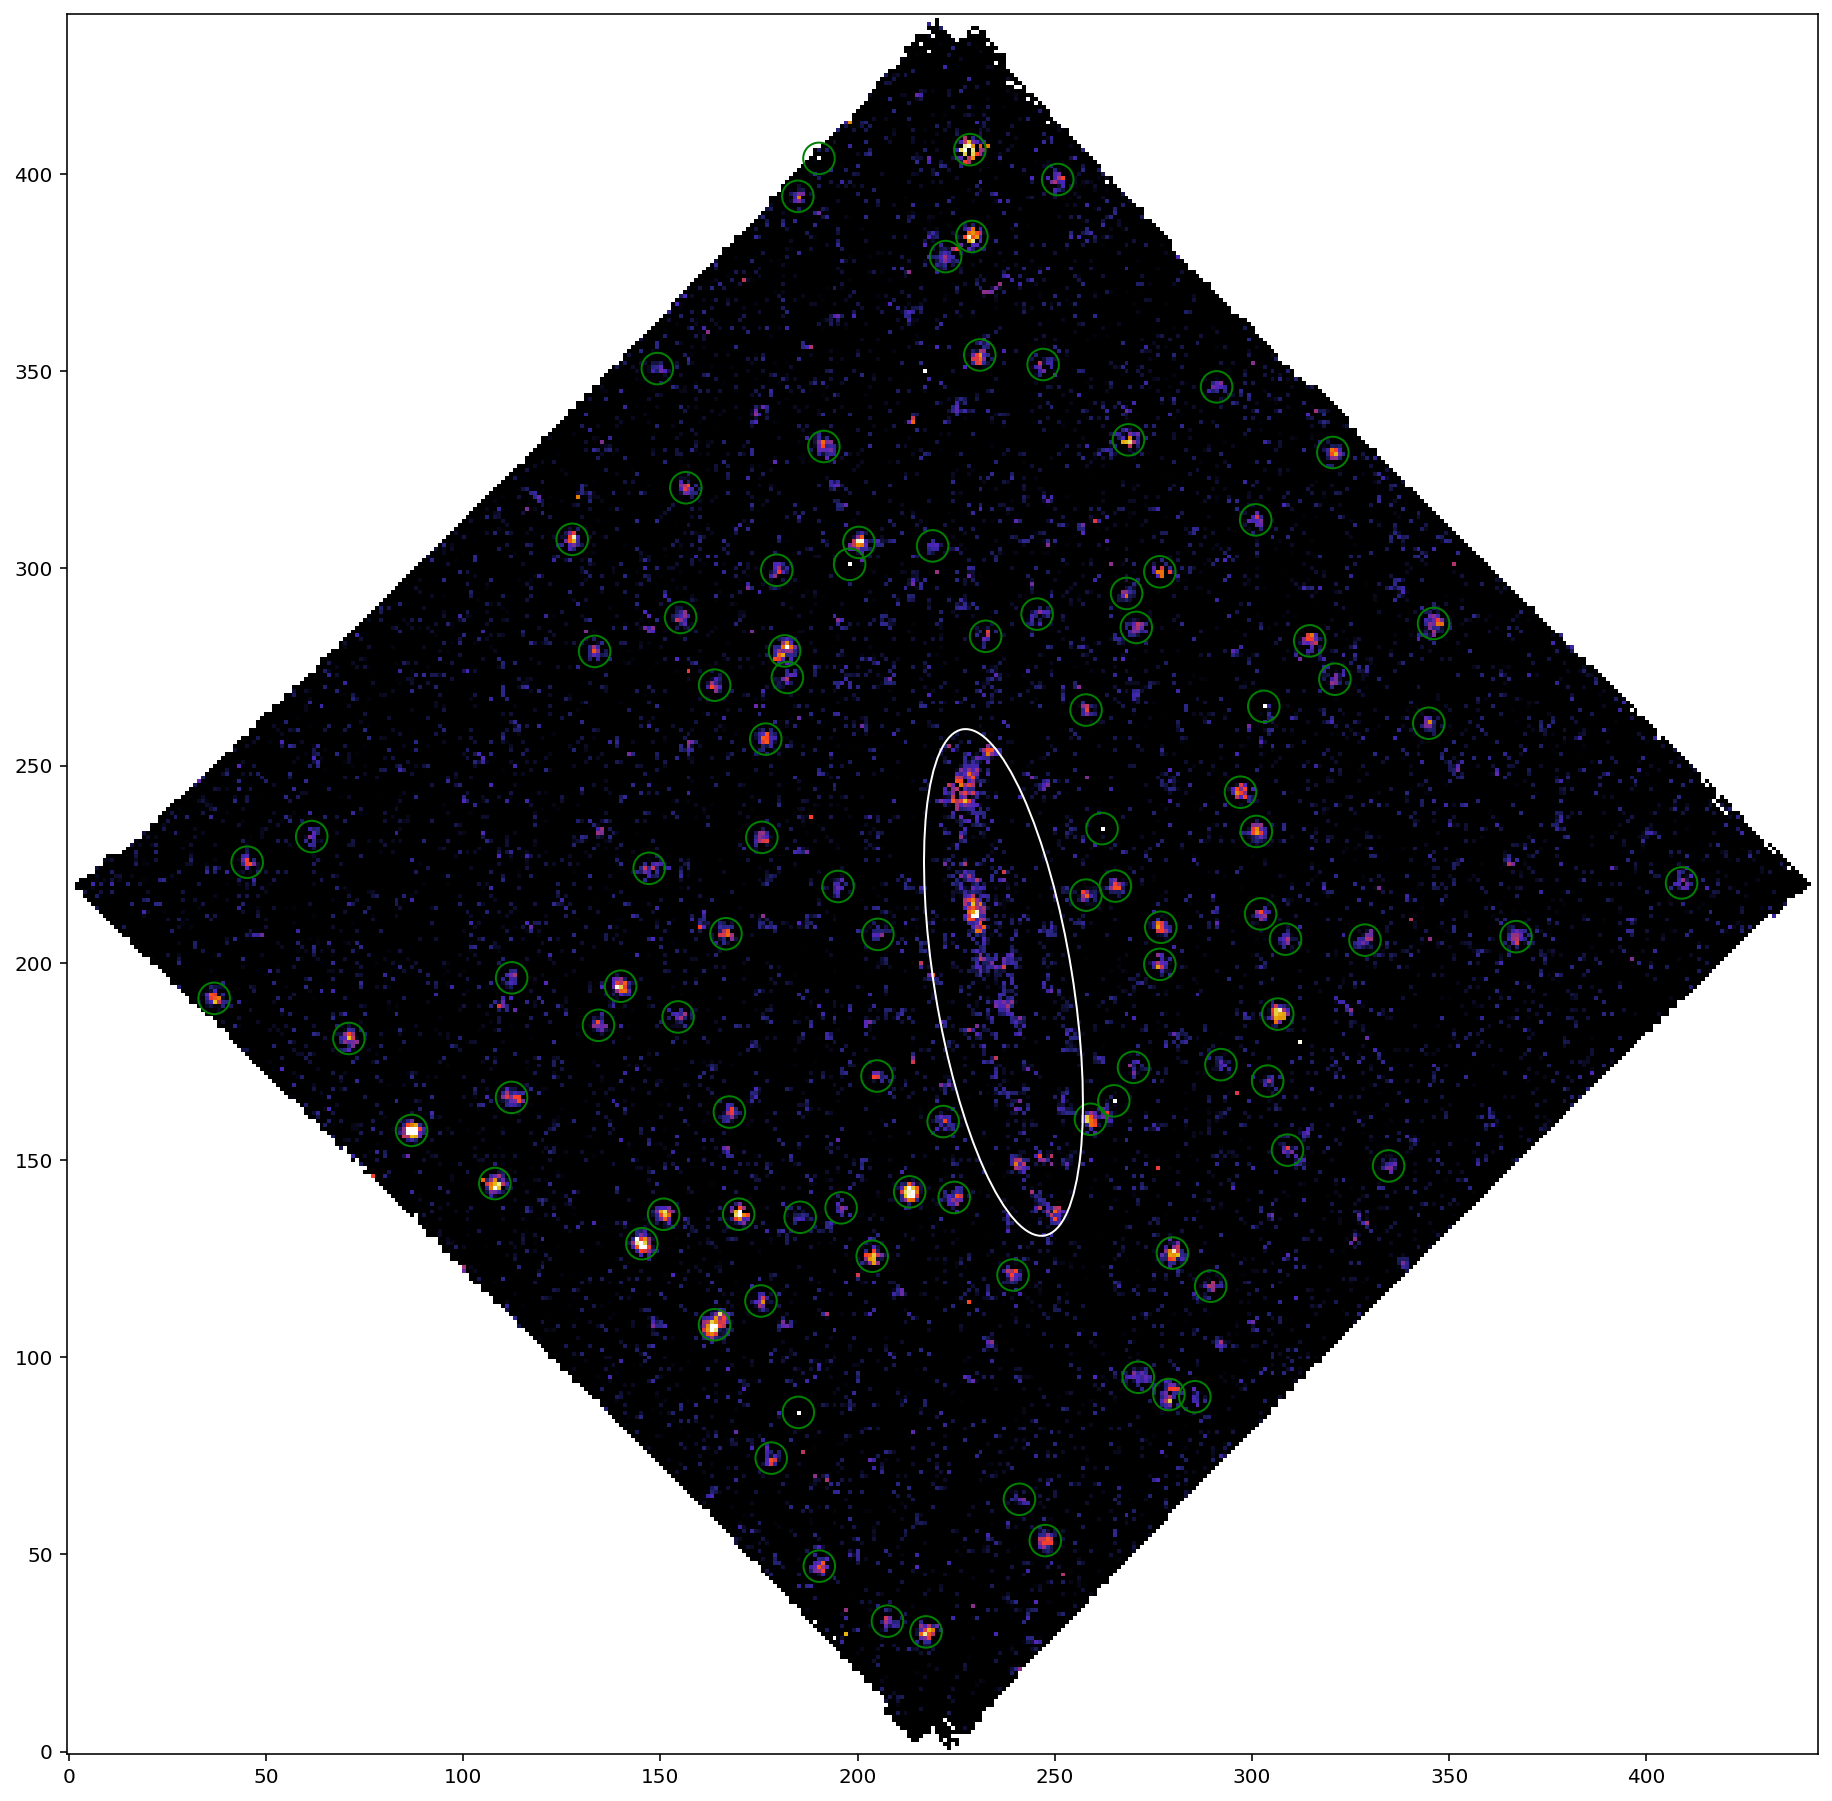

In [8]:
A_rN_plot_shape[A_rN_plot_shape == A_rN_plot_shape[0,0]] = 0.0
plt.figure(figsize=(20,20))

bkg = sep.Background(A_rN_plot_shape, bw=7, bh=7, fw=3, fh=3)

bkg_image = bkg.rms()

# Setup moffat kernel for filter_kernel in SEP
def Moffat_kernel(Moff_A, FWHM, beta, x_0, y_0):
    gamma = FWHM / (2. * umath.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((x_fit - x_0)**2 + (y_fit - y_0)**2) / gamma**2
    F_OIII_xy_dist = Moff_A * (1 + rr_gg)**(-beta)
    
    return F_OIII_xy_dist

M_kernel = Moffat_kernel(1, 2, 2.1, 4, 4)


Y, X = np.mgrid[:y_data, :x_data]
if loc == "middle" or loc == "halo":
    xe, ye, length, width, alpha = [0,0,0,0,0]
else:
    xe, ye, length, width, alpha = gal_mask_params

elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1    

star_mask = np.sum([(Y - yc)**2 + (X - xc)**2 <= rc**2 for xc,yc,rc in star_mask_params],0).astype(bool)


objects = sep.extract(A_rN_plot_shape-bkg, thresh=2.0, clean=True, minarea=6, err=bkg.globalrms, mask=elip_mask_gal+star_mask, deblend_nthresh=4,)# filter_type="conv",filter_kernel=M_kernel.reshape(9,9))#, deblend_nthresh=5)
x_sep = objects["x"]
y_sep = objects["y"]

positions = (x_sep, y_sep)
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_plot_shape-bkg, origin="lower", cmap="CMRmap", vmin=1, vmax=8.)
#plt.imshow(Flux_1D_cube, origin="lower", cmap="CMRmap", vmax=100)
apertures.plot(color="green")

# plt.xlim(0,450)
# plt.xlim(0,350)
# plt.ylim(0,450)
# plt.ylim(250,)

ax = plt.gca()
elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="white")
ax.add_artist(elip_gal)

sep_x_y_list = [[x,y] for x,y in zip(x_sep, y_sep)]
print(len(x_sep))

x_y_list = np.array([[x,y] for x,y in zip(x_sep, y_sep)])
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

# np.save(EXPORT_DIR+galaxy_name+f"{loc}_PNe_x_y_list", sep_x_y_list)

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=8.)


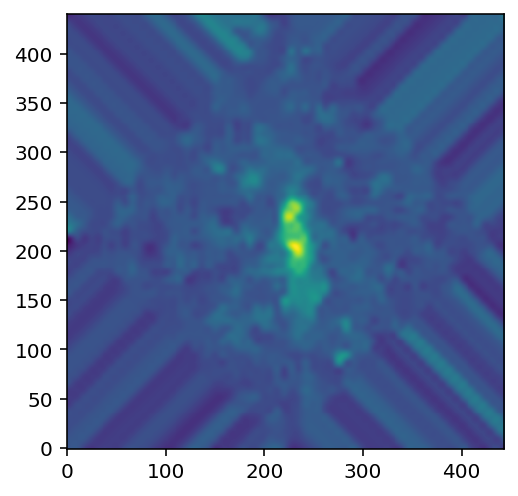

In [9]:
bkg = sep.Background(A_rN_plot_shape, bw=7, bh=7, fw=3, fh=3)

bkg_image = bkg.rms()
plt.imshow(bkg_image, origin="lower")


In [4]:
x_y_list = np.load(EXPORT_DIR+galaxy_name+f"{loc}_PNe_x_y_list.npy")
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

PNe_spectra = np.array([PNe_spectrum_extractor(x, y, n_pixels, hdulist[0].data, x_data, wave=wavelength) for x,y in zip(x_PNe, y_PNe)])

PNe_df = pd.DataFrame(columns=("PNe number", "Ra (J2000)", "Dec (J2000)", "V (km/s)", "m 5007", "M 5007", "[OIII] Flux", "M 5007 error","A/rN", "rad D", "redchi", "Filter"))
PNe_df["PNe number"] = np.arange(0,len(x_PNe)) # PNe numbers
PNe_df["Filter"] = "Y"


def uncertainty_cube_construct(data, x_P, y_P, n_pix):
    data[data == np.inf] = 0.01
    extract_data = np.array([PNe_spectrum_extractor(x, y, n_pix, data, x_data, wave=wavelength) for x,y in zip(x_P, y_P)])
    array_to_fill = np.zeros((len(x_P), n_pix*n_pix, len(wavelength)))
    for p in np.arange(0, len(x_P)):
        list_of_std = np.abs([robust_sigma(dat) for dat in extract_data[p]])
        array_to_fill[p] = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0, len(list_of_std))]
  
    return array_to_fill


with fits.open(EXPORT_DIR+galaxy_name+f"{loc}_resids_obj.fits") as obj_residual_cube:
    obj_error_cube = uncertainty_cube_construct(obj_residual_cube[0].data, x_PNe, y_PNe, n_pixels)

with fits.open(EXPORT_DIR+galaxy_name+f"{loc}_resids_data.fits") as data_residual_cube:
    error_cube = uncertainty_cube_construct(data_residual_cube[0].data, x_PNe, y_PNe, n_pixels)


with fits.open(RAW_DATA) as hdu_wcs:
    hdr_wcs = hdu_wcs[1].header
    wcs_obj = WCS(hdr_wcs, naxis=2)

for i in np.arange(0, len(x_PNe)):
    Ra_Dec = utils.pixel_to_skycoord(x_PNe[i],y_PNe[i], wcs_obj).to_string("hmsdms", precision=2).split()
    PNe_df.loc[i,"Ra (J2000)"] = Ra_Dec[0]
    PNe_df.loc[i,"Dec (J2000)"] = Ra_Dec[1]

/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/MUSE_Models.py:122: RuntimeWarning: invalid value encountered in true_divide
  u2 = (d/(9.0*mad))**2  # c = 9
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/MUSE_Models.py:123: RuntimeWarning: invalid value encountered in less
  good = u2 < 1.0
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/MUSE_Models.py:127: RuntimeWarning: invalid value encountered in double_scalars
  sigma = np.sqrt(num/(den*(den - 1.0)))  # see note in above reference


In [5]:
PNe_multi_params = Parameters()

def gen_params(wave=5007, FWHM=4.0, FWHM_err=0.1, beta=2.5, beta_err=0.3, LSF=2.81, em_dict=None, vary_LSF=False, vary_PSF=False):
    # loop through emission dictionary to add different element parameters 
    for em in em_dict:
        #Amplitude params for each emission
        PNe_multi_params.add('Amp_2D_{}'.format(em), value=emission_dict[em][0], min=0.00001, max=1e5, expr=emission_dict[em][1])
        #Wavelength params for each emission
        if emission_dict[em][2] == None:
            PNe_multi_params.add("wave_{}".format(em), value=wave, min=wave-25., max=wave+25.)
        else:
            PNe_multi_params.add("wave_{}".format(em), expr=emission_dict[em][2].format(z))
    
    PNe_multi_params.add("x_0", value=(n_pixels/2.), min=(n_pixels/2.) -3, max=(n_pixels/2.) +3)
    PNe_multi_params.add("y_0", value=(n_pixels/2.), min=(n_pixels/2.) -3, max=(n_pixels/2.) +3)
    PNe_multi_params.add("LSF", value=LSF, vary=vary_LSF, min=LSF-1, max=LSF+1)
    PNe_multi_params.add("M_FWHM", value=FWHM, min=FWHM - FWHM_err, max=FWHM + FWHM_err, vary=vary_PSF)
    PNe_multi_params.add("beta", value=beta, min=beta - beta_err, max=beta + beta_err, vary=vary_PSF)   
    PNe_multi_params.add("Gauss_bkg",  value=0.001, vary=True)#1, min=-200, max=500)
    PNe_multi_params.add("Gauss_grad", value=0.0001, vary=True)#1, min=-2, max=2)
    
# storage setup
total_Flux = np.zeros((len(x_PNe),len(emission_dict)))
A_2D_list = np.zeros((len(x_PNe),len(emission_dict)))
F_xy_list = np.zeros((len(x_PNe), len(emission_dict), len(PNe_spectra[0])))
moff_A = np.zeros((len(x_PNe),len(emission_dict)))
model_spectra_list = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))
mean_wave_list = np.zeros((len(x_PNe),len(emission_dict)))
residuals_list = np.zeros(len(x_PNe))
list_of_fit_residuals = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))
chi_2_r = np.zeros((len(x_PNe)))
lmfit_chi2 = np.ones(len(x_PNe))
lmfit_redchi = np.ones(len(x_PNe))

# error lists
moff_A_err = np.zeros((len(x_PNe), len(emission_dict)))
x_0_err = np.zeros((len(x_PNe), len(emission_dict)))
y_0_err = np.zeros((len(x_PNe), len(emission_dict)))
mean_wave_err = np.zeros((len(x_PNe), len(emission_dict)))
Gauss_bkg_err = np.zeros((len(x_PNe), len(emission_dict)))
Gauss_grad_err = np.zeros((len(x_PNe), len(emission_dict)))

list_of_x = np.zeros(len(x_PNe))
list_of_y = np.zeros(len(x_PNe))
Gauss_bkg = np.zeros(len(x_PNe))
Gauss_grad = np.zeros(len(x_PNe))

def run_minimiser(parameters):
    for PNe_num in tqdm(np.arange(0, len(x_PNe))):
        useful_stuff = []        
        PNe_minimizer     = lmfit.Minimizer(PNe_residuals_3D, PNe_multi_params, fcn_args=(wavelength, x_fit, y_fit, PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num, emission_dict, useful_stuff), nan_policy="propagate")
        multi_fit_results = PNe_minimizer.minimize(method="least_squares")
        total_Flux[PNe_num] = np.sum(useful_stuff[1][1],1) * 1e-20
        list_of_fit_residuals[PNe_num] = useful_stuff[0]
        A_2D_list[PNe_num]  = useful_stuff[1][0]
        F_xy_list[PNe_num]  = useful_stuff[1][1]
        model_spectra_list[PNe_num] = useful_stuff[1][3]
        moff_A[PNe_num]         = [multi_fit_results.params["Amp_2D_{}".format(em)] for em in emission_dict]
        mean_wave_list[PNe_num] = [multi_fit_results.params["wave_{}".format(em)] for em in emission_dict]   
        chi_2_r[PNe_num]    = multi_fit_results.redchi
        list_of_x[PNe_num]  = multi_fit_results.params["x_0"]
        list_of_y[PNe_num]  = multi_fit_results.params["y_0"]
        Gauss_bkg[PNe_num]  = multi_fit_results.params["Gauss_bkg"]
        Gauss_grad[PNe_num] = multi_fit_results.params["Gauss_grad"]
        #save errors
        moff_A_err[PNe_num]     = [multi_fit_results.params["Amp_2D_{}".format(em)].stderr for em in emission_dict]
        mean_wave_err[PNe_num]  = [multi_fit_results.params["wave_{}".format(em)].stderr for em in emission_dict]
        x_0_err[PNe_num]        = multi_fit_results.params["x_0"].stderr
        y_0_err[PNe_num]        = multi_fit_results.params["y_0"].stderr
        Gauss_bkg_err[PNe_num]  = multi_fit_results.params["Gauss_bkg"].stderr
        Gauss_grad_err[PNe_num] = multi_fit_results.params["Gauss_grad"].stderr
        
        lmfit_chi2[PNe_num] = multi_fit_results.chisqr
        lmfit_redchi[PNe_num] = multi_fit_results.redchi
        
        
    # Signal to noise and Magnitude calculations
    list_of_rN = np.array([robust_sigma(PNe_res) for PNe_res in list_of_fit_residuals])
    PNe_df["A/rN"] = A_2D_list[:,0] / list_of_rN # Using OIII amplitude   
    
    # chi square analysis
    gauss_list, redchi, Chi_sqr = [], [], []
    for p in range(len(x_PNe)):
        PNe_n = np.copy(PNe_spectra[p])
        flux_1D = np.copy(F_xy_list[p][0])
        A_n = ((flux_1D) / (np.sqrt(2*np.pi) * (galaxy_data["LSF"]/ 2.35482)))
    
        def gaussian(x, amplitude, mean, FWHM, bkg, grad, z):
            stddev = FWHM / 2.35482
            return ((bkg + grad*x) + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
                    (np.abs(amplitude)/2.85) * np.exp(- 0.5 * (x - (mean - 47.9399*(1+z)))** 2 / (stddev**2.)))
    
        list_of_gauss = [gaussian(wavelength, A, mean_wave_list[p][0], galaxy_data["LSF"], Gauss_bkg[p], Gauss_grad[p], z) for A in A_n]
    
        for kk in range(len(PNe_n)):
            temp = np.copy(list_of_gauss[kk])
            idx  = np.where(PNe_n[kk] == 0.0)[0]
            temp[idx] = 0.0
            PNe_n[kk,idx] = 1.0
            list_of_gauss[kk] = np.copy(temp)
        rN   = robust_sigma(PNe_n - list_of_gauss)
        res  = PNe_n - list_of_gauss
        Chi2 = np.sum((res**2)/(rN**2))
        s    = np.shape(PNe_n)
        redchi.append(Chi2/ ((len(wavelength) * n_pixels**2) - multi_fit_results.nvarys))
        gauss_list.append(list_of_gauss)
        Chi_sqr.append(Chi2)
        
    PNe_df['Chi2']   = Chi_sqr
    PNe_df["redchi"] = redchi
    
    # velocity
    de_z_means = np.array(mean_wave_list[:,0] / (1 + z)) # de redshift OIII wavelength position
    
    PNe_df["V (km/s)"] = (c * (de_z_means - 5006.77) / 5006.77) / 1000.    
        
    PNe_df["[OIII] Flux"] = total_Flux[:,0] #store total OIII 5007 line flux
        
    if "hb" in emission_dict:
        PNe_df["[OIII]/Hb"] = PNe_df["[OIII] Flux"] / total_Flux[:,2] # store [OIII]/Hb ratio

    if "ha" in emission_dict:
        PNe_df["Ha Flux"] = total_Flux[:, 1]
    
    PNe_df["m 5007"] = -2.5 * np.log10(PNe_df["[OIII] Flux"].values) - 13.74


In [6]:
gen_params(wave=5006.77*(1+z), FWHM=galaxy_data["FWHM"], beta=galaxy_data["beta"], LSF=galaxy_data["LSF"], vary_PSF=False, em_dict=emission_dict)

run_minimiser(PNe_multi_params)

100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


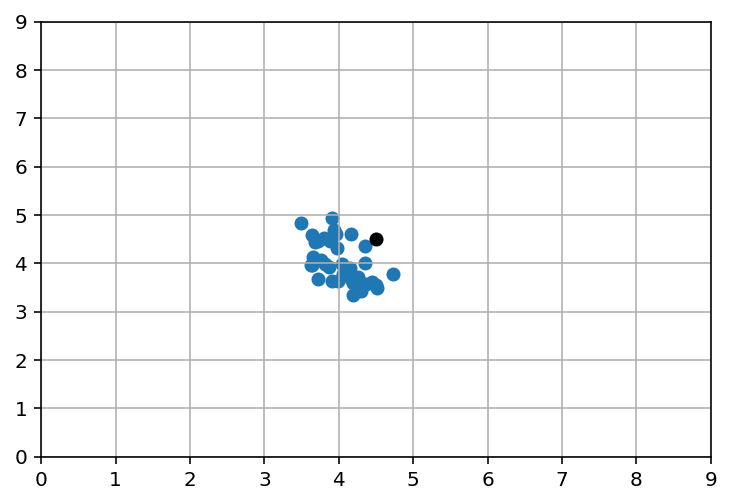

In [9]:
plt.scatter(list_of_x, list_of_y)
plt.ylim(0,9)
plt.xlim(0,9)
plt.scatter((n_pixels/2.) ,(n_pixels/2.) , c="k")
plt.grid(True)

## The Great Filter

68
Number of objects after filtering: 65


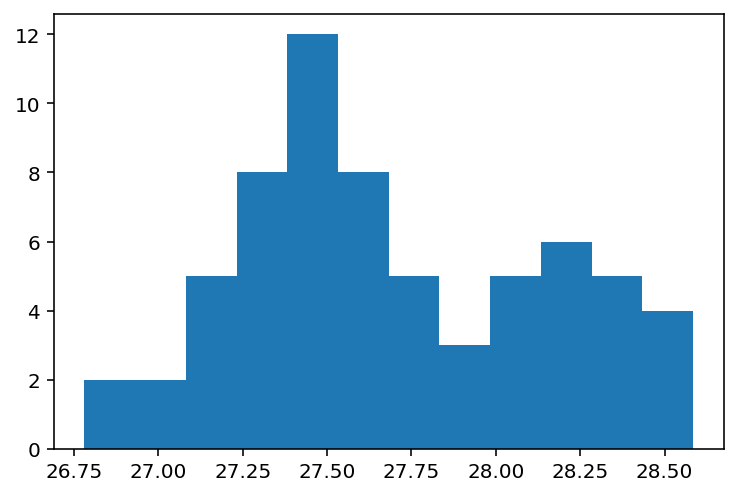

In [7]:
PNe_df["Filter"] = "Y"
PNe_df.loc[PNe_df["A/rN"]<3.0, "Filter"] = "N"
print(len(PNe_df["Filter"].loc[PNe_df["Filter"]=="Y"]))

upper_chi = stats.chi2.ppf(0.9973, ((n_pixels**2)*len(wavelength))-6) # 3 sigma = 0.9973
PNe_df.loc[PNe_df["Chi2"]>=upper_chi, "Filter"] = "N" 

## FCC167
if (galaxy_name == "FCC167") & (loc=="center"):
#     PNe_df.loc[PNe_df["PNe number"]==32, "Filter"] = "N" # Over luminous PNe - 29
#     PNe_df.loc[PNe_df["PNe number"]==10, "Filter"] = "N"  # Double reading from source
    PNe_df.loc[PNe_df["PNe number"]==22, "Filter"] = "N"  # Double reading from source
## FCC219
elif (galaxy_name == "FCC219") & (loc=="center"):
     PNe_df.loc[PNe_df["PNe number"]==0, "Filter"] = "N"
# elif galaxy_name == "FCC193":
#     PNe_df.loc[PNe_df["PNe number"]==143, "Filter"] = "N" 
#     PNe_df.loc[PNe_df["PNe number"]==141, "Filter"] = "N" 
#     PNe_df.loc[PNe_df["PNe number"]==84, "Filter"] = "N"
#     PNe_df.loc[PNe_df["PNe number"]==77, "Filter"] = "Y" 
#     PNe_df.loc[PNe_df["PNe number"]==94, "Filter"] = "Y" 
#elif galaxy_name == "FCC147":
    #PNe_df.loc[PNe_df["PNe number"]==41, "Filter"] = "N"
# elif galaxy_name == "FCC249":
#     PNe_df.loc[PNe_df["PNe number"]==2, "Filter"] = "N"
# elif galaxy_name == "FCC276":
#     PNe_df.loc[PNe_df["PNe number"]==20, "Filter"] = "N" # Overly bright object, sets D=15Mpc, could be overlap/super-position of two.
#     PNe_df.loc[PNe_df["PNe number"]==40, "Filter"] = "Y"
#     PNe_df.loc[PNe_df["PNe number"]==79, "Filter"] = "Y"
#     PNe_df.loc[PNe_df["PNe number"]==85, "Filter"] = "Y"
# elif galaxy_name == "FCC184":
#     PNe_df.loc[PNe_df["PNe number"]==15, "Filter"] = "N"
#     PNe_df.loc[PNe_df["PNe number"]==35, "Filter"] = "N"
# elif galaxy_name == "FCC301":
#     PNe_df.loc[PNe_df["PNe number"]==14, "Filter"] = "N"
#     PNe_df.loc[PNe_df["PNe number"]==16, "Filter"] = "N"
# elif galaxy_name == "FCC255":
#     PNe_df.loc[PNe_df["PNe number"]==32, "Filter"] = "N"
elif galaxy_name == "FCC310":
    PNe_df.loc[PNe_df["PNe number"]==54, "Filter"] = "Y"


    

print("Number of objects after filtering: "+str(len(PNe_df["Filter"].loc[PNe_df["Filter"]=="Y"])))
plt.hist(PNe_df["m 5007"].loc[PNe_df["Filter"]=="Y"], bins=12);
plt.show()

# Error analysis

In [8]:
def Moffat_err(Moff_A, FWHM, beta, x_0, y_0):
    alpha = FWHM / (2. * umath.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((x_fit - x_0)**2 + (y_fit - y_0)**2) / alpha**2
    F_OIII_xy_dist = Moff_A * (2 * ((beta -1)/(alpha**2)))*(1 + rr_gg)**(-beta)
    
    return np.sum(F_OIII_xy_dist*1e-20)

flux_plus_minus = np.ones((len(x_PNe),2))
mag_plus_minus  = np.ones((len(x_PNe),2))
                         
for i,p in enumerate(tqdm(range(len(x_PNe)))):
    Moff_A_dist = N(moff_A[p][0], moff_A_err[p][0])
    FWHM_dist   = N(galaxy_data["FWHM"], galaxy_data["FWHM_err"])
    beta_dist   = N(galaxy_data["beta"], galaxy_data["beta_err"])
    x_0_dist    = N(list_of_x[p], x_0_err[p][0])
    y_0_dist    = N(list_of_y[p], y_0_err[p][0])
    
    flux_array = [Moffat_err(Moff_A_dist._mcpts[i], FWHM_dist._mcpts[i], beta_dist._mcpts[i], x_0_dist._mcpts[i], y_0_dist._mcpts[i]) for i in range(len(FWHM_dist._mcpts))]

    flux_plus_minus[i, 0] = np.nanpercentile(flux_array, 84) - np.nanpercentile(flux_array, 50)
    flux_plus_minus[i, 1] = np.nanpercentile(flux_array, 50) - np.nanpercentile(flux_array, 16)

    # Convert fluxes to magnitudes, then find 1 sigma values from median (84th - 50th) & (50th - 16th)
    mag_array = -2.5*np.log10(flux_array)-13.74
    mag_plus_minus[i, 0] = np.nanpercentile(mag_array, 84) - np.nanpercentile(mag_array, 50)
    mag_plus_minus[i, 1] = np.nanpercentile(mag_array, 50) - np.nanpercentile(mag_array, 16)



PNe_df["Flux error up"] = flux_plus_minus[:,0]
PNe_df["Flux error lo"] = flux_plus_minus[:,1]
# 
PNe_df["mag error up"] = mag_plus_minus[:,0]
PNe_df["mag error lo"] = mag_plus_minus[:,1]

100%|██████████| 74/74 [00:28<00:00,  2.59it/s]


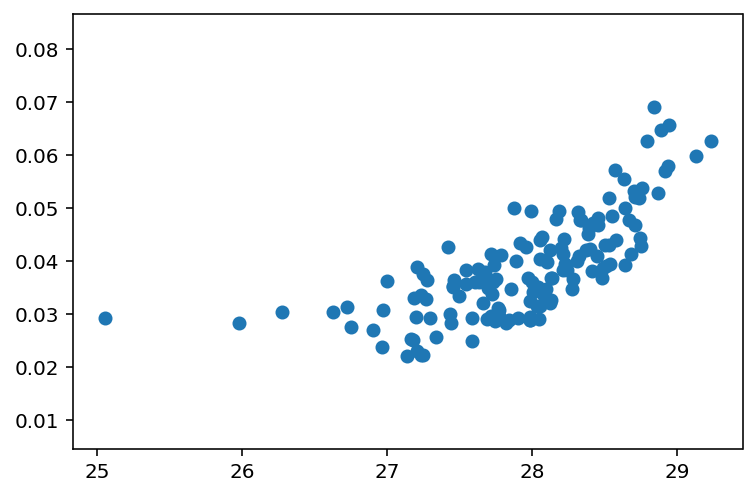

In [34]:
#._mcpts
# plt.scatter(PNe_df["[OIII] Flux"], np.abs(flux_plus_minus[:,0]))
plt.scatter(PNe_df["m 5007"], mag_plus_minus[:,1])
# plt.scatter(PNe_df["[OIII] Flux"], np.abs(PNe_df["Flux error"]))
# plt.ylim(0.5e-18, 5e-18)
# plt.xlim(-1e-19, 1e-16)

## Distance estimate with error

In [13]:
p_n = int(PNe_df.loc[PNe_df["Filter"]=="Y"].nsmallest(3, "m 5007").index.values[0])

m = PNe_df["m 5007"].iloc[p_n]
m_err_up = PNe_df["mag error up"].iloc[p_n]
m_err_lo = PNe_df["mag error lo"].iloc[p_n]
print("PNe: ", p_n)

M_star = -4.53
M_star_err = 0.08
D_diff_eq = 0.2 * np.log(10) * (10**(0.2*(m + abs(M_star) - 25)))

Dist_est = 10.**(((m + abs(M_star)) -25.) / 5.)
Dist_err_up = np.sqrt((D_diff_eq**2 * m_err_up**2) + ((-D_diff_eq)**2 * M_star_err**2))
Dist_err_lo = np.sqrt((D_diff_eq**2 * m_err_lo**2) + ((-D_diff_eq)**2 * M_star_err**2))

print("Distance Estimate from PNLF: ", f"{np.round(Dist_est,3)} (+ {np.round(Dist_err_up,3)}) (- {np.round(Dist_err_lo,3)}) Mpc")

dM =  5. * np.log10(Dist_est) + 25.
dM_diff_eq = 5/(np.log(10) * Dist_est)
dM_err_up = np.abs(dM_diff_eq)*Dist_err_up
dM_err_lo = np.abs(dM_diff_eq)*Dist_err_lo

print(f"dM = {np.round(dM, 3)} (+ {np.round(dM_err_up,3)}) (- {np.round(dM_err_lo, 3)})")

PNe_df["M 5007"] = PNe_df["m 5007"] - dM

PNe:  22
Distance Estimate from PNLF:  19.202 (+ 0.869) (- 0.831) Mpc
dM = 31.417 (+ 0.098) (- 0.094)


# LOSV work - Interloper check

In [14]:
## Velocity from files
hdulist_ppxf = fits.open(RAW_DIR+f"/{galaxy_name}center_ppxf_SPAXELS.fits")
v_star, s_star = hdulist_ppxf[1].data.V, hdulist_ppxf[1].data.SIGMA


hdulist_table = fits.open(RAW_DIR+f"/{galaxy_name}center_table.fits")
X_star, Y_star = hdulist_table[1].data.XBIN, hdulist_table[1].data.YBIN
flux_star = hdulist_table[1].data.FLUX

idx = flux_star.argmax()
X_star, Y_star = X_star-X_star[idx], Y_star-Y_star[idx]

cond = np.sqrt( (X_star)**2 + (Y_star)**2 ) <= 5.0
vsys = np.median(v_star[cond])
v_star = v_star-vsys

LOS_z = (vsys * 1e3) / c

LOS_de_z = np.array(mean_wave_list[:,0] / (1 + LOS_z))
    
PNe_df["PNe_LOS_V"] = (c * (LOS_de_z - 5006.77) / 5006.77) / 1000. 

f_ind = PNe_df.loc[PNe_df["Filter"]=="Y"].index
# f_ind = PNe_df.index

gal_centre_pix = Table.read("exported_data/galaxy_centre_pix.dat", format="ascii")

gal_ind = np.where(gal_centre_pix["Galaxy"]==galaxy_name)
gal_x_c = gal_centre_pix["x_pix"][gal_ind]
gal_y_c = gal_centre_pix["y_pix"][gal_ind]

xpne, ypne = (x_PNe[f_ind]-gal_x_c)*0.2, (y_PNe[f_ind]-gal_y_c)*0.2

# Estimating the velocity dispersion of the PNe along the LoS
def sig_PNe(X_star,Y_star,v_stars,sigma,x_PNe,y_PNe,vel_PNe):

    d_PNe_to_skin = np.zeros(len(x_PNe))
    Vs_PNe = np.ones(len(x_PNe)) # Velocity of the closest star
    Ss_PNe = np.ones(len(x_PNe)) # Sigma for each PNe
    i_skin_PNe = []

    """ To estimate the velocity dispersion for PNe we need to
    extract the sigma of the closest stars for each PNe """

    for i in range(len(x_PNe)):
        r_tmp = np.sqrt((X_star-x_PNe[i])**2+(Y_star-y_PNe[i])**2)
        d_PNe_to_skin[i] = min(r_tmp)
        i_skin_PNe.append(r_tmp.argmin())

    Vs_PNe  = v_stars[i_skin_PNe]
    Ss_PNe  = sigma[i_skin_PNe]
    rad_PNe = np.sqrt(x_PNe**2+y_PNe**2)
    k = np.where(d_PNe_to_skin > 1.0)

    return rad_PNe, (vel_PNe-Vs_PNe)/Ss_PNe, k, Vs_PNe, Ss_PNe

rad_PNe, vel_ratio, k, Vs_PNe, Ss_PNe  = sig_PNe(X_star, Y_star, v_star, s_star, xpne, ypne, PNe_df["PNe_LOS_V"].loc[PNe_df["Filter"]=="Y"])
# rad_PNe, vel_ratio, k  = sig_PNe(X_star, Y_star, v_star, s_star, xpne, ypne, PNe_df["V (km/s)"].loc[PNe_df["Filter"]=="Y"])
# rad_PNe, vel_ratio, k  = sig_PNe(X_star, Y_star, v_star, s_star, xpne, ypne, PNe_df["PNe_LOS_V"])


interlopers = vel_ratio[(vel_ratio<-3) | (vel_ratio>3)].index
print(interlopers)
for inter in interlopers:
    PNe_df.loc[PNe_df["PNe number"]==inter, "Filter"] = "N"
    
print(stats.norm.fit(PNe_df["V (km/s)"].loc[PNe_df["Filter"]=="Y"].values))
# print(stats.norm.fit(PNe_df["PNe_LOS_V"].loc[PNe_df["Filter"]=="Y"].values))

Int64Index([], dtype='int64')
(-81.24674711048448, 146.31666929590506)


In [19]:
len(Ss_PNe)

119

## Save the PNe_df dataframe

In [27]:
PNe_df.to_csv(f"exported_data/{galaxy_name}/{galaxy_name}_PNe_df.csv")

# Run PNe diagnostics for SNR or HII regions

## Then filter off those that pass criteria

First imposter check, PNe:  [16 40 41 42]
SNR imposters [40]
HII imposters [16, 41, 42]


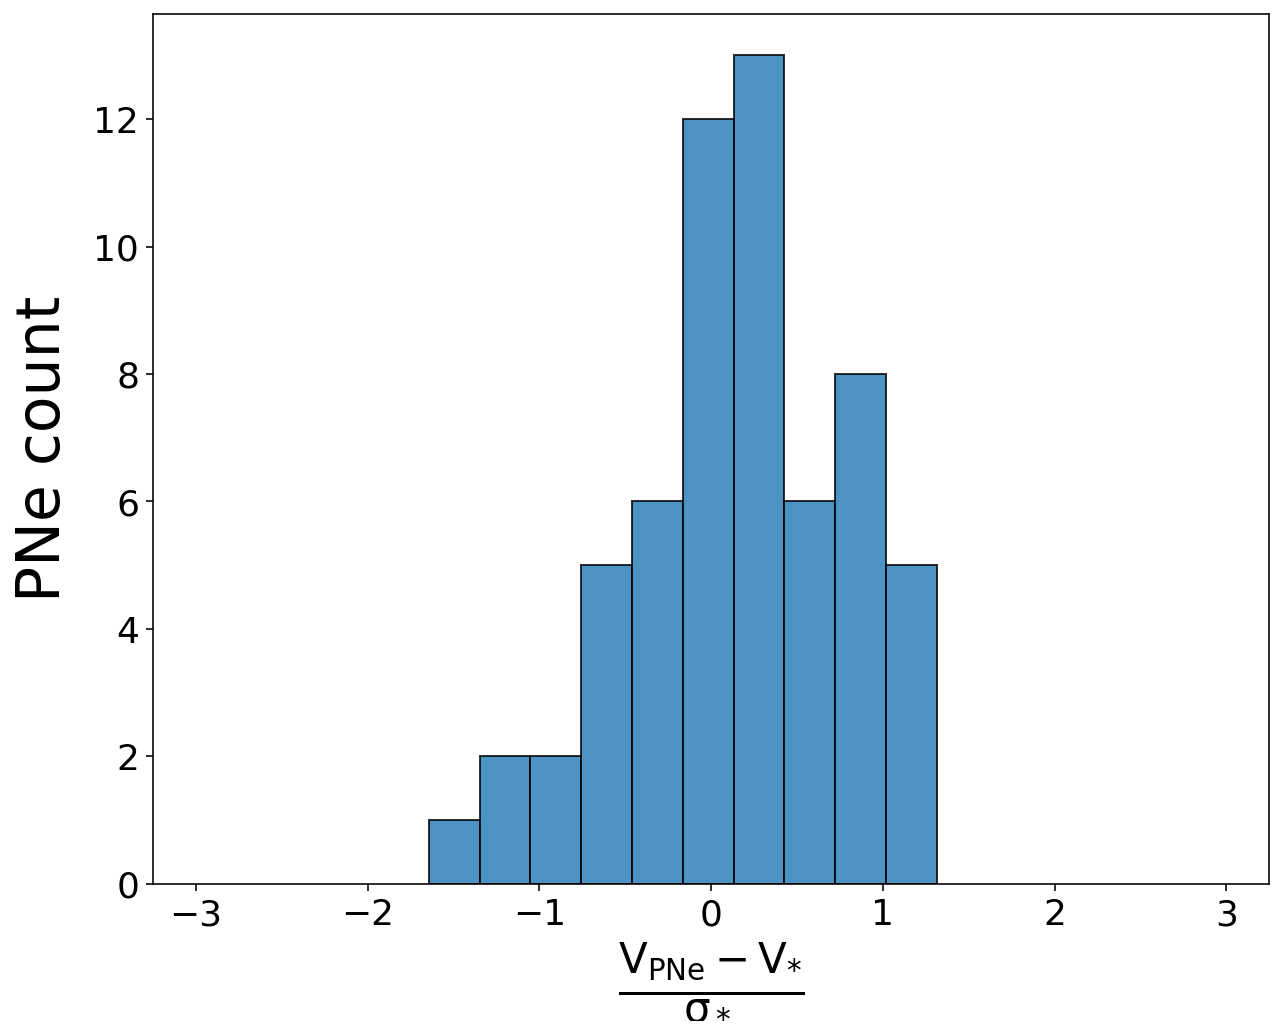

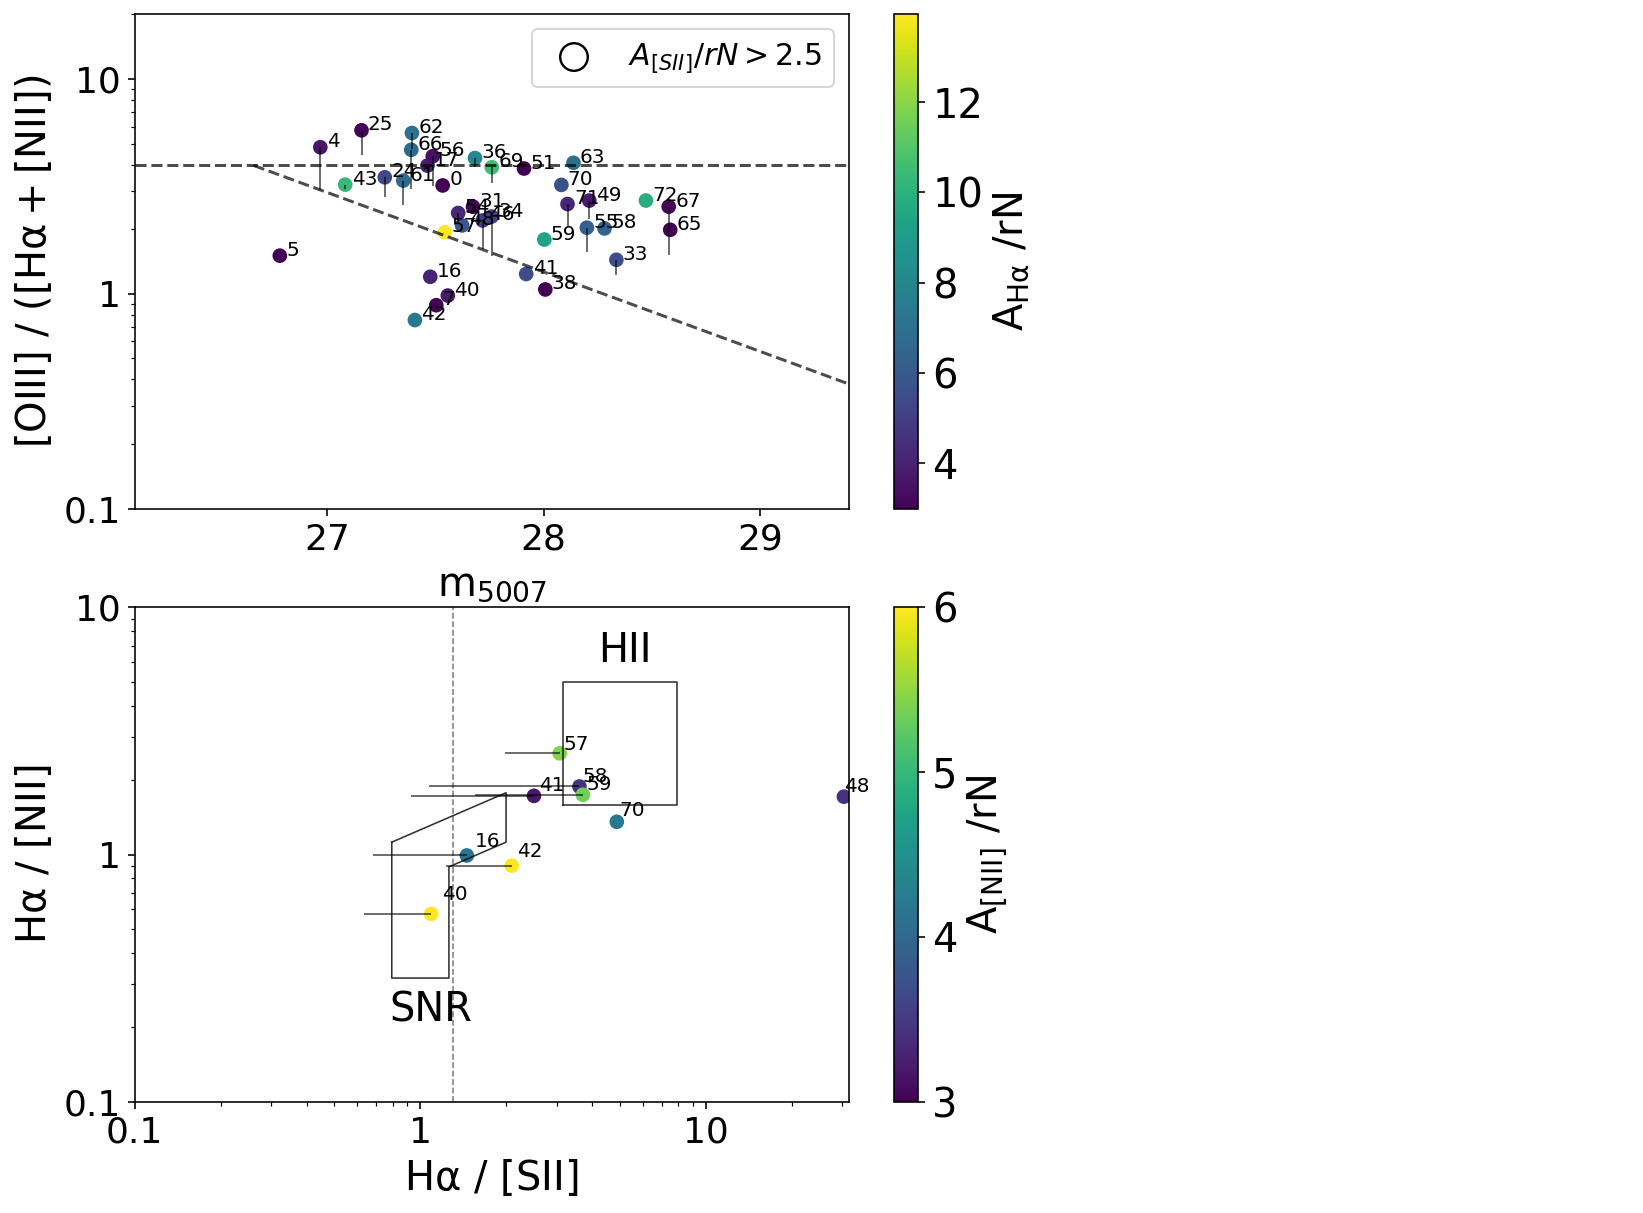

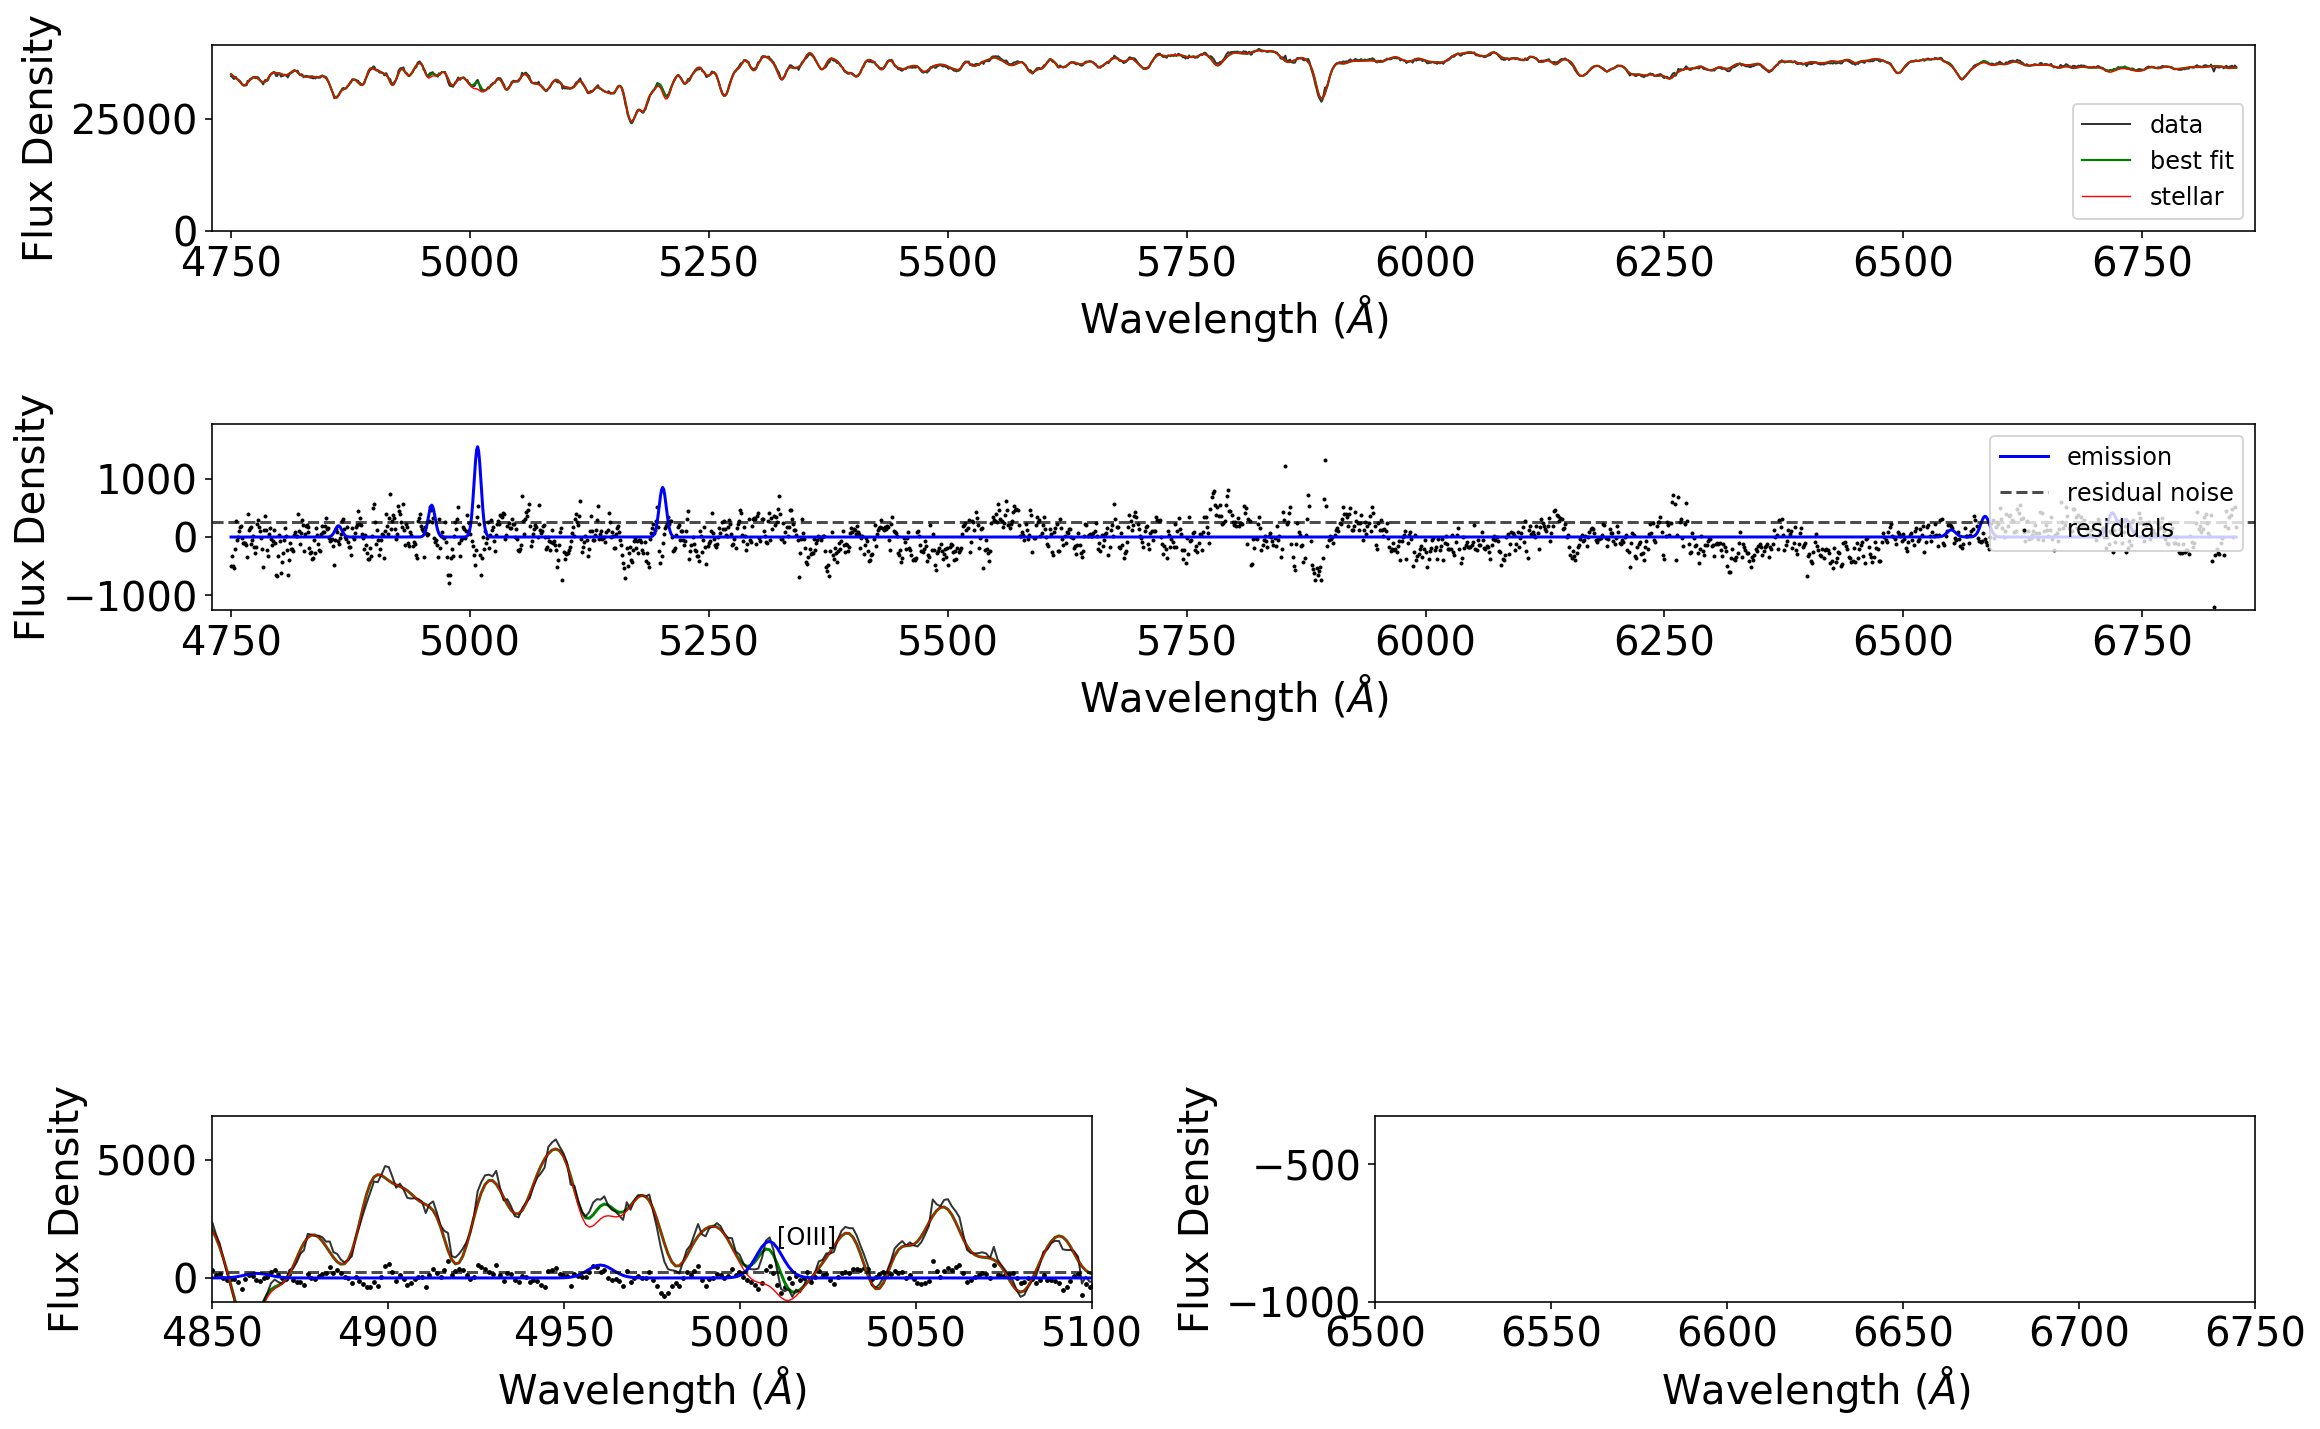

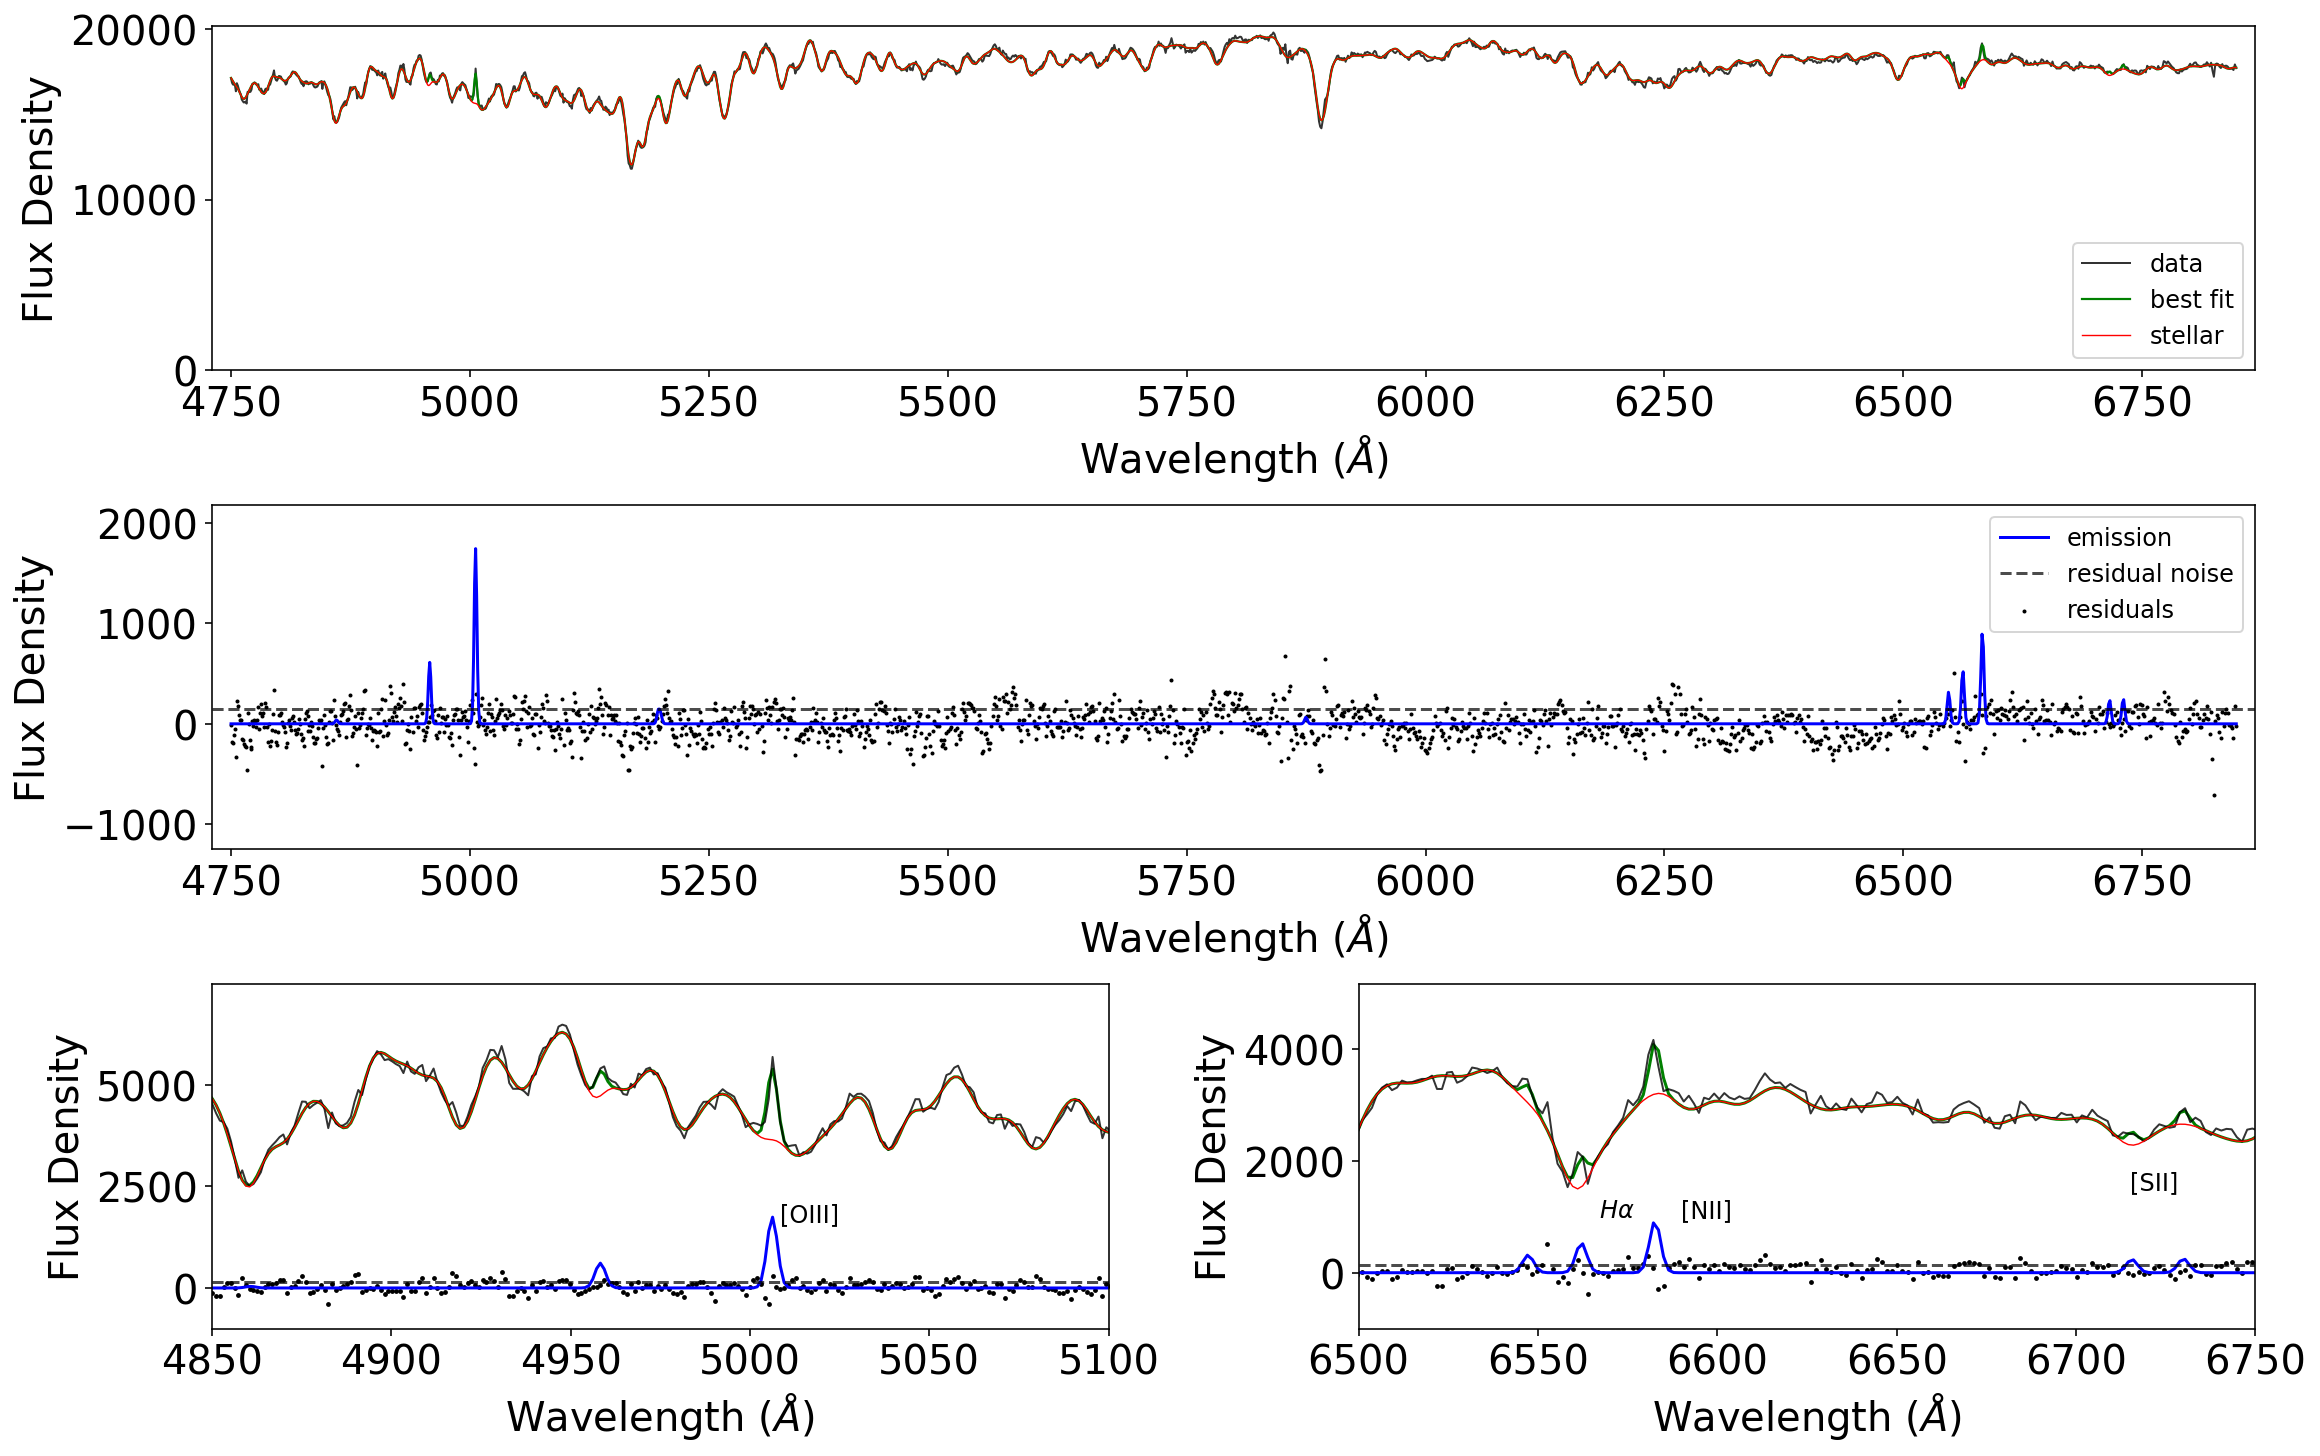

In [20]:
%run read_GIST_PNe.py --galaxy FCC219 --w --p --n

In [12]:
## FCC167
# SNR - 46, 89 , 102, 20
# HII - 38

## FCC219
# SNR - 60, 86
# HII - none

## FCC
# SNR
# HII

if galaxy_name == "FCC167":
    PNe_df.loc[PNe_df["PNe number"]==13 , "Filter"] = "N"  # SNR
    PNe_df.loc[PNe_df["PNe number"]==21 , "Filter"] = "N"  # SNR
    PNe_df.loc[PNe_df["PNe number"]==27 , "Filter"] = "N"  # SNR
    PNe_df.loc[PNe_df["PNe number"]==68 , "Filter"] = "N"  # HII
    
#     PNe_df.loc[PNe_df["PNe number"]==12 , "Filter"] = "N"  # SNR
#     PNe_df.loc[PNe_df["PNe number"]==21 , "Filter"] = "N"  # SNR
#     PNe_df.loc[PNe_df["PNe number"]==31 , "Filter"] = "N"  # SNR
#     PNe_df.loc[PNe_df["PNe number"]==39 , "Filter"] = "N"  # SNR
#     PNe_df.loc[PNe_df["PNe number"]==45 , "Filter"] = "N"  # SNR
#     PNe_df.loc[PNe_df["PNe number"]==96 , "Filter"] = "N"  # SNR
#     PNe_df.loc[PNe_df["PNe number"]==108 , "Filter"] = "N" # SNR
#     PNe_df.loc[PNe_df["PNe number"]==98 , "Filter"] = "N"  # HII
    

elif galaxy_name == "FCC219":
    PNe_df.loc[PNe_df["PNe number"]==40 , "Filter"] = "N"  # SNR
    PNe_df.loc[PNe_df["PNe number"]==16 , "Filter"] = "N"  # HII
    PNe_df.loc[PNe_df["PNe number"]==41 , "Filter"] = "N"  # HII
    PNe_df.loc[PNe_df["PNe number"]==42 , "Filter"] = "N"  # HII
    PNe_df.loc[PNe_df["PNe number"]==5 , "Filter"] = "N"   # imposter
    PNe_df.loc[PNe_df["PNe number"]==7 , "Filter"] = "N"   # imposter
    
    
elif galaxy_name == "FCC161":
    PNe_df.loc[PNe_df["PNe number"]==31 , "Filter"] = "N"  # HII

elif galaxy_name == "FCC083":
    PNe_df.loc[PNe_df["PNe number"]==35 , "Filter"] = "N"  # HII
    PNe_df.loc[PNe_df["PNe number"]==32 , "Filter"] = "N"  # HII
    
elif galaxy_name == "FCC276":
    PNe_df.loc[PNe_df["PNe number"]==12 , "Filter"] = "N"  # HII
    PNe_df.loc[PNe_df["PNe number"]==28 , "Filter"] = "N"  # HII
    PNe_df.loc[PNe_df["PNe number"]==38 , "Filter"] = "N"  # HII

elif galaxy_name == "FCC277":
    PNe_df.loc[PNe_df["PNe number"]==15 , "Filter"] = "N"  # HII
    PNe_df.loc[PNe_df["PNe number"]==19 , "Filter"] = "N"  # HII
    
elif galaxy_name == "FCC153":
    PNe_df.loc[PNe_df["PNe number"]==16 , "Filter"] = "N"  # SNR
    PNe_df.loc[PNe_df["PNe number"]==18 , "Filter"] = "N"  # HII
    PNe_df.loc[PNe_df["PNe number"]==20 , "Filter"] = "N"  # HII
    
elif galaxy_name == "FCC177":
    PNe_df.loc[PNe_df["PNe number"]==8 , "Filter"] = "N"   # HII
    PNe_df.loc[PNe_df["PNe number"]==30 , "Filter"] = "N"  # HII
    PNe_df.loc[PNe_df["PNe number"]==31 , "Filter"] = "N"  # HII
    
elif galaxy_name == "FCC182":
    PNe_df.loc[PNe_df["PNe number"]==4 , "Filter"] = "N"   # HII

elif galaxy_name == "FCC190":
    PNe_df.loc[PNe_df["PNe number"]==24 , "Filter"] = "N"  # SNR
    PNe_df.loc[PNe_df["PNe number"]==20 , "Filter"] = "N"  # HII    

#elif galaxy_name == "FCC193":
#    PNe_df.loc[PNe_df["PNe number"]==, "Filter"] = "N" 

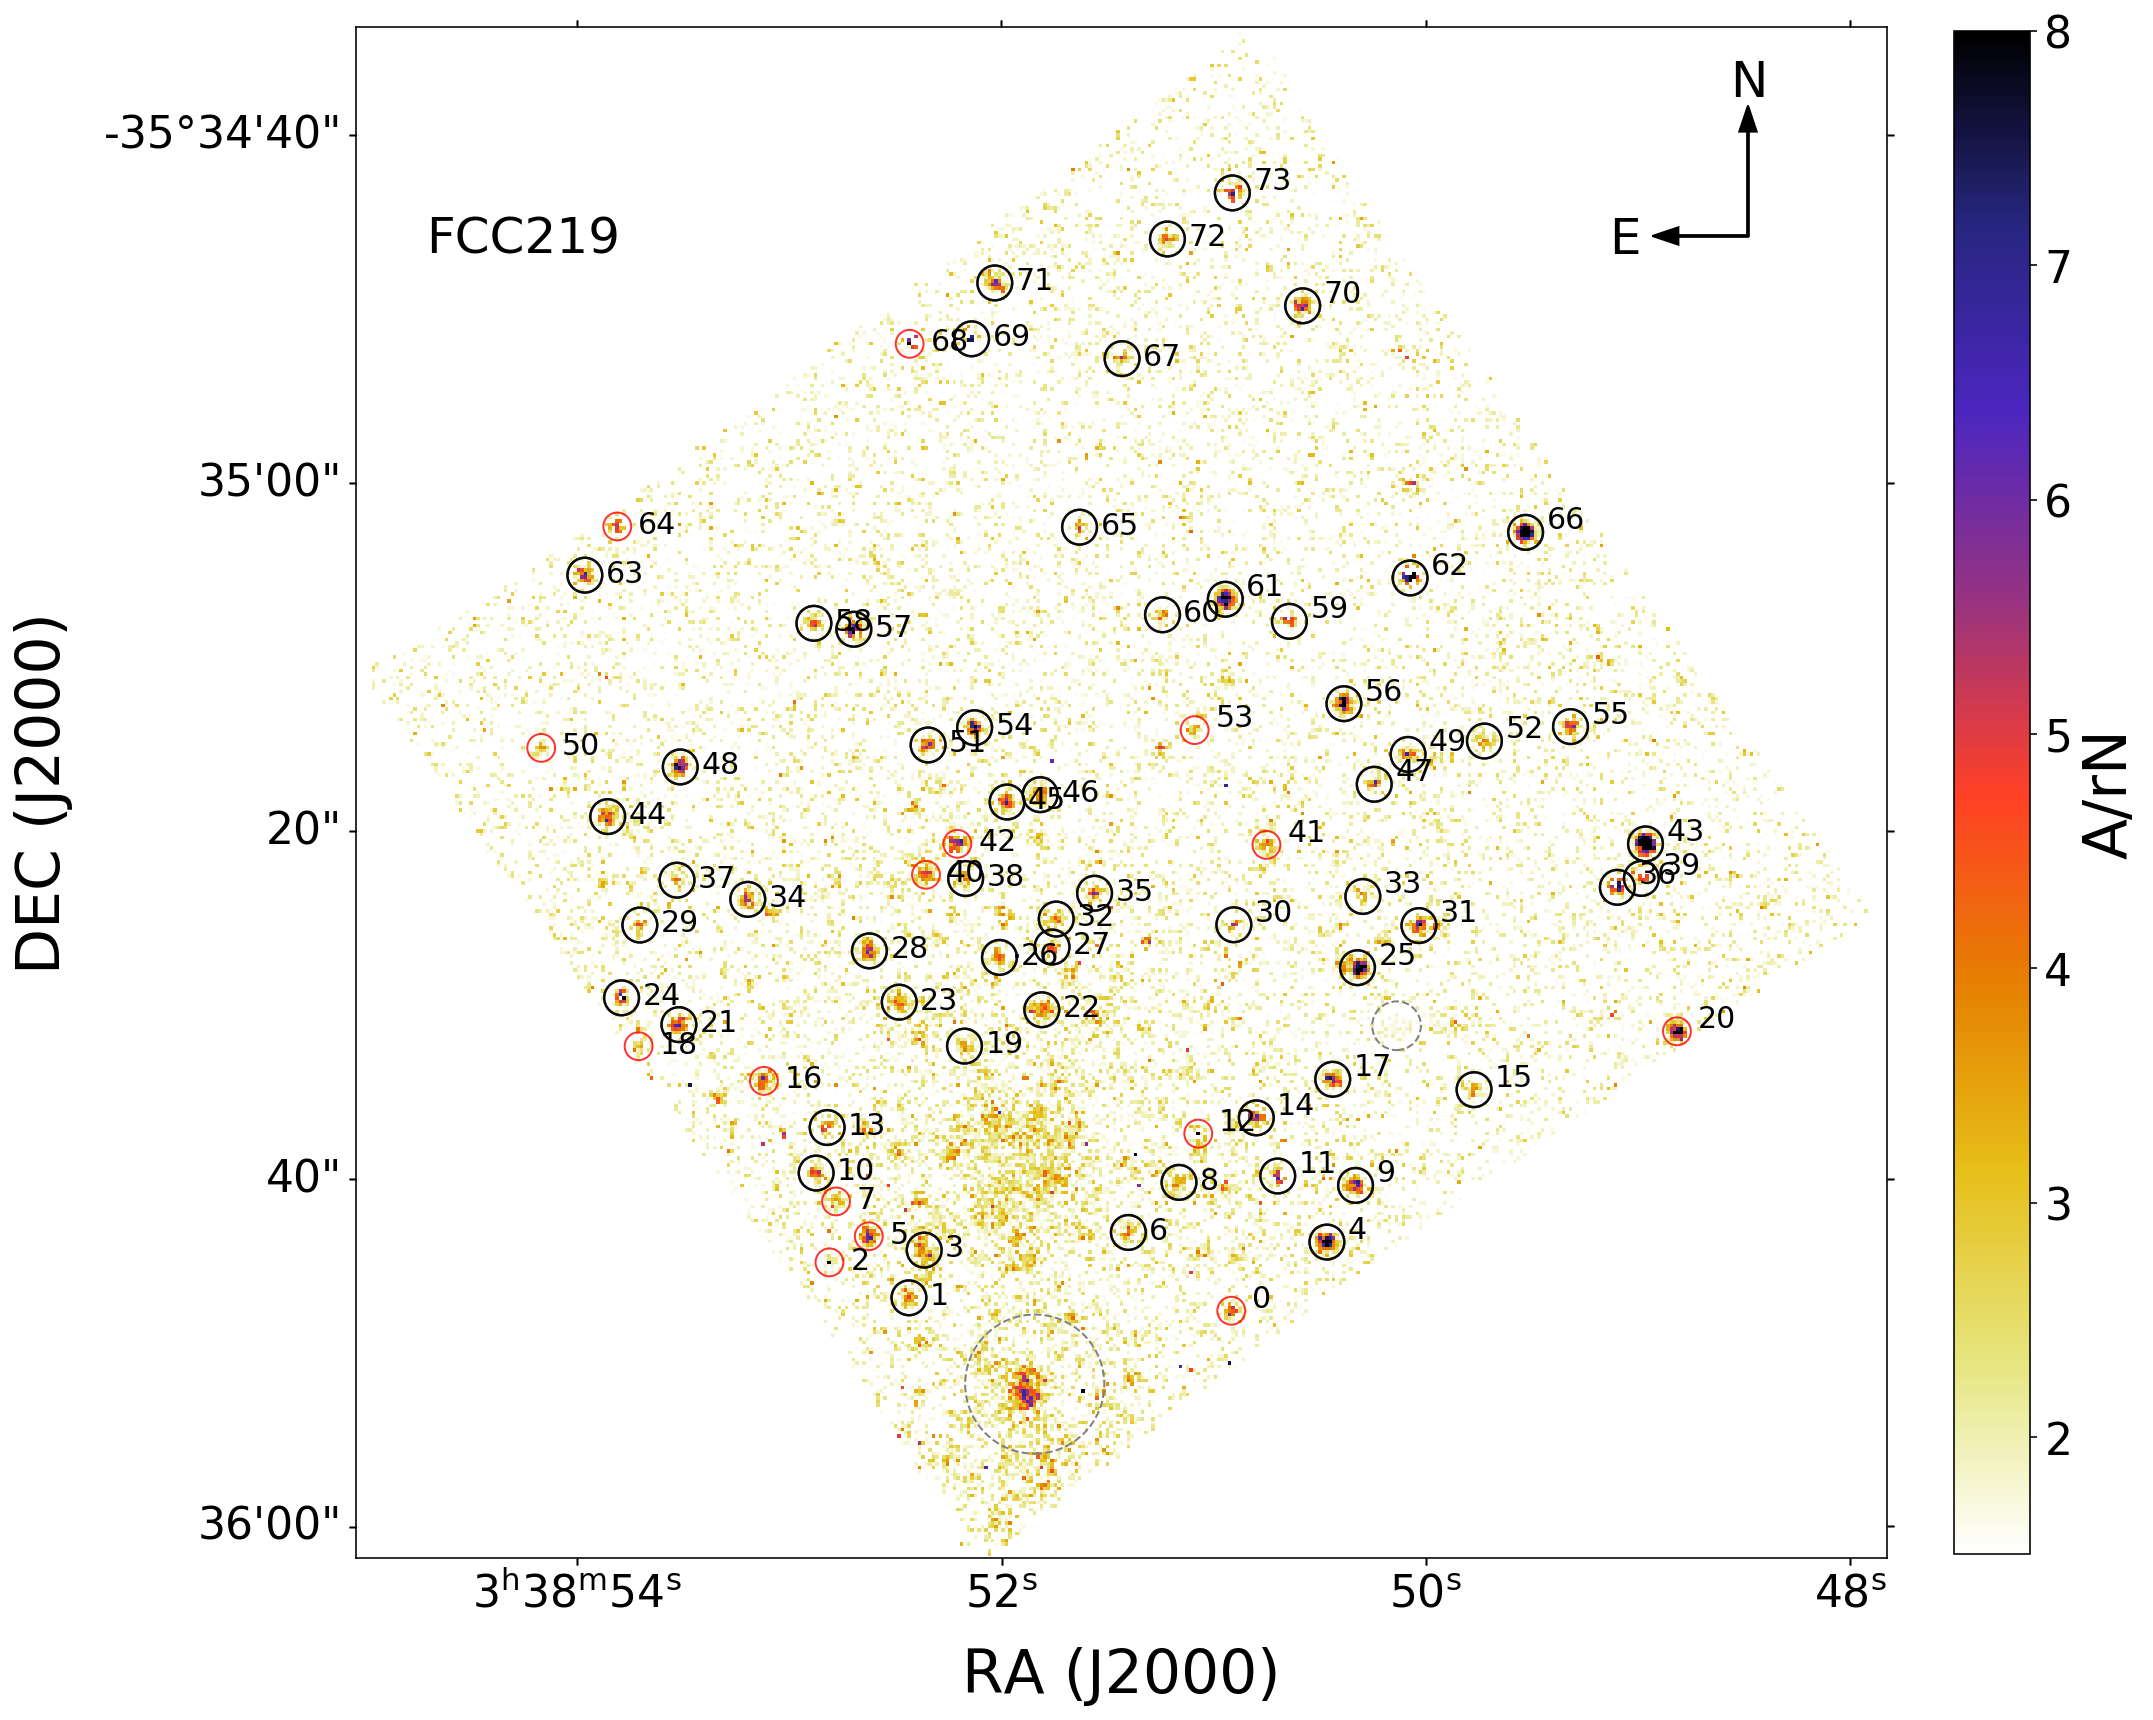

In [16]:
with fits.open(RAW_DATA) as hdu_wcs:
    hdr_wcs = hdu_wcs[1].header
    wcs_obj = WCS(hdr_wcs, naxis=2)

plt.figure(figsize=(15,15))
plt.axes(projection=wcs_obj)
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap_r",  vmin=1.5, vmax=8)
#plt.imshow(Flux_1D_cube, origin="lower", cmap="CMRmap",  vmin=10, vmax=150)
ax = plt.gca()
RA = ax.coords[0]
DEC = ax.coords[1]


cb=plt.colorbar(fraction=0.0455, pad=0.04)
cb.set_label("A/rN",fontsize=30)
cb.ax.tick_params(labelsize=22)


# plt.xlabel("x (pixels)", fontsize=30)
# plt.ylabel("y (pixels)", fontsize=30)
plt.xlabel("RA (J2000)", fontsize=30)
plt.ylabel("DEC (J2000)", fontsize=30)

plt.tick_params(labelsize = 22)

Y, X = np.mgrid[:y_data, :x_data]
xe, ye, length, width, alpha = gal_mask_params

if (galaxy_name=="FCC219") & (loc=="center"):
    plt.ylim(0,440)
    plt.xlim(0,440);
if (galaxy_name=="FCC219") & (loc=="halo"):
    plt.ylim(350,)
#     plt.xlim(440,);
elif galaxy_name=="FCC193":
    plt.ylim(250,)
    plt.xlim(0,350)
elif galaxy_name=="FCC161":
    plt.xlim(0,450)
elif galaxy_name=="FCC147":
    plt.xlim(230,)
    plt.ylim(0,320)
elif galaxy_name=="FCC083":
    plt.xlim(0,370)
    plt.ylim(0,370)
elif galaxy_name=="FCC310":
    plt.xlim(0,410)
    plt.ylim(100,)
elif galaxy_name=="FCC276":
    plt.xlim(310,)
elif galaxy_name=="FCC184":
    plt.xlim(0,450)
    plt.ylim(0,450)

elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="grey", ls="--")
ax.add_artist(elip_gal)

for star in star_mask_params:
    ax.add_artist(Circle((star[0], star[1]), radius=star[2], fill=False, color="grey", ls="--"))


for i, item in enumerate(x_y_list):
    if PNe_df.iloc[i].Filter == "Y":
        ax = plt.gca()
        circ = plt.Circle((item[0],item[1]),5, color="black",lw=1.2, fill=False, alpha=0.8)
        ax.add_artist(circ)
    elif PNe_df.iloc[i].Filter == "N":
        ax = plt.gca()
        circ = plt.Circle((item[0],item[1]),4, color="red",lw=1., fill=False, alpha=0.8)
    ax.add_artist(circ)
    if item[0]<240.:
        ax.annotate(i, (item[0]+6, item[1]-2), color="black", size=15)
    else:
        ax.annotate(i, (item[0]+6, item[1]+1), color="black", size=15)

plt.arrow(400,380, 0,30, head_width=5, width=0.5, color="k")
plt.annotate("N", xy=(395, 420), fontsize=25)
plt.arrow(400,380, -20,0, head_width=5, width=0.5, color="k")
plt.annotate("E", xy=(360, 375), fontsize=25)

plt.annotate(galaxy_name, xy=(20,375), fontsize=25)

# for i in contamination:
#     ax = plt.gca()
#     circ = plt.Circle((x_PNe[i],y_PNe[i]),6, color="r",lw=1.0, fill=False, alpha=0.7)
#     ax.add_artist(circ)
    

# plt.savefig(PLOT_DIR+"_A_rN_circled.png", bbox_inches='tight')
# plt.savefig(PLOT_DIR+"_A_rN_circled.pdf", bbox_inches='tight')
#plt.savefig(PLOT_DIR+"_Flux_circled.pdf", bbox_inches='tight')

## Save tables of PNe results for paper

In [26]:
y_idx = PNe_df.loc[PNe_df["Filter"]=="Y"].index.values
PNe_table = Table([list(PNe_df.loc[PNe_df["Filter"]=="Y"].index), PNe_df["Ra (J2000)"].loc[PNe_df["Filter"]=="Y"], PNe_df["Dec (J2000)"].loc[PNe_df["Filter"]=="Y"],
                   PNe_df["m 5007"].loc[PNe_df["Filter"]=="Y"].round(2),
                   PNe_df["A/rN"].loc[PNe_df["Filter"]=="Y"].round(1),],
                   names=("PNe number", "Ra", "Dec", "m 5007", "A/rN"))

#PNe_df["[OIII] Flux"].loc[PNe_df["Filter"]=="Y"].round(20),
# Save table in tab separated format.
ascii.write(PNe_table, f"exported_data/{galaxy_name}/{galaxy_name}_fit_results.txt", format="tab", overwrite=True) 
# Save latex table of data.
ascii.write(PNe_table, f"exported_data/{galaxy_name}/{galaxy_name}_fit_results_latex.txt", format="latex", overwrite=True) 

## Pixel array size experiment

In [ ]:
# n_pix_dist = 31
p_n = 32
plt.figure(figsize=(14,8))
n_range = np.arange(7,22,2)
store_mag = np.ones(len(n_range))
store_mu  = np.ones(len(n_range))

PN_s = PNe_spectra[p_n]
PN_s_err = robust_sigma(PN_s)

for i, n_pix_dist in enumerate(n_range):
    coordinates = [(n,m) for n in range(n_pix_dist) for m in range(n_pix_dist)]
    x_fit = np.array([item[0] for item in coordinates])
    y_fit = np.array([item[1] for item in coordinates])
    
    n_sim = 10000
    Moff_A_dist = np.random.normal(moff_A[p_n][0], moff_A_err[p_n][0],n_sim)
    FWHM_dist = np.random.normal(3.9, 0.09, n_sim)
    beta_dist = np.random.normal(2.44, 0.33, n_sim)
    x_0_dist = np.random.normal(list_of_x[p_n], x_0_err[p_n][0], n_sim)
    y_0_dist = np.random.normal(list_of_y[p_n], y_0_err[p_n][0], n_sim)
    
    def Moffat_err(Moff_A, FWHM, beta, x_0, y_0):
        alpha = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
        rr_gg = ((np.array(x_fit) - x_0)**2 + (np.array(y_fit) - y_0)**2) / alpha**2
        F_OIII_xy_dist = Moff_A * (2 * ((beta -1)/(alpha**2))) * (1 + rr_gg)**(-beta)
#         indx = np.where(F_OIII_xy_dist>=2.*PN_s_err)
        
#         return np.sum(F_OIII_xy_dist[indx]*1e-20)
        return np.sum(F_OIII_xy_dist*1e-20)
    
    flux_array = [Moffat_err(Moff_A_dist[i], FWHM_dist[i], beta_dist[i], x_0_dist[i], y_0_dist[i]) for i in range(0,n_sim)]
    mag_array = -2.5*np.log10(flux_array)-13.74
    plt.hist(mag_array, bins=12, alpha=0.3, label=f"{n_pix_dist}")
    plt.legend()
    plt.axvline(PNe_df["m 5007"].iloc[p_n], c="k")
    #plt.xlim(3.6e-17, 4.2e-17)
    #print(PNe_df["[OIII] Flux"].iloc[40])
    #print(PNe_df["m 5007"].iloc[40])
    mu_mag, std_mag = norm.fit(mag_array)
    #print(mu, (std/mu)*100,"%")
    plt.axvline(mu_mag, c="r")
    
    mu, std = norm.fit(-2.5*np.log10(flux_array)-13.72)
    #print(mu, std)
    store_mag[i] = mu_mag
    store_mu[i]  = std_mag

print(np.abs(store_mag.min()  -  PNe_df["m 5007"].iloc[p_n]))

plt.figure()
plt.plot(n_range, store_mag)
plt.axvline(n_pixels)
plt.gca().invert_yaxis()

plt.figure()
plt.plot(n_range, store_mu)
# Correction for n_pixel and flux variation from fit

## Integrated spectrum with fit

In [14]:
# from sklearn.metrics import r2_score
p=5
r2_score(np.sum(PNe_spectra[p],0), np.sum(model_spectra_list[p],0))

0.4921985942193956

In [ ]:
p = 3

print(PNe_df.loc[p])

plt.figure(figsize=(20,8))
plt.plot(wavelength, np.sum(PNe_spectra[p],0), alpha=0.7, c="k")
plt.plot(wavelength, np.sum(model_spectra_list[p],0), c="r")
plt.xlabel("Wavelength ($\AA$)", fontsize=32)
plt.ylabel("Flux", fontsize=18);

# Residual version 
res = PNe_spectra[p] - model_spectra_list[p]
plt.figure(figsize=(20,8))
plt.plot(wavelength, np.sum(PNe_spectra[p],0))
plt.plot(wavelength, np.sum(res, 0))
plt.plot(wavelength, np.sum(model_spectra_list[p], 0))
print("fitted Chi_2: "+str(PNe_df["Chi2"].iloc[p]))
print(f"chi_2 limit: {upper_chi}")



# plt.savefig(PLOT_DIR+f"_integrated_PNe_{p}_fit.png")

## Spaxel by spaxel with individual fits

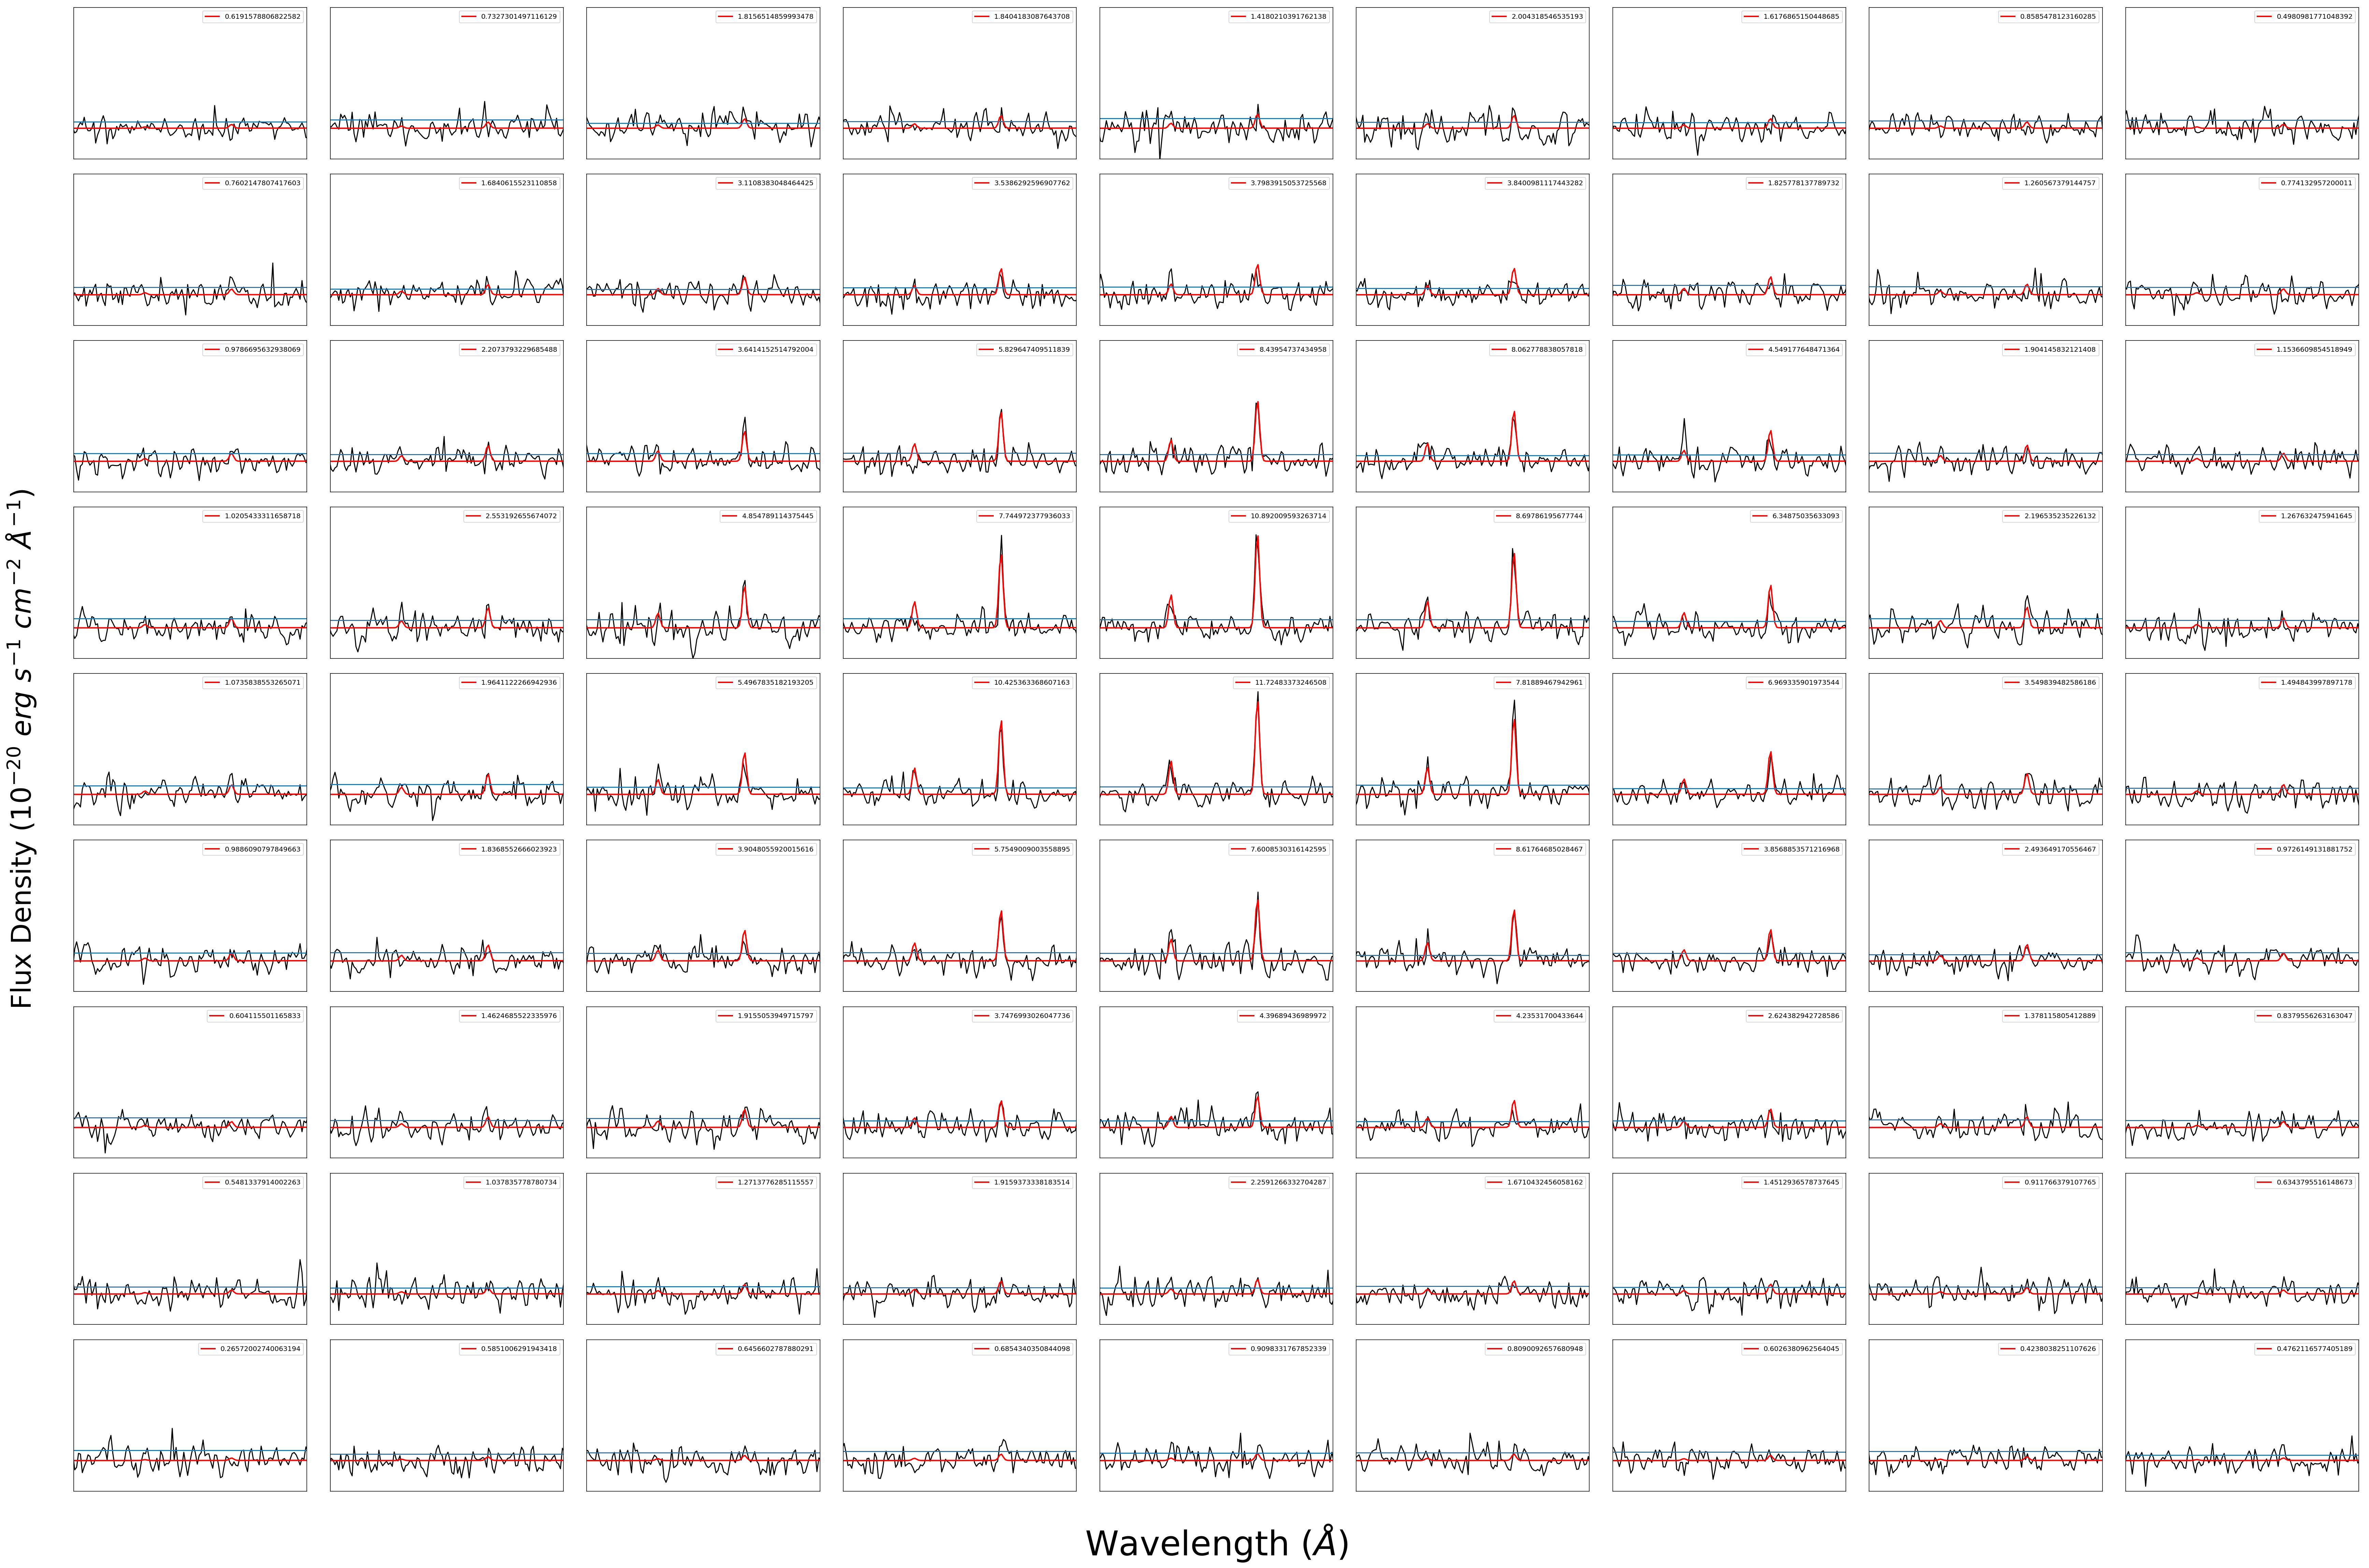

In [18]:
p = 38
PNe_n = PNe_spectra[p]
flux_1D = F_xy_list[p][0]
A_n = ((flux_1D) / (np.sqrt(2*np.pi) * 1.19))

def gaussian(x, amplitude, mean, stddev, bkg, grad, z):
    return (bkg + grad*x + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
            (np.abs(amplitude)/2.85) * np.exp(- 0.5 * (x - (mean - 47.9399*(1+z)))** 2 / (stddev**2.)))

list_of_gauss = [gaussian(wavelength, A, mean_wave_list[p][0], 1.19, Gauss_bkg[p], Gauss_grad[p], z) for A in A_n]

fig = plt.figure(figsize=(60,40))

ax = fig.add_subplot(1,1,1)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)


for i, spec in enumerate(PNe_n):
    ax1 = fig.add_subplot(n_pixels,n_pixels,i+1)
    fig.subplots_adjust(wspace=0.1, hspace=0.1)#wspace=0.25, hspace=0.3)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.plot(wavelength, spec, c="k")
    ax1.plot(wavelength, list_of_gauss[i], c="r", lw=2., alpha=1.0, label=f"{np.max(list_of_gauss[i])/robust_sigma(spec[:50])}")
    plt.axhline(robust_sigma(spec[:50]))
    ax1.tick_params(labelsize = 14, pad=8)
    plt.legend()
    ax1.set_xlim(4950,5080)
    ax1.set_ylim(-25, 100)

    
ax.set_ylabel("Flux Density ($10^{-20}$ $erg \ s^{-1}$ $cm^{-2}$ $\AA^{-1}$)", fontsize=40, labelpad=30)
ax.set_xlabel("Wavelength ($\AA$)", fontsize=50, labelpad=30);

# plt.savefig(PLOT_DIR+"_"+f"{p}"+"_spaxel_by_spaxel.pdf", bbox_inches='tight')
# plt.savefig(PLOT_DIR+"_"+f"{p}"+"_spaxel_by_spaxel.png", bbox_inches='tight')

# Prepare data packages for the GIST pipeline
- Make MUSE minicubes
- model minicubes
- residual minicubes

In [19]:
####### MUSE .fits file ####################
write_file = True

raw_hdulist = fits.open("/local/tspriggs/Fornax_data_cubes/"+galaxy_name+"center.fits")

raw_hdr = raw_hdulist[1].header
s = raw_hdulist[1].data.shape # (lambda, y, x)
full_wavelength = raw_hdr['CRVAL3']+(np.arange(s[0])-raw_hdr['CRPIX3'])*raw_hdr['CD3_3']

cube_list = np.copy(raw_hdulist[1].data).reshape(s[0], s[1]*s[2]) # (lambda, list of len y*x)
cube_list = np.swapaxes(cube_list, 1,0) # (list of len x*y, lambda)


if len(raw_hdulist) == 3:
    stat_list = np.copy(raw_hdulist[2].data).reshape(s[0], s[1]*s[2])
    stat_list = np.swapaxes(stat_list, 1,0)
elif len(raw_hdulist) == 2:
    stat_list = np.ones_like(cube_list)

    
raw_hdulist.close()

raw_minicubes = np.array([PNe_spectrum_extractor(x,y,n_pixels, cube_list, s[2], full_wavelength) for  x,y in zip(x_PNe, y_PNe)])
# stat_minicubes = np.ones_like(raw_minicubes)
stat_minicubes = np.array([PNe_spectrum_extractor(x,y,n_pixels, stat_list, s[2], full_wavelength) for  x,y in zip(x_PNe, y_PNe)])

sum_raw  = np.nansum(raw_minicubes,1)
sum_stat = np.nansum(stat_minicubes, 1)

hdu_raw_minicubes = fits.PrimaryHDU(sum_raw,raw_hdr)
hdu_stat_minicubes = fits.ImageHDU(sum_stat)
hdu_long_wavelength = fits.ImageHDU(full_wavelength)

raw_hdu_to_write = fits.HDUList([hdu_raw_minicubes, hdu_stat_minicubes, hdu_long_wavelength])

if write_file == True:
    raw_hdu_to_write.writeto(f"exported_data/{galaxy_name}/{galaxy_name}_MUSE_PNe.fits", overwrite=True)
    print(f"{galaxy_name}_MUSE_PNe.fits file saved.")
elif write_file == False:
    print(f"{galaxy_name}_MUSE_PNe.fits file already exists and hasn't been overwritten.")

##### Residual .fits file ################
residual_hdu = fits.PrimaryHDU(PNe_spectra)
wavelenth_residual = fits.ImageHDU(wavelength)
resid_hdu_to_write = fits.HDUList([residual_hdu, wavelenth_residual])
if write_file == True:
    resid_hdu_to_write.writeto(f"exported_data/{galaxy_name}/{galaxy_name}_residuals_PNe.fits", overwrite=True)
    print(f"{galaxy_name}_residuals_PNe.fits file saved.")
elif write_file == False:
    print(f"{galaxy_name}_residuals_PNe.fits file already exists and hasn't been overwritten.")



####### 3D model .fits file ##################
models_hdu = fits.PrimaryHDU(model_spectra_list)
wavelenth_models = fits.ImageHDU(wavelength)
model_hdu_to_write = fits.HDUList([models_hdu, wavelenth_models])
if write_file == True:
    model_hdu_to_write.writeto(f"exported_data/{galaxy_name}/{galaxy_name}_3D_models_PNe.fits", overwrite=True)
    print(f"{galaxy_name}_residuals_PNe.fits file saved.")
elif write_file == False:
    print(f"{galaxy_name}_3D_models_PNe.fits file already exists and hasn't been overwritten.")


############# WEIGHTED MUSE data PNe ##############
def PSF_weight(MUSE_p, model_p, r_wls, spaxels=81):
       
    coeff = np.polyfit(r_wls, np.clip(model_p[0, :], -50, 50), 1) # get continuum on first spaxel, assume the same across the minicube
    poly = np.poly1d(coeff)
    tmp = np.copy(model_p)
    for k in np.arange(0,spaxels):
         tmp[k,:] = poly(r_wls)
            
    res_minicube_model_no_continuum = model_p - tmp # remove continuum
    
    # PSF weighted minicube
    sum_model_no_continuum = np.nansum(res_minicube_model_no_continuum, 0)
    weights = np.nansum(res_minicube_model_no_continuum, 1)
    nweights = weights / np.nansum(weights) # spaxel weights
    weighted_spec = np.dot(nweights, MUSE_p) # dot product of the nweights and spectra

    return weighted_spec


weighted_PNe = np.ones((len(x_PNe), n_pixels**2, len(full_wavelength)))  #N_PNe, spaxels, wavelength length

for p in np.arange(0, len(x_PNe)):
    weighted_PNe[p] = PSF_weight(raw_minicubes[p], model_spectra_list[p], wavelength, n_pixels**2)

sum_weighted_PNe = np.nansum(weighted_PNe, 1)

hdu_weighted_minicubes = fits.PrimaryHDU(sum_weighted_PNe, raw_hdr)
hdu_weighted_stat = fits.ImageHDU(np.nansum(stat_minicubes,1))

weight_hdu_to_write = fits.HDUList([hdu_weighted_minicubes, hdu_stat_minicubes, hdu_long_wavelength])

if write_file == True:
    weight_hdu_to_write.writeto(f"../../gist_PNe/inputData/{galaxy_name}MUSEPNeweighted.fits", overwrite=True)
    print(f"{galaxy_name}_MUSE_PNe_weighted.fits file saved.")
elif write_file == False:
    print(f"{galaxy_name}_MUSE_PNe_weighted.fits file already exists and hasn't been overwritten.")



FCC167_MUSE_PNe.fits file saved.
FCC167_residuals_PNe.fits file saved.
FCC167_residuals_PNe.fits file saved.
FCC167_MUSE_PNe_weighted.fits file saved.


# Scatter points for measured PNe velocity

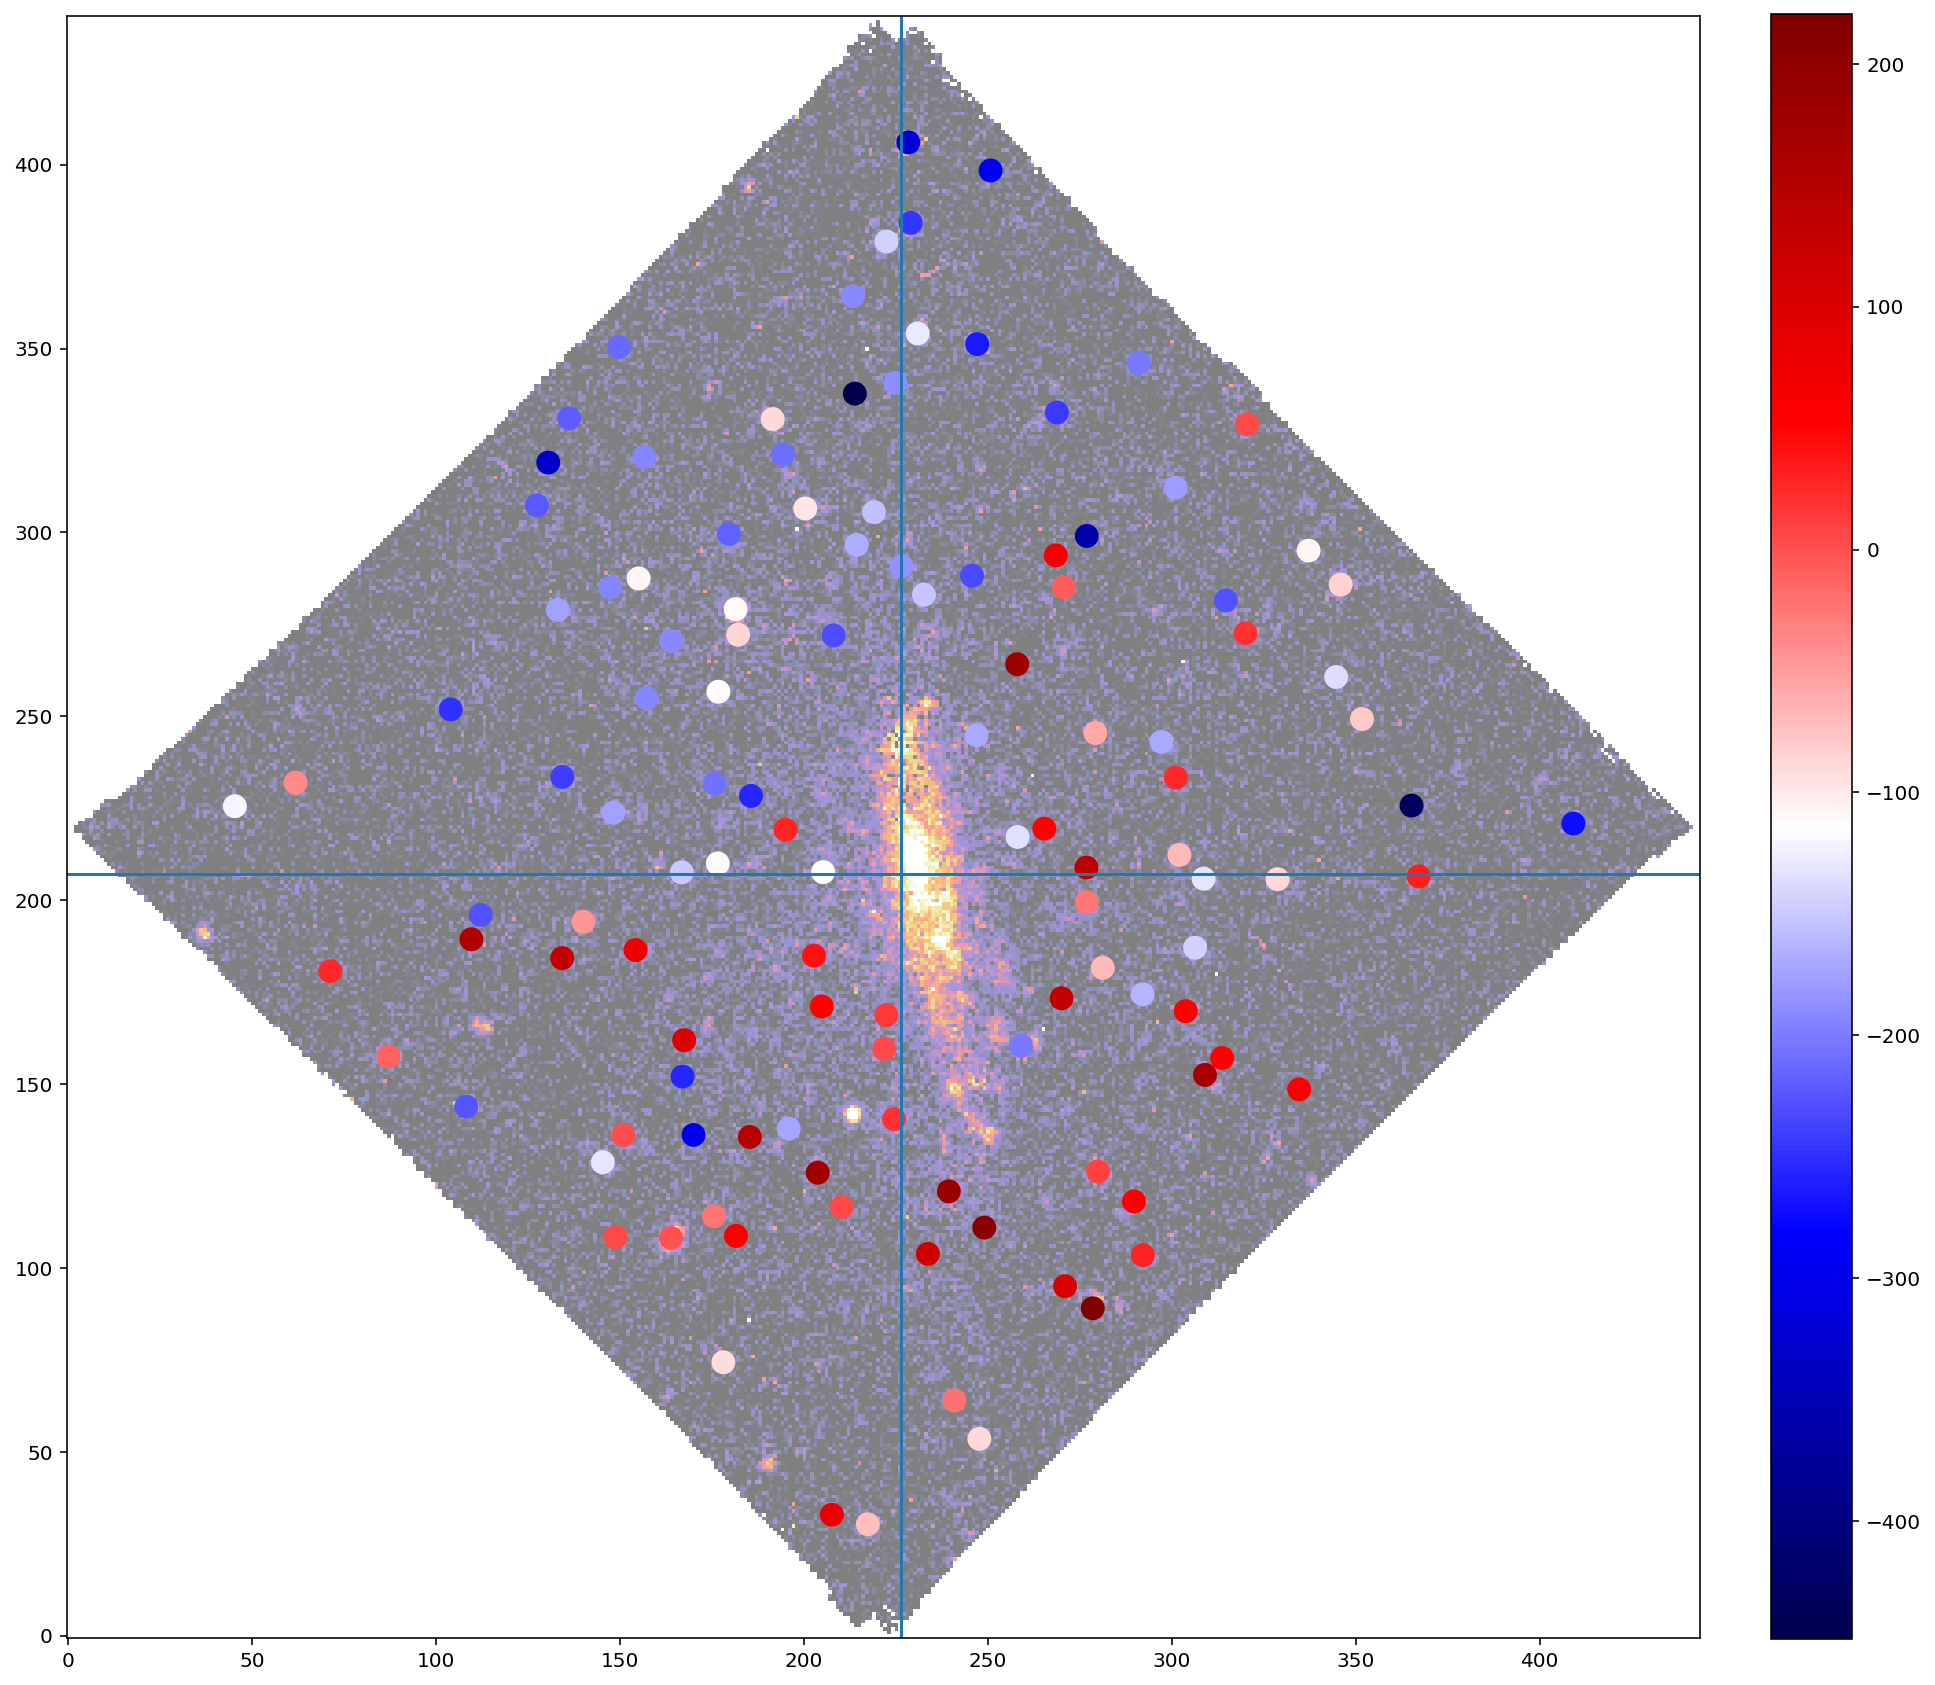

In [11]:
# Scatter plot the x y locations of PNe, colour coding them with their velocity
# ind=PNe_df.loc[PNe_df["Filter"]=="Y"].index
# y_idx = PNe_df.loc[PNe_df["Filter"]=="Y"].index.values
# n_idx = PNe_df.loc[PNe_df["Filter"]=="N"].index.values
ind=PNe_df.loc[(PNe_df["Filter"]=="Y")].index


positions = (x_PNe[ind], y_PNe[ind])
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=8., alpha=0.5)
plt.scatter(x_PNe[ind], y_PNe[ind], c=PNe_df["V (km/s)"].loc[PNe_df["Filter"]=="Y"], cmap="seismic", s=120)
# plt.scatter(x_PNe, y_PNe, c=PNe_df["m 5007"], cmap="inferno_r", s=120)
if galaxy_name=="FCC219":
    plt.ylim(0,440)
    plt.xlim(0,440)
elif galaxy_name=="FCC193":
    plt.ylim(250,)
    plt.xlim(0,350)
elif galaxy_name == "FCC276":
    plt.xlim(310,)
cb = plt.colorbar(fraction=0.0455, pad=0.04)
# cb.set_label("$V_{[OIII]} \ (km \ s^{-1}$)", fontsize=20)
#plt.savefig(PLOT_DIR"PNe_velocity_dist_map.pdf")

plt.axhline(gal_y_c)
plt.axvline(gal_x_c)

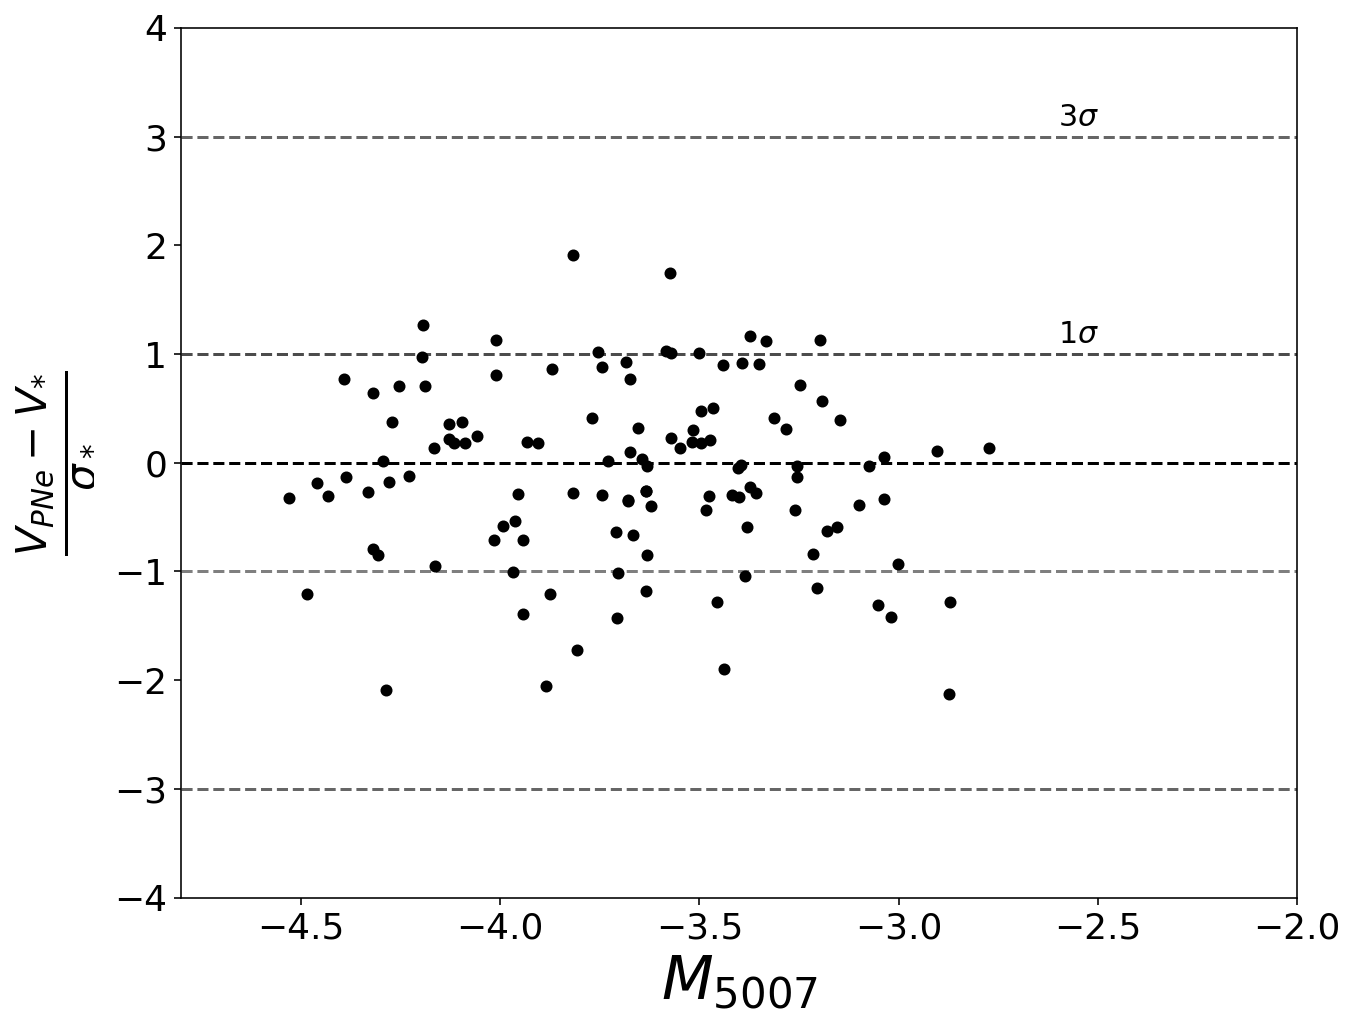

In [12]:
plt.figure(44, figsize=(10,8))
plt.clf()
plt.scatter(PNe_df["M 5007"].loc[PNe_df["Filter"]=="Y"], vel_ratio, s=25, c="k")
# plt.scatter(PNe_df["M 5007"], vel_ratio, s=25, c="k")
plt.xlabel("$M_{5007}$", fontsize=30)
plt.ylabel(r"$\frac{V_{PNe} - V_{*}}{\sigma_*}$", fontsize=30, labelpad=10)
plt.axhline(y=1, c="k", ls="dashed", alpha=0.7)
plt.axhline(y=3, c="k", ls="dashed", alpha=0.6)
plt.axhline(y=0, c="k", ls="dashed")
plt.axhline(y=-3, c="k", ls="dashed", alpha=0.6)
plt.axhline(y=-1, c="k", ls="dashed", alpha=0.5)
plt.annotate(r"1$\sigma$", xy=(-2.6,1.1), fontsize=15)
plt.annotate(r"3$\sigma$", xy=(-2.6,3.1), fontsize=15)
plt.ylim(-4,4)
plt.xlim(-4.8,-2.)
plt.tick_params(labelsize = 18)
# plt.savefig(PLOT_DIR+"_velocity_scatter_plot.pdf", bbox_inches='tight')

## Filter off PNe that are outside the 3 sigma limit

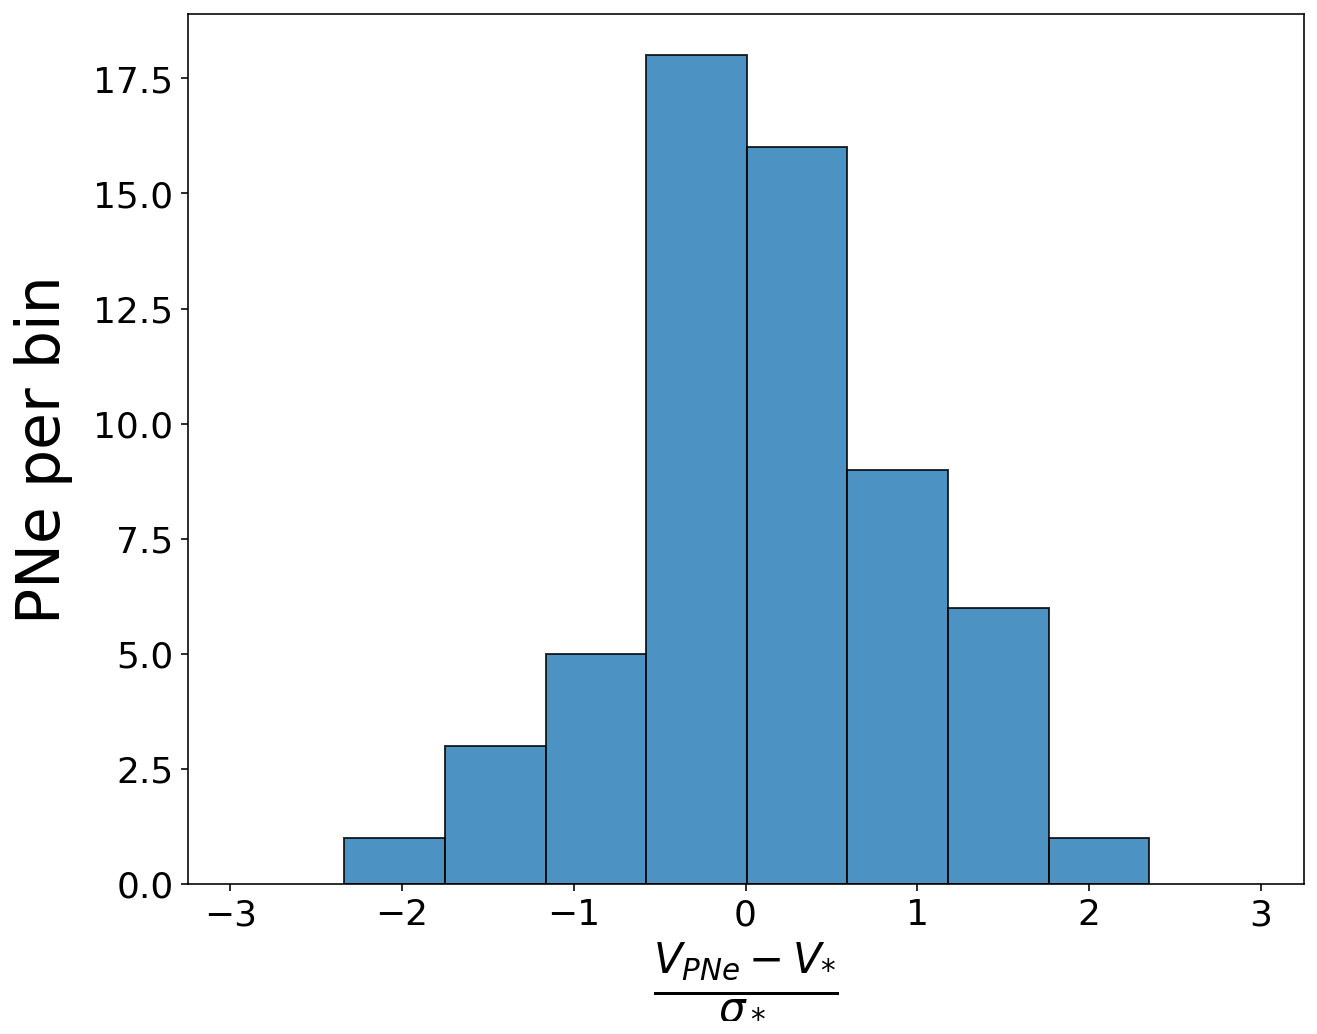

In [17]:
plt.figure(44, figsize=(10,8))
plt.clf()
plt.hist(vel_ratio[f_ind], bins=8, edgecolor="k", alpha=0.8, linewidth=1)
#fit = stats.norm.pdf(vel_ratio[f_ind], np.mean(vel_ratio[f_ind]), np.std(vel_ratio[f_ind]))
#plt.plot(vel_ratio[f_ind],fit, "o")
plt.xlabel(r"$\frac{V_{PNe} - V_{*}}{\sigma_*}$", fontsize=30)
plt.ylabel("PNe per bin", fontsize=30, labelpad=10)
plt.tick_params(labelsize = 18)
plt.xlim(-3.25,3.25)
#plt.ylim(0,50)
plt.savefig(PLOT_DIR+"_velocity_bins_plot.pdf", bbox_inches='tight')

#plt.figure()
#sns.distplot(vel_ratio[f_ind], hist=True, fit=stats.norm, kde=True, bins=10,
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 2})

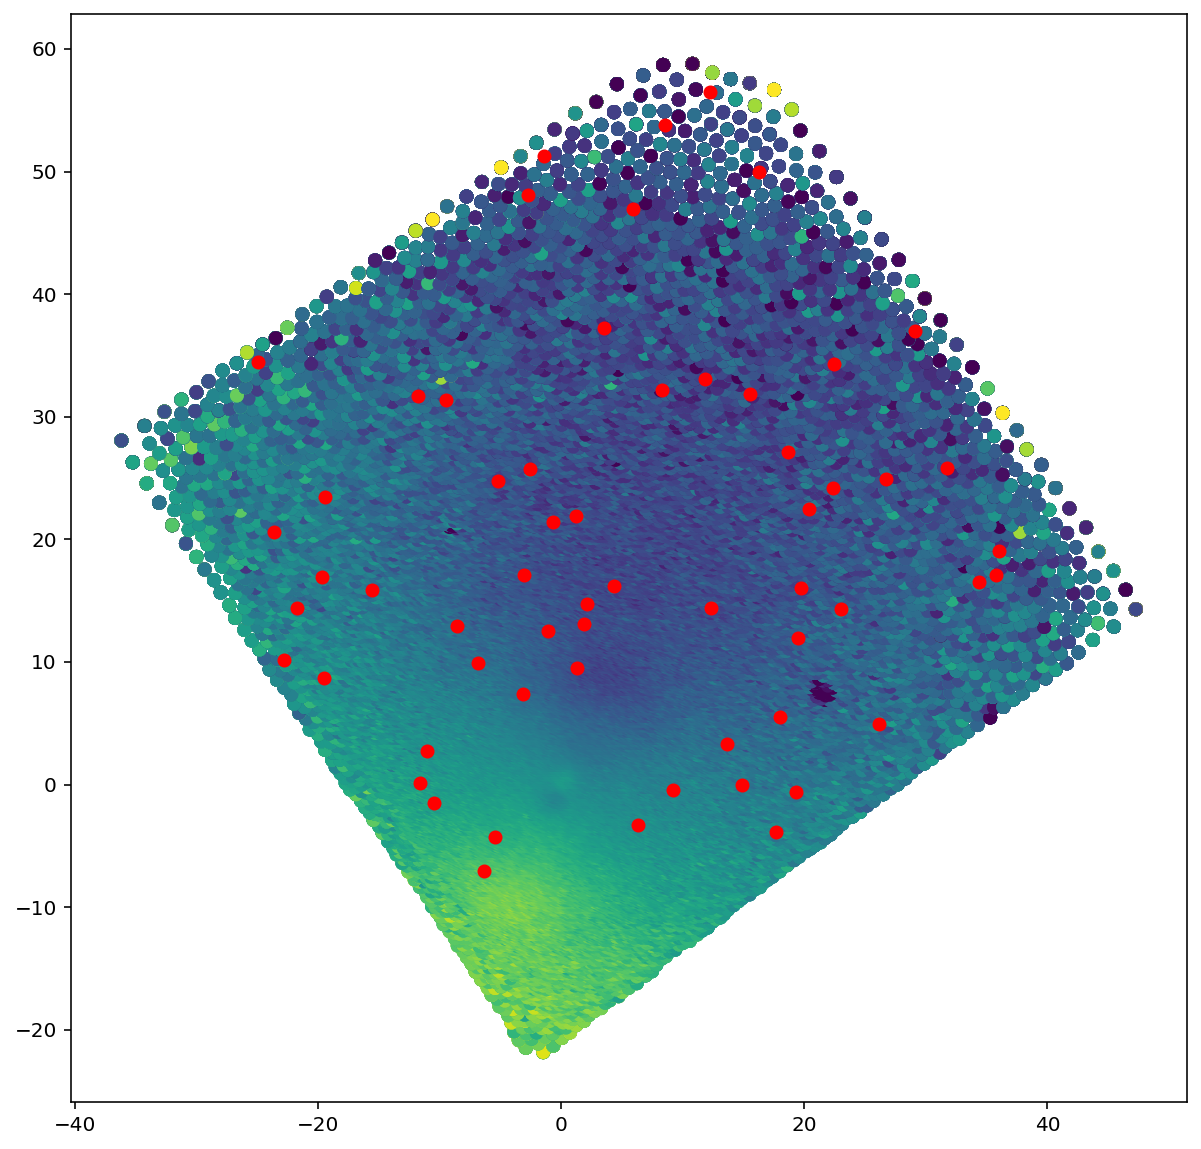

In [74]:
plt.figure(figsize=(10,10))
plt.scatter(X_star, Y_star, c=v_star, vmin=-150, vmax=150)
plt.scatter(xpne,ypne,c="r")
#plt.colorbar()

## Table setup for Marc

In [45]:
## Tables for Marc
y_idx = PNe_df.loc[PNe_df["Filter"]=="Y"].index.values
n_idx = PNe_df.loc[PNe_df["Filter"]=="N"].index.values

tab_all = Table([PNe_df["PNe number"].values, 
                 PNe_df["A/rN"].values, 
                 PNe_df["Chi2"].values, 
                 A_2D_list[:,0], x_PNe, y_PNe, objects["peak"], mean_wave_list[:,0]], 
                names=("PNe #","fit A/rN", "Chi2", "A", "x", "y", "SEP A/rN", "best_fit_wave"))

tab_filter = Table([PNe_df["PNe number"].loc[PNe_df["Filter"]=="Y"], 
                    PNe_df["A/rN"].loc[PNe_df["Filter"]=="Y"].values, 
                    PNe_df["Chi2"].loc[PNe_df["Filter"]=="Y"].values, A_2D_list[y_idx,0], x_PNe[y_idx], y_PNe[y_idx], 
                    objects["peak"][y_idx], mean_wave_list[y_idx,0]], 
                   names=("PNe #","fit A/rN", "Chi2", "A", "x", "y", "SEP A/rN", "best_fit_wave"))

ascii.write(tab_all, EXPORT_DIR+galaxy_name+"_SEP_all_data_Table.dat", overwrite=True)
ascii.write(tab_filter, EXPORT_DIR+galaxy_name+"_SEP_filtered_data_Table.dat", overwrite=True)

# PSF determination

In [ ]:
### Single Run PSF Fitter
#sel_PNe = PNe_df.nsmallest(4, "m 5007").index.values
if galaxy_name == "FCC083":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(5, "A/rN").index.values#.loc[(PNe_df["PNe number"] != 40) & (PNe_df["PNe number"] != 60)].nlargest(5, "A/rN").index.values#.loc[PNe_df["PNe number"] != 38].
elif galaxy_name == "FCC119":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(1, "A/rN").index.values
elif galaxy_name == "FCC143":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(3, "A/rN").index.values
elif galaxy_name == "FCC147":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[(PNe_df["PNe number"] != 28)&(PNe_df["PNe number"] != 27)].nlargest(5, "A/rN").index.values
    #sel_PNe = [43,64,19,12,6]
elif galaxy_name == "FCC153":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(5, "A/rN").index.values
elif galaxy_name == "FCC161":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(5, "A/rN").index.values#.loc[PNe_df["PNe number"] != 38].
elif (galaxy_name == "FCC167") & (loc =="center"):
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[(PNe_df["PNe number"] != 26) &(PNe_df["PNe number"] != 17) & (PNe_df["PNe number"] != 138)].nlargest(3, "A/rN").index.values
elif (galaxy_name == "FCC167") & (loc =="middle"):
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(3, "A/rN").index.values
elif galaxy_name == "FCC177":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(4, "A/rN").index.values
elif galaxy_name == "FCC182":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(2, "A/rN").index.values
    #sel_PNe = [6,0,8]
elif galaxy_name == "FCC184":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] !=29].nlargest(5, "A/rN").index.values
#     sel_PNe = [ 8, 71, 67]
elif galaxy_name == "FCC190":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(6, "A/rN").index.values
elif galaxy_name == "FCC193":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(8, "A/rN").index.values#.loc[PNe_df["PNe number"] != 94]
elif (galaxy_name == "FCC219") & (loc=="center"):
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] !=66].nlargest(5, "A/rN").index.values
elif (galaxy_name == "FCC219") & (loc=="halo"):
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(5, "A/rN").index.values
elif galaxy_name == "FCC249":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] !=3].nlargest(2, "A/rN").index.values
#     sel_PNe = [1,19,3]
elif galaxy_name == "FCC255":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(5, "A/rN").index.values
elif galaxy_name == "FCC276":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] != 12].nlargest(7, "A/rN").index.values#.loc[PNe_df["PNe number"] != 21]
elif galaxy_name == "FCC277":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(5, "A/rN").index.values
elif galaxy_name == "FCC301":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] != 14].nlargest(5, "A/rN").index.values
elif galaxy_name == "FCC310":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].nlargest(7, "A/rN").index.values

#sel_PNe = PNe_df.loc[PNe_df["PNe number"] != 1].nlargest(10, "A/rN").index.values

# sel_PNe = [4,]# 38, 26, 141]#, 38]#, 141]#, 29]
print(sel_PNe)

selected_PNe = PNe_spectra[sel_PNe]
selected_PNe_err = obj_error_cube[sel_PNe]
# selected_PNe_err = np.ones_like(error_cube[sel_PNe])
PSF_params = Parameters()

def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.01)
    PSF_params.add("x_{:03d}".format(n), value=(n_pixels/2.), min=(n_pixels/2.) -4, max=(n_pixels/2.) +4)
    PSF_params.add("y_{:03d}".format(n), value=(n_pixels/2.), min=(n_pixels/2.) -4, max=(n_pixels/2.) +4)
    PSF_params.add("wave_{:03d}".format(n), value=mean, min=mean-20., max=mean+20.)
    PSF_params.add("gauss_bkg_{:03d}".format(n),  value=0.001, vary=True)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.001, vary=True)


for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, mean=5006.77*(1+z))    
    
PSF_params.add('FWHM', value=4.0, min=0.01, vary=True)
PSF_params.add("beta", value=2.5, min=0.01, vary=True) 
PSF_params.add("LSF",  value=2.5, min=0.01, vary=True)

PSF_results = minimize(PSF_residuals_3D, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err, z), nan_policy="propagate")

print("FWHM: ", round(PSF_results.params["FWHM"].value, 4), "+/-", round(PSF_results.params["FWHM"].stderr, 4), "(", (PSF_results.params["FWHM"].stderr / PSF_results.params["FWHM"].value)*100, "%)")
print("Beta: ", round(PSF_results.params["beta"].value, 4), "+/-", round(PSF_results.params["beta"].stderr, 4), "(", (PSF_results.params["beta"].stderr / PSF_results.params["beta"].value)*100, "%)")
print("LSF: " , round(PSF_results.params["LSF"].value , 4), "+/-", round(PSF_results.params["LSF"].stderr , 4), "(", (PSF_results.params["LSF"].stderr / PSF_results.params["LSF"].value)*100, "%)")
print("\n")

# Plot locations of PNe used for PSF
plt.figure(figsize=(15,15))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap",  vmin=1.5, vmax=8)
ax = plt.gca()
cb=plt.colorbar(fraction=0.0455, pad=0.04)
cb.set_label("A/rN",fontsize=30)
cb.ax.tick_params(labelsize=22)

plt.xlabel("x (pixels)", fontsize=30)
plt.ylabel("y (pixels)", fontsize=30)

plt.tick_params(labelsize = 22)

# Plot out and circle the PNe used for the PSF routine
for (i, item), n in zip(enumerate(x_y_list[sel_PNe]), sel_PNe):
    ax = plt.gca()
    circ = plt.Circle((item[0],item[1]),5.5, color="white",lw=1.5, fill=False)
    ax.add_artist(circ)
    if item[0]<240.:
        ax.annotate(n, (item[0]+8, item[1]-4), color="white", size=10)
    else:
        ax.annotate(n, (item[0]+8, item[1]+2), color="white", size=10)

plt.show()
print(report_fit(PSF_results, show_correl=False))


# PNLF

/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/MUSE_Models.py:122: RuntimeWarning: invalid value encountered in true_divide
  u2 = (d/(9.0*mad))**2  # c = 9
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/MUSE_Models.py:123: RuntimeWarning: invalid value encountered in less
  good = u2 < 1.0
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/MUSE_Models.py:127: RuntimeWarning: invalid value encountered in double_scalars
  sigma = np.sqrt(num/(den*(den - 1.0)))  # see note in above reference
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/PNLF.py:120: RuntimeWarning: invalid value encountered in less
  image[image<0] = 0 # iamge data: set any values that are less than 0, equal to 0.
/auto/data/tspriggs/Jupyterlab_dir/Github/MUSE_PNe_fitting/PNLF.py:158: RuntimeWarning: divide by zero encountered in true_divide
  completeness_ratio[i] = (np.nansum(image[((amp / Noise_map) > peak)]) / np.nansum(image)).astype(np.float128)
/auto/data/tspriggs/Jupyt

c(a) = 1.073


KS2 p-value test
    KS2 sample p-value greater than 0.1.
    We cannot reject the Null hypothesis.


KS2 D statistic test
    D (0.333) is less than 0.506
    The Null hypothesis is NOT rejected. The two samples match within a confidence of 0.1.


Ks_2sampResult(statistic=0.3333333333333333, pvalue=0.7301110654051831)
Number of PNe from PNLF:  307.4369933266387 +/- 40.02488735641391


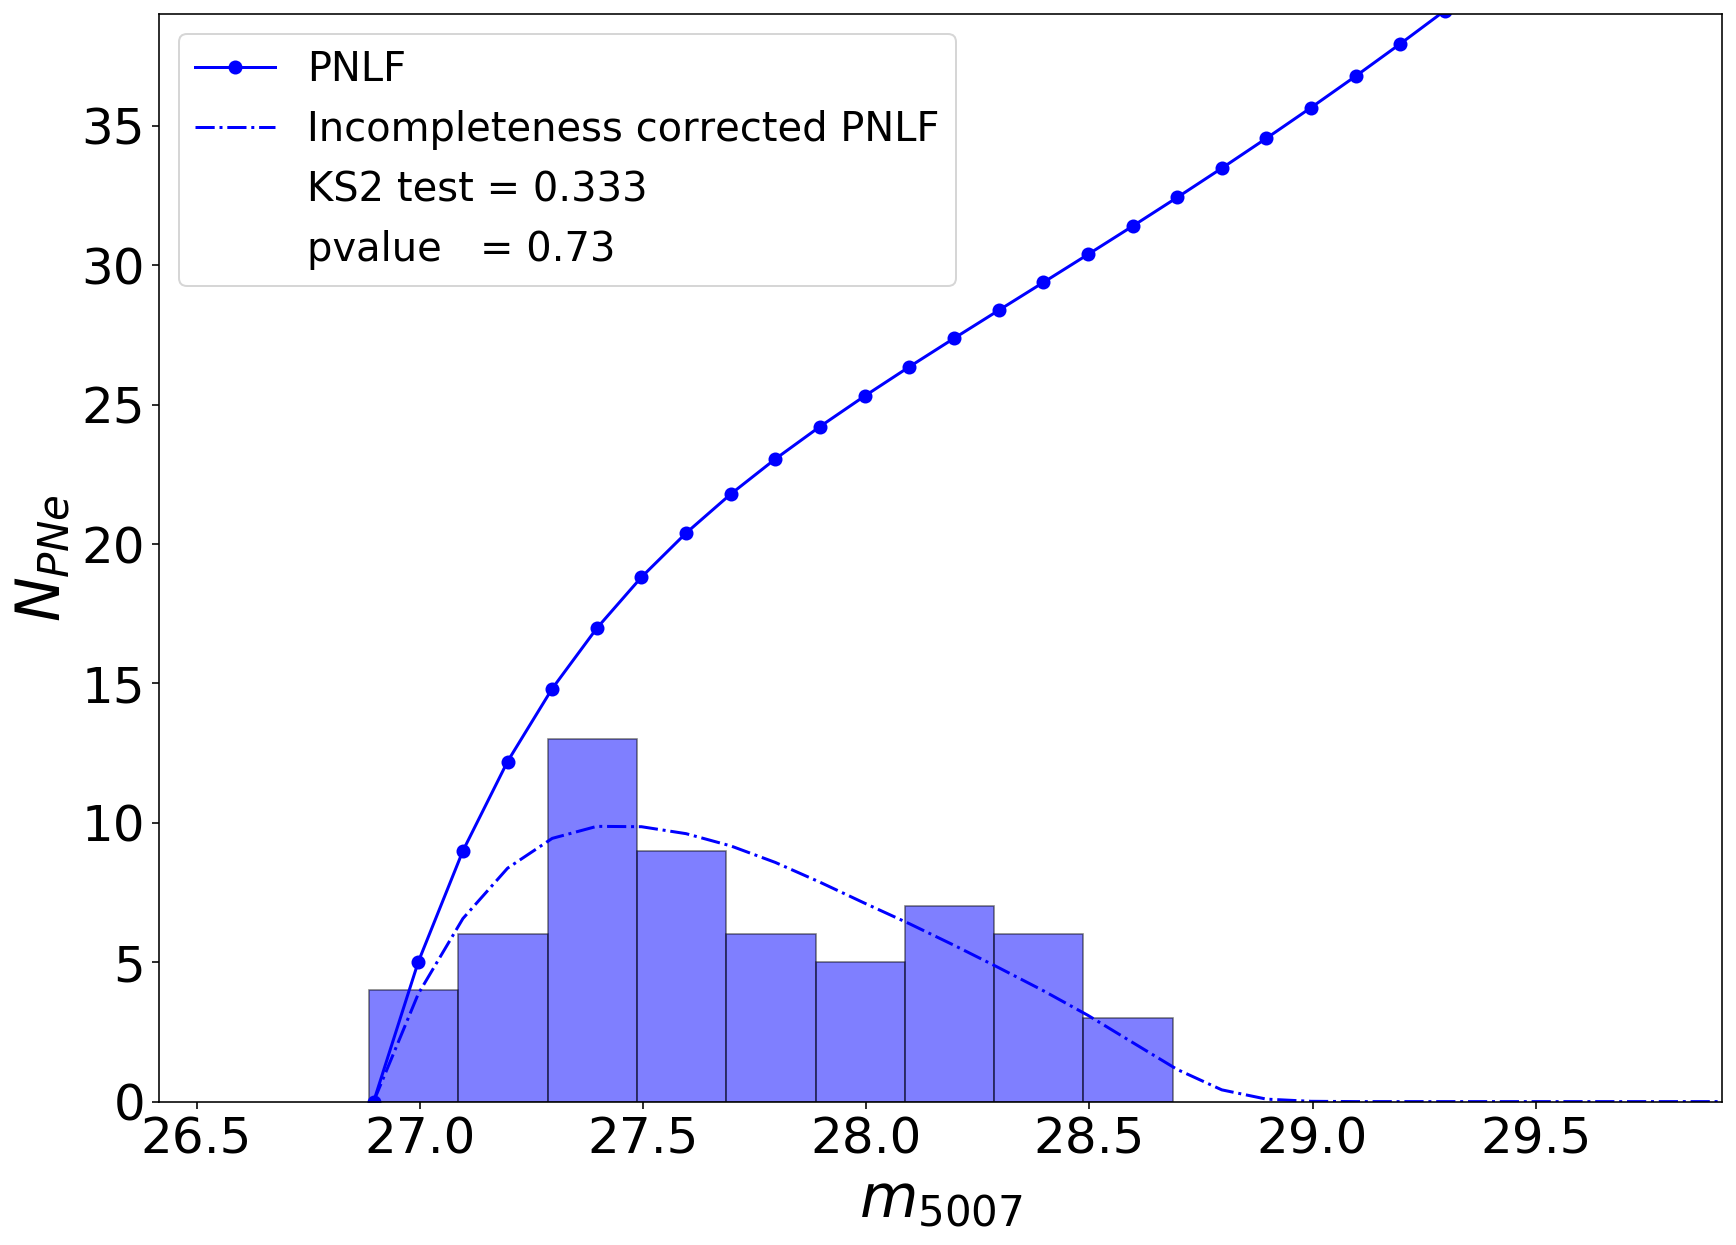

In [18]:
# x_data_cen, y_data_cen, gal_data, wav = open_data(galaxy_name, loc)

galaxy_image, wave = reconstructed_image(galaxy_name, loc)
galaxy_image = galaxy_image.reshape([y_data, x_data])

PNe_mag = PNe_df["M 5007"].loc[PNe_df["Filter"]=="Y"].values
app_mag = PNe_df["m 5007"].loc[PNe_df["Filter"]=="Y"].values

# Total PNLF
PNLF, PNLF_corr, completeness_ratio, Abs_M, app_m = completeness(galaxy_name, loc, PNe_mag, PNe_multi_params, Dist_est, galaxy_image, peak=3.0,
                                      gal_mask_params=gal_mask_params, star_mask_params=star_mask_params, c1=0.307, z=z ) # Estimating the completeness for the central pointing

step = abs(Abs_M[1]-Abs_M[0])
# Getting the normalisation - sum of correctied PNLF, times bin size
total_norm = np.sum(np.abs(PNLF_corr)) * step

# Scaling factor
scal = len(PNe_mag) / total_norm

# Constraining to -2.0 in magnitude
idx = np.where(Abs_M <= np.min(PNe_mag)+2.5)
# Total number of PNe
# tot_N_PNe = np.sum(PNLF_corr[idx]*scal)*abs(Abs_M[1]-Abs_M[0])
# tot_N_PNe = np.sum(PNLF[idx]*scal) * step



plt.figure(figsize=(14,10))

binwidth = 0.2

# hist = plt.hist(PNe_mag, bins=np.arange(min(PNe_mag), max(PNe_mag) + binwidth, binwidth), edgecolor="black", linewidth=0.8, alpha=0.5, color='blue')
hist = plt.hist(app_mag, bins=np.arange(min(app_mag), max(app_mag) + binwidth, binwidth), edgecolor="black", linewidth=0.8, alpha=0.5, color='blue')

KS2_stat = KS2_test(dist_1=PNLF_corr[1:18:2]*scal*binwidth, dist_2=hist[0], conf_lim=0.1)
print(KS2_stat)

ymax = max(hist[0])

plt.plot(app_m, PNLF*scal*binwidth, '-', color='blue', marker="o", label="PNLF")
plt.plot(app_m, PNLF_corr*scal*binwidth,'-.', color='blue', label="Incompleteness corrected PNLF")
# plt.plot(Abs_M, completeness_ratio*200*binwidth, "--", color="k", label="completeness")
plt.xlabel(r'$m_{5007}$', fontsize=30)
plt.ylabel(r'$N_{PNe}$', fontsize=30)
#plt.yticks(np.arange(0,ymax+4, 5))
plt.plot(0,0, alpha=0.0, label=f"KS2 test = {round(KS2_stat[0],3)}")
plt.plot(0,0, alpha=0.0, label=f"pvalue   = {round(KS2_stat[1],3)}")
plt.xlim(-5.0+dM,-1.5+dM); 
plt.ylim(0,ymax+(2*ymax));
# plt.xlim(26.0,30.0); plt.ylim(0,45);

plt.tick_params(labelsize = 25)

#plt.axvline(PNe_df["m 5007"].loc[PNe_df["Filter"]=="Y"].values.min() - 31.63)
plt.legend(loc=2, fontsize=20)
plt.savefig(PLOT_DIR+"_PNLF.pdf", bbox_inches='tight')
plt.savefig(PLOT_DIR+"_PNLF.png", bbox_inches='tight')


N_PNe = np.sum(PNLF[idx]*scal) * step

# print("Number of PNe from PNLF: ", N_PNe, "+/-", (1/np.sqrt(len(PNe_df.loc[PNe_df["Filter"]=="Y"])))*N_PNe)
print("Number of PNe from PNLF: ", N_PNe, "+/-", (1/np.sqrt(len(PNe_df.loc[PNe_df["Filter"]=="Y"])))*N_PNe)

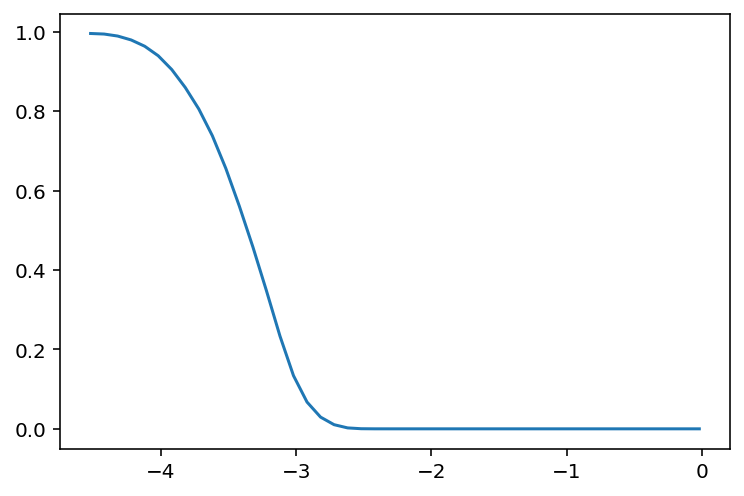

In [11]:
plt.plot(Abs_M, completeness_ratio)

In [ ]:
norm_0 = (binwidth * PNLF[1:18:2]).sum()
norm_1 = (binwidth * PNLF_corr[1:18:2]).sum()
norm_2 = (binwidth * hist[0]).sum()

PNLF_cdf = np.cumsum(PNLF[1:18:2]/norm_0   * binwidth)
PNLF_corr_cdf = np.cumsum(PNLF_corr[1:18:2]/norm_1  * binwidth)
data_cdf = np.cumsum(hist[0]/norm_2  * binwidth)

plt.figure(figsize=(12,8))

plt.plot(hist[1][1:], PNLF_cdf,label="PNLF")
# plt.plot(hist[1][1:], PNLF[1:18:2]/norm_0)
plt.plot(hist[1][1:], PNLF_corr_cdf, label="completness corrected PNLF")
# plt.plot(hist[1][1:], PNLF_corr[1:18:2]/norm_1 )
plt.plot(hist[1][1:],data_cdf, label="Observed PNe")
plt.legend(fontsize=20)
# plt.plot(hist[1][:-1],hist[0]/norm_2)
plt.xlabel(r"$M_{5007}$", fontsize=15)
plt.ylabel("CDF, p", fontsize=15)
# plt.savefig(PLOT_DIR+"_PNLF_CDF.png", bbox_inches='tight')

## L_Bol using pPXF

100%|██████████| 92768/92768 [00:19<00:00, 4689.15it/s]


Collapsing cube now....
Cube has been collapsed...
Best Fit:       Vel     sigma        h3        h4
 comp. 0:      1870       190     0.017     0.006
chi2/DOF: 0.000367
method = capfit; Jac calls: 3; Func calls: 62; Status: 2
Nonzero Templates: 4 / 636
Formal errors:
     dV    dsigma   dh3      dh4
     3.9     4.7   0.017   0.019
Elapsed time in PPXF: 87.74 s


(array([1.63253955e+10]), [array([1.81613493e+10]), array([1.48513812e+10])], array([1.52975866e+10]), [array([1.70179531e+10]), array([1.39163728e+10])], array([1.77167797e+10]), [array([1.97092085e+10]), array([1.61171377e+10])], 11.446293846015955, 10.488777194851991, 10.939324698781828)


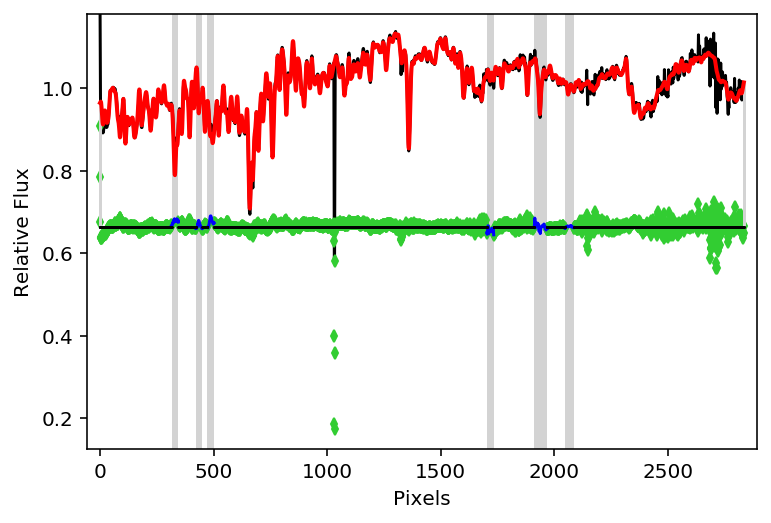

In [41]:
raw_data_cube = RAW_DATA # read in raw data cube

xe, ye, length, width, alpha = gal_mask_params

orig_hdulist = fits.open(raw_data_cube)
raw_data_cube = np.copy(orig_hdulist[1].data)
h1 = orig_hdulist[1].header
s = np.shape(orig_hdulist[1].data)
Y, X = np.mgrid[:s[1], :s[2]]
elip_mask = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1    

# Now mask the stars
star_mask_sum = np.sum([(Y - yc)**2 + (X - xc)**2 <= rc**2 for xc,yc,rc in star_mask_params],0).astype(bool)

total_mask = ((np.isnan(orig_hdulist[1].data[1,:,:])==False) & (elip_mask==False) & (star_mask_sum==False))
indx_mask = np.where(total_mask==True)

good_spectra = np.zeros((s[0], len(indx_mask[0])))

for i, (y, x)  in enumerate(zip(tqdm(indx_mask[0]), indx_mask[1])):
    good_spectra[:,i] = raw_data_cube[:,y,x]

print("Collapsing cube now....")    
    
gal_lin = np.nansum(good_spectra, 1)
        
print("Cube has been collapsed...")
# dM = 31.265#5*np.log10(galaxy_df.loc[galaxy_df["Galaxy"]==galaxy_name, "lit D"].values[0]) +25

## L_bol = lum_bol_g, lum_bol_r, mag_r, M_r
L_bol = ppxf_L_tot(int_spec=gal_lin, header=h1, redshift=z, vel=gal_vel, dist_mod=dM, dM_err=[dM_err_up, dM_err_lo])#, calc_L_bol=False)


print(L_bol)

In [43]:
# Print N PNe used after filter and distance values
print(galaxy_name)
n_p = len(PNe_df.loc[PNe_df["Filter"]=="Y"])
print(f"N PNe used:      {n_p}")
print(f"PNLF N:          {N_PNe}")
print(f"L_bol of:        {L_bol[0]}")
print(f"L_bol error:     + {L_bol[1][0] - L_bol[0]}, - {L_bol[0] - L_bol[1][1]}")
print(f"Rmag of :        {L_bol[7]}")
print(f"Vmag of :        {L_bol[8]}")
print(f"Distance of:     {Dist_est} +/- {Dist_err_up}")
print(f"Distance Mod of: {dM} +/- {dM_err_up}")


FCC167
N PNe used:      85
PNLF N:          277.47489916629286
L_bol of:        [1.63253955e+10]
L_bol error:     + [1.83595379e+09], - [1.47401433e+09]
Rmag of :        10.488777194851991
Vmag of :        10.939324698781828
Distance of:     17.410233710474326 +/- 0.9277371145203942
Distance Mod of: [31.194] +/- 0.11571099968941068


In [ ]:
%run PNe_fitting.py FCC161


In [46]:
def galaxy_df_input(gal_name, PNe_N, PNLF_N, L_bol, L_bol_p, L_bol_m, R, lit_R, sigma, metal_M_H, metal_Mg_Fe, age, mass=np.nan,
                    D_PNLF=np.nan, D_PNLF_err=np.nan, dM_PNLF=np.nan, dM_PNLF_err=np.nan, lit_dM=np.nan, lit_dM_err=np.nan,
                    FUV=np.nan, FUV_err=np.nan, NUV=np.nan, NUV_err=np.nan, GALEX_FUV=np.nan, GALEX_NUV=np.nan,
                    V=np.nan, V_err=np.nan, R_err=np.nan, B=np.nan, B_err=np.nan, 
                    m5007=np.nan, m5007_err=np.nan, lit_Lbol=np.nan, lit_Lbol_p=np.nan, lit_Lbol_m=np.nan, lit_PNLF_N=np.nan):
    
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "D PNLF"]      = D_PNLF
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "D PNLF err"]  = D_PNLF_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "dM PNLF"]     = dM_PNLF
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "dM PNLF err"] = dM_PNLF_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "PNe N"]       = PNe_N
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "PNLF N"]      = PNLF_N
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Lbol"]        = L_bol
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Lbol p"]      = L_bol_p
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Lbol m"]      = L_bol_m
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Rmag"]        = R
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "lit Rmag"]    = lit_R
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Rmag err"]    = R_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "sigma"]       = sigma
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "M/H"]         = metal_M_H
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Mg/Fe"]       = metal_Mg_Fe
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "age"]         = age
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "GALEX FUV"]   = GALEX_FUV
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "FUV"]         = FUV
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "FUV err"]     = FUV_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "GALEX NUV"]   = GALEX_NUV
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "NUV"]         = NUV
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "NUV err"]     = NUV_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Vmag"]        = V
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Vmag err"]    = V_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Bmag"]        = B
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Bmag err"]    = B_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "m 5007"]      = m5007
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "m 5007 err"]  = m5007_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "lit dM"]      = lit_dM
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "lit dM err"]  = lit_dM_err
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "lit Lbol"]    = lit_Lbol
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "lit Lbol p"]  = lit_Lbol
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "lit Lbol m"]  = lit_Lbol
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "lit PNLF N"]  = lit_PNLF_N
    galaxy_df.loc[galaxy_df["Galaxy"]==gal_name, "Mass"]        = mass




galaxy_df = pd.DataFrame(columns=("Galaxy", "D PNLF", "D PNLF err", "dM PNLF", "dM PNLF err", "PNe N", "PNLF N", "N err", "Lbol", "lit Lbol",
                                  "alpha2.5", "alpha2.5 err", "age", "lit D", "FUV", "FUV err", "NUV", "NUV err", "Vmag", "Vmag err", 
                                  "Rmag", "Rmag err", "Bmag", "Bmag err", "B-V", "sigma", "M/H", "Mg/Fe", "m 5007", "m 5007 err"))

F3D_galaxies = ["FCC083", "FCC143", "FCC147", "FCC153", "FCC161", "FCC167", "FCC177", "FCC182", "FCC184", "FCC190", 
                "FCC193", "FCC219", "FCC249", "FCC255", "FCC276", "FCC277", "FCC301", "FCC310" ]

galaxy_df["Galaxy"] = F3D_galaxies


# FCC083
galaxy_df_input("FCC083", PNe_N=52, PNLF_N=91.2, L_bol=6155921555.012122, L_bol_p=557184936.4709969,L_bol_m=485556182.4988022,
                lit_Lbol=4_851_065_531.00737, R=11.51, lit_R=10.84, 
                V=11.95, sigma=103, metal_M_H=-0.20, metal_Mg_Fe=0.26, age=13.2,
                D_PNLF=18.196, D_PNLF_err=0.789, dM_PNLF=31.405, dM_PNLF_err=0.094,
                lit_dM=31.42, lit_dM_err=0.24, lit_PNLF_N=98.2,
                m5007=26.753, m5007_err=0.028, FUV=np.nan, GALEX_FUV=18.5455, GALEX_NUV=17.0531 )


# FCC143
galaxy_df_input("FCC143", PNe_N=15, PNLF_N=61.9, L_bol=1_812_169_020.1260302, L_bol_p=323968639.79834986,L_bol_m=192231433.10896087,
                lit_Lbol=800_333_267.0254638, lit_Lbol_p=998322523.1877589, lit_Lbol_m=641609623.5737106,
                R=13.265, lit_R=12.66, V=13.70, sigma=62, 
                metal_M_H=-0.18, metal_Mg_Fe=0.18, age=12.6,
                D_PNLF=26.39, D_PNLF_err=2.17, dM_PNLF=32.11, dM_PNLF_err=0.179, lit_dM=31.22, lit_dM_err=0.24,
                mass=0.28e10, GALEX_FUV=19.2737, GALEX_NUV=17.9192)

# FCC147
galaxy_df_input("FCC147", PNe_N=61, PNLF_N=183.3, L_bol=1.04134104e+10, L_bol_p=1.40622972e+09, L_bol_m=9.89996262e+08,
                lit_Lbol=6_134_382_862.249334, R=11.16, lit_R=10.50, 
                V=11.6, sigma=131, metal_M_H=0.04, metal_Mg_Fe=0.23, age=13.5,
                D_PNLF=18.42, D_PNLF_err=1.17, dM_PNLF=31.383, dM_PNLF_err=0.137, lit_dM=31.56, lit_dM_err=0.24, lit_PNLF_N=127.3,
                mass=2.4e10, GALEX_FUV=18.1972, GALEX_NUV=16.9053)

#FCC153
galaxy_df_input("FCC153", PNe_N=32, PNLF_N=104.9, L_bol=5989757852.46783, L_bol_p=711496784.901515, L_bol_m=556481397.9152727,
                R=11.96, lit_R=11.7, V=12.4, sigma=55, 
                metal_M_H=-0.05, metal_Mg_Fe=0.11, age=10.7,
                D_PNLF=22.09, D_PNLF_err=1.24, dM_PNLF=31.72, dM_PNLF_err=0.12, lit_dM=31.32, lit_dM_err=0.24, lit_PNLF_N=0,
                mass=0.76e10, GALEX_FUV=18.9519, GALEX_NUV=17.4193)
   
# FCC161
galaxy_df_input("FCC161", PNe_N=97, PNLF_N=172, L_bol=10597915354.533407, L_bol_p=934197602.9970303,L_bol_m=847887353.5454464,
                lit_Lbol=6815479441.900765, R=11.19, lit_R=10.47, 
                V=11.62, sigma=96, metal_M_H=-0.13, metal_Mg_Fe=0.20, age=12.9,
                D_PNLF=20.084, D_PNLF_err=0.846, dM_PNLF=31.514, dM_PNLF_err=0.091, lit_dM=31.24, lit_dM_err=0.24, lit_PNLF_N=133.3,
                mass=2.63e10, GALEX_FUV=18.4618, GALEX_NUV=16.9434)


# FCC167
galaxy_df_input("FCC167", PNe_N=85, PNLF_N=277, L_bol=1.63253955e+10, L_bol_p=1.82788533e+09, L_bol_m=1.47292131e+09,
                lit_Lbol=14370550120.932693, R=10.49, lit_R=9.27, V=10.94, 
                sigma=143, metal_M_H=0.09, metal_Mg_Fe=0.20, age=13.5,
                D_PNLF=17.41, D_PNLF_err=0.93, dM_PNLF=31.194, dM_PNLF_err=0.116, lit_dM=31.35, lit_dM_err=0.15, lit_PNLF_N=312.7,
                mass=9.85e10, GALEX_FUV=17.6279, GALEX_NUV=16.2929)

# FCC177
galaxy_df_input("FCC177", PNe_N=47, PNLF_N=79.4, L_bol=3.79144905e+09, L_bol_p=3.80931732e+08, L_bol_m=3.26280815e+08,
                R=12.35, lit_R=11.80, V=12.76, sigma=42, 
                metal_M_H=-0.14, metal_Mg_Fe=0.11, age=9.8,
                D_PNLF=20.81, D_PNLF_err=1.00, dM_PNLF=31.55, dM_PNLF_err=0.1, lit_dM=31.49, lit_dM_err=0.28,
                mass=0.85e10, GALEX_FUV=19.093, GALEX_NUV=17.5049)


# FCC182
galaxy_df_input("FCC182", PNe_N=8, PNLF_N=21.7, L_bol=1254300037.5442975, L_bol_p=131350934.99231172, L_bol_m=100376688.62850046,
                lit_Lbol=915469188.4100325, R=13.83, lit_R=13.58, V=14.25, sigma=39,
                metal_M_H=-0.22, metal_Mg_Fe=0.11, age=12.6,
                D_PNLF=23.34, D_PNLF_err=1.16, dM_PNLF=31.84, dM_PNLF_err=0.11, lit_dM=31.44, lit_dM_err=0.28, lit_PNLF_N=15.4,
                mass=0.15e10, GALEX_FUV=19.424, GALEX_NUV=18.1535)

# FCC184
galaxy_df_input("FCC184", PNe_N=55, PNLF_N=122.1, L_bol=8855816962.601816, L_bol_p=2405447673.0345345, L_bol_m=1385457757.7327204,
                lit_Lbol=5785886952.923201, R=11.67, lit_R=10.00, 
                V=12.12, sigma=143, metal_M_H=0.21, metal_Mg_Fe=0.19, age=13.2,
                D_PNLF=21.74, D_PNLF_err=2.61, dM_PNLF=31.686, dM_PNLF_err=0.261, lit_dM=31.41, lit_dM_err=0.28,
                mass=4.7e10, GALEX_FUV=16.8681, GALEX_NUV=16.0425)

# FCC190
galaxy_df_input("FCC190", PNe_N=19, PNLF_N=51.1, L_bol=3797263092.554169, L_bol_p=667130971.5393395, L_bol_m=426010820.6655054,
                lit_Lbol=2029120876.275461, R=12.60, lit_R=12.26, V=13.02, 
                sigma=75, metal_M_H=-0.13, metal_Mg_Fe=0.16, age=12.9,
                D_PNLF=23.24, D_PNLF_err=1.88, dM_PNLF=31.831, dM_PNLF_err=0.176, lit_dM=31.52, lit_dM_err=0.28, lit_PNLF_N=26.2,
                mass=0.54e10, GALEX_FUV=19.0437, GALEX_NUV=17.7354)   


# FCC193
galaxy_df_input("FCC193", PNe_N=115, PNLF_N=235.5, L_bol=8_609_735_520.722036, L_bol_p=700921160.622736,L_bol_m=636891904.3567667,
                lit_Lbol=5369365945.888745, R=11.4, lit_R=10.69, 
                V=11.8, sigma=95, metal_M_H=-0.09, metal_Mg_Fe=0.13, age=11.7,
                D_PNLF=20.102, D_PNLF_err=0.79, dM_PNLF=31.516, dM_PNLF_err=0.085, lit_dM=31.42, lit_dM_err=0.22, lit_PNLF_N=187.9,
                FUV=18.66, FUV_err=0.04, NUV=16.73, NUV_err=0.01,
                mass=3.32e10, GALEX_FUV=18.7433, GALEX_NUV=17.0546)

# FCC219
galaxy_df_input("FCC219", PNe_N=60, PNLF_N=328, L_bol=26787505282.950565, L_bol_p=2522960484.725174, L_bol_m=2212194207.81044, 
                lit_Lbol=13682820566.074028, R=10.2, lit_R=8.57, 
                V=10.65, sigma=154, metal_M_H=0.14, metal_Mg_Fe=0.18, age=11.7,
                D_PNLF=19.11, D_PNLF_err=0.86, dM_PNLF=31.41, dM_PNLF_err=0.098, lit_dM=31.37, lit_dM_err=0.22, lit_PNLF_N=166.,
                mass=12.7e10, GALEX_FUV=17.0931, GALEX_NUV=16.1936)


# FCC249
galaxy_df_input("FCC249", PNe_N=13, PNLF_N=56.2, L_bol=3938912485.494244, L_bol_p=890767600.3930507, L_bol_m=501341490.3695078, 
                lit_Lbol=3346355920.280593, R=12.45, lit_R=12.07, V=12.52, 
                sigma=104, metal_M_H=-0.26, metal_Mg_Fe=0.24, age=13.5,
                D_PNLF=21.55, D_PNLF_err=2.2, dM_PNLF=31.67, dM_PNLF_err=0.22, lit_dM=31.82, lit_dM_err=0.24, lit_PNLF_N=33.,
                FUV=19.796, FUV_err=0.162, NUV=17.73, NUV_err=0.051,
                mass=0.5e10, B=13.56, GALEX_FUV=18.9208, GALEX_NUV=17.5866)


# FCC255
galaxy_df_input("FCC255", PNe_N=35, PNLF_N=64.9, L_bol=2.50698399e+09, L_bol_p=2.0829626e+08, L_bol_m=1.86873335e+08,
                R=13.08, lit_R=12.57, V=13.49, sigma=38, metal_M_H=-0.17, metal_Mg_Fe=0.1, age=4.6,
                D_PNLF=21.90, D_PNLF_err=0.874, dM_PNLF=31.718, dM_PNLF_err=0.087, lit_dM=31.48, lit_dM_err=0.28,
                mass=0.5e10, B=13.86, GALEX_FUV=19.5599, GALEX_NUV=17.55)


# FCC276
galaxy_df_input("FCC276", PNe_N=62, PNLF_N=200.7, L_bol=9828022445.634739, L_bol_p=1003863014.2505722, L_bol_m=853635244.0624256,
                lit_Lbol=6038307972.658742, R=11.2, lit_R=10.15, 
                V=11.63, sigma=123, metal_M_H=-0.25, metal_Mg_Fe=0.20, age=13.8,
                D_PNLF=19.59, D_PNLF_err=0.95, dM_PNLF=31.46, dM_PNLF_err=0.11, lit_dM=31.5, lit_dM_err=0.22, lit_PNLF_N=138.9,
                mass=1.81e10, GALEX_FUV=18.0881, GALEX_NUV=16.7835)

# FCC277
galaxy_df_input("FCC277", PNe_N=23, PNLF_N=57.1, L_bol=2.07358811e+09, L_bol_p=2.28097039e+08, L_bol_m=1.862613e+08,
                lit_Lbol=1383814378.4746728, R=13.199, lit_R=12.34, V=13.595, 
                D_PNLF=21.512, D_PNLF_err=1.12, dM_PNLF=31.662, dM_PNLF_err=0.113, lit_dM=31.56, lit_dM_err=0.28, lit_PNLF_N=42.3,
                sigma=80, metal_M_H=-0.34, metal_Mg_Fe=0.11, age=11.7, FUV=20.283, FUV_err=0.229,
                NUV=17.962, NUV_err=0.052, B=13.77, mass=0.34e10, GALEX_FUV=19.1821, GALEX_NUV=17.5983)


#FCC301
galaxy_df_input("FCC301", PNe_N=23, PNLF_N=36.9, L_bol=365176400.56036943, L_bol_p=54306162.46859872,L_bol_m=36769520.918213844, R=15.33, lit_R=12.65, 
                V=15.58, sigma=49, metal_M_H=-0.38, metal_Mg_Fe=0.09, age=10.2,
                D_PNLF=16.01, D_PNLF_err=1.11, dM_PNLF=31.022, dM_PNLF_err=0.15, lit_dM=31.06, lit_dM_err=0.24,
                mass=0.2e10, B=14.08, GALEX_NUV=17.8031)

# FCC310
galaxy_df_input("FCC310", PNe_N=41, PNLF_N=84.2, L_bol=2.76310885e+09, L_bol_p=2.73429571e+08, L_bol_m=2.31830967e+08,
                lit_Lbol=2278553565.2250648, R=12.776, lit_R=11.81, V=13.211,
                sigma=48, metal_M_H=-0.30, metal_Mg_Fe=0.14, age=12.0,
                D_PNLF=21.24, D_PNLF_err=1.00, dM_PNLF=31.699, dM_PNLF_err=0.10, lit_dM=31.48, lit_dM_err=0.28, lit_PNLF_N=70.0,
                mass=0.54e10, B=13.52, GALEX_NUV=17.449)



galaxy_df["N err"]  = (1/(galaxy_df["PNe N"]**(0.5)))*galaxy_df["PNLF N"]
galaxy_df["alpha2.5"] = (galaxy_df["PNLF N"]/galaxy_df["Lbol"]).astype(float)
galaxy_df["log alpha2.5"] = np.log10(galaxy_df["alpha2.5"])

up_lo = np.array([poissonLimits(n) for n in galaxy_df["PNe N"]])
n_err = [[pn/np.sqrt(e[0]), pn/np.sqrt(e[1])] for e,pn in zip( up_lo, galaxy_df["PNLF N"])]

alpha_err_upper = [a * np.sqrt( (n_e[0]/N)**2  + (L_up/L)**2 ) for a, n_e, N, L_up, L in zip(galaxy_df["alpha2.5"],n_err,
                                                                                galaxy_df["PNLF N"],galaxy_df["Lbol p"],galaxy_df["Lbol"] )  ]

alpha_err_lower = [a * np.sqrt( (n_e[1]/N)**2  + (L_lo/L)**2 ) for a, n_e, N, L_lo, L in zip(galaxy_df["alpha2.5"],n_err,
                                                                                galaxy_df["PNLF N"],galaxy_df["Lbol m"],galaxy_df["Lbol"] )  ]

galaxy_df["alpha2.5 err up"] = alpha_err_upper
galaxy_df["alpha2.5 err lo"] = alpha_err_lower

galaxy_df["log alpha2.5 err up"] = 0.434 * (galaxy_df["alpha2.5 err up"] / galaxy_df["alpha2.5"])
galaxy_df["log alpha2.5 err lo"] = 0.434 * (galaxy_df["alpha2.5 err lo"] /  galaxy_df["alpha2.5"])

# save galaxy_df to fits for safe keeping
galaxy_df.to_csv("exported_data/galaxy_dataframe.csv")

#with open("exported_data/galaxy_dataframe.csv", mode="a") as file:
#    galaxy_df.to_csv(file, header=False)

In [ ]:
# Calc L bol for all galaxies
galaxy_df = pd.read_csv("exported_data/galaxy_dataframe.csv")

import gc
Lbol_mag_df = pd.DataFrame(index=galaxy_df["Galaxy"] ,columns=["mag_r", "mag_v"])

for gal in tqdm(galaxy_df["Galaxy"]):
        
    raw_data_cube = f"/local/tspriggs/Fornax_data_cubes/{gal}center.fits" # read in raw data cube
    
    #Open yaml file with params
    with open("galaxy_info.yaml", "r") as yaml_data:
        galaxy_info = yaml.load(yaml_data, Loader=yaml.FullLoader)
    
    galaxy_data = galaxy_info[gal]
    c = 299792458.0 # speed of light

    emission_dict = galaxy_data["emissions"]
    
    gal_vel = galaxy_data["velocity"]
    z = gal_vel*1e3 / c
    
    gal_mask_params = [0,0,0,0,0]#galaxy_data["gal_mask"]
    star_mask_params = galaxy_data["star_mask"]
    
    xe, ye, length, width, alpha = gal_mask_params
    
    orig_hdulist = fits.open(raw_data_cube)
    raw_data_cube = np.copy(orig_hdulist[1].data)
    h1 = orig_hdulist[1].header
    s = np.shape(orig_hdulist[1].data)
    Y, X = np.mgrid[:s[1], :s[2]]
    A_rN_plot = np.load(f"exported_data/{gal}/{gal}"+"_A_rN_cen.npy")    
    A_rN_plot_shape = A_rN_plot.reshape(s[1], s[2])
    
    elip_mask = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1    
    
    # Now mask the stars
    star_mask_sum = np.sum([(Y - ys)**2 + (X - xs)**2 <= rs**2 for xs,ys,rs in star_mask_params],0).astype(bool)
    
    gal_cen = galaxy_data["centre"] 
    if gal_cen == [1,1]:
        MUSE_x, MUSE_y = h1["CRPIX1"], h1["CRPIX2"]
    else:
        MUSE_x, MUSE_y = gal_cen[0], gal_cen[1]
    
    sum_within_circ =  (X - MUSE_x)**2+(Y - MUSE_y)**2 <= 150**2

    
    total_mask = ((np.isnan(orig_hdulist[1].data[1,:,:])==False) & (elip_mask==False) & (star_mask_sum==False) & (sum_within_circ==True))
    indx_mask = np.where(total_mask==True)
    
    
#     plt.figure(figsize=(15,15))
#     plt.imshow(A_rN_plot_shape, origin="lower")
#     plt.imshow(total_mask, origin="lower", alpha=0.4)
    
    
    good_spectra = np.zeros((s[0], len(indx_mask[0])))
    
#     for i, (y, x)  in enumerate(zip(tqdm(indx_mask[0]), indx_mask[1])):
    for i, (y, x)  in enumerate(zip(indx_mask[0], indx_mask[1])):
        good_spectra[:,i] = raw_data_cube[:,y,x]
    
    print("Collapsing cube now....")    
        
    gal_lin = np.nansum(good_spectra, 1)
            
    print("Cube has been collapsed...")
    dM = galaxy_df["dM PNLF"].loc[galaxy_df["Galaxy"] == gal]
    
    ## L_bol = lum_bol_g, lum_bol_r, mag_r, M_r
    plt.figure()
    L_bol = ppxf_L_tot(int_spec=gal_lin, header=h1, redshift=z, vel=gal_vel, dist_mod=dM, calc_L_bol=False)
    
    
    Lbol_mag_df.loc[gal]["mag_r"] = L_bol[0]
    Lbol_mag_df.loc[gal]["mag_v"] = L_bol[1]
    
    # garbage collection
    raw_data_cube = []
    good_spectra  = []
    gal_lin       = []
    gc.collect()
    

In [8]:
Lbol_mag_df

mag_r    mag_v
Galaxy                  
FCC083   11.589  12.0325
FCC143  13.1913  13.6295
FCC147  11.2336  11.6828
FCC153  12.0757  12.5198
FCC161   11.277  11.7081
FCC167  10.3249  10.7849
FCC177  12.4843  12.8965
FCC182  13.8402  14.2697
FCC184  10.9038  11.3909
FCC190  12.6693  13.0902
FCC193  11.4452  11.8735
FCC219  10.3456   10.797
FCC249  12.5355  12.9481
FCC255  13.2174  13.6211
FCC276  11.3324  11.7676
FCC277  12.8833  13.2895
FCC301  13.0063  13.4091
FCC310  12.8467  13.2747

/local/tspriggs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10
/local/tspriggs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log10
100%|██████████| 28594/28594 [00:04<00:00, 5846.71it/s]


Collapsing cube now....
Cube has been collapsed...
Best Fit:       Vel     sigma        h3        h4
 comp. 0:      1813       445    -0.300    -0.300
chi2/DOF: 0.9131
method = capfit; Jac calls: 18; Func calls: 366; Status: 2
Nonzero Templates: 2 / 636
Formal errors:
     dV    dsigma   dh3      dh4
      60      34     0.1   0.088
Elapsed time in PPXF: 492.62 s
(800333267.0254638, [998322523.1877589, 641609623.5737106], 1216091495.5123613, [1516932483.3131595, 974913875.0245762], 1215012311.5925865, [1515586327.0827963, 974048716.9497318], 14.319798708113979, 13.265114222982604, 13.697146046787697)


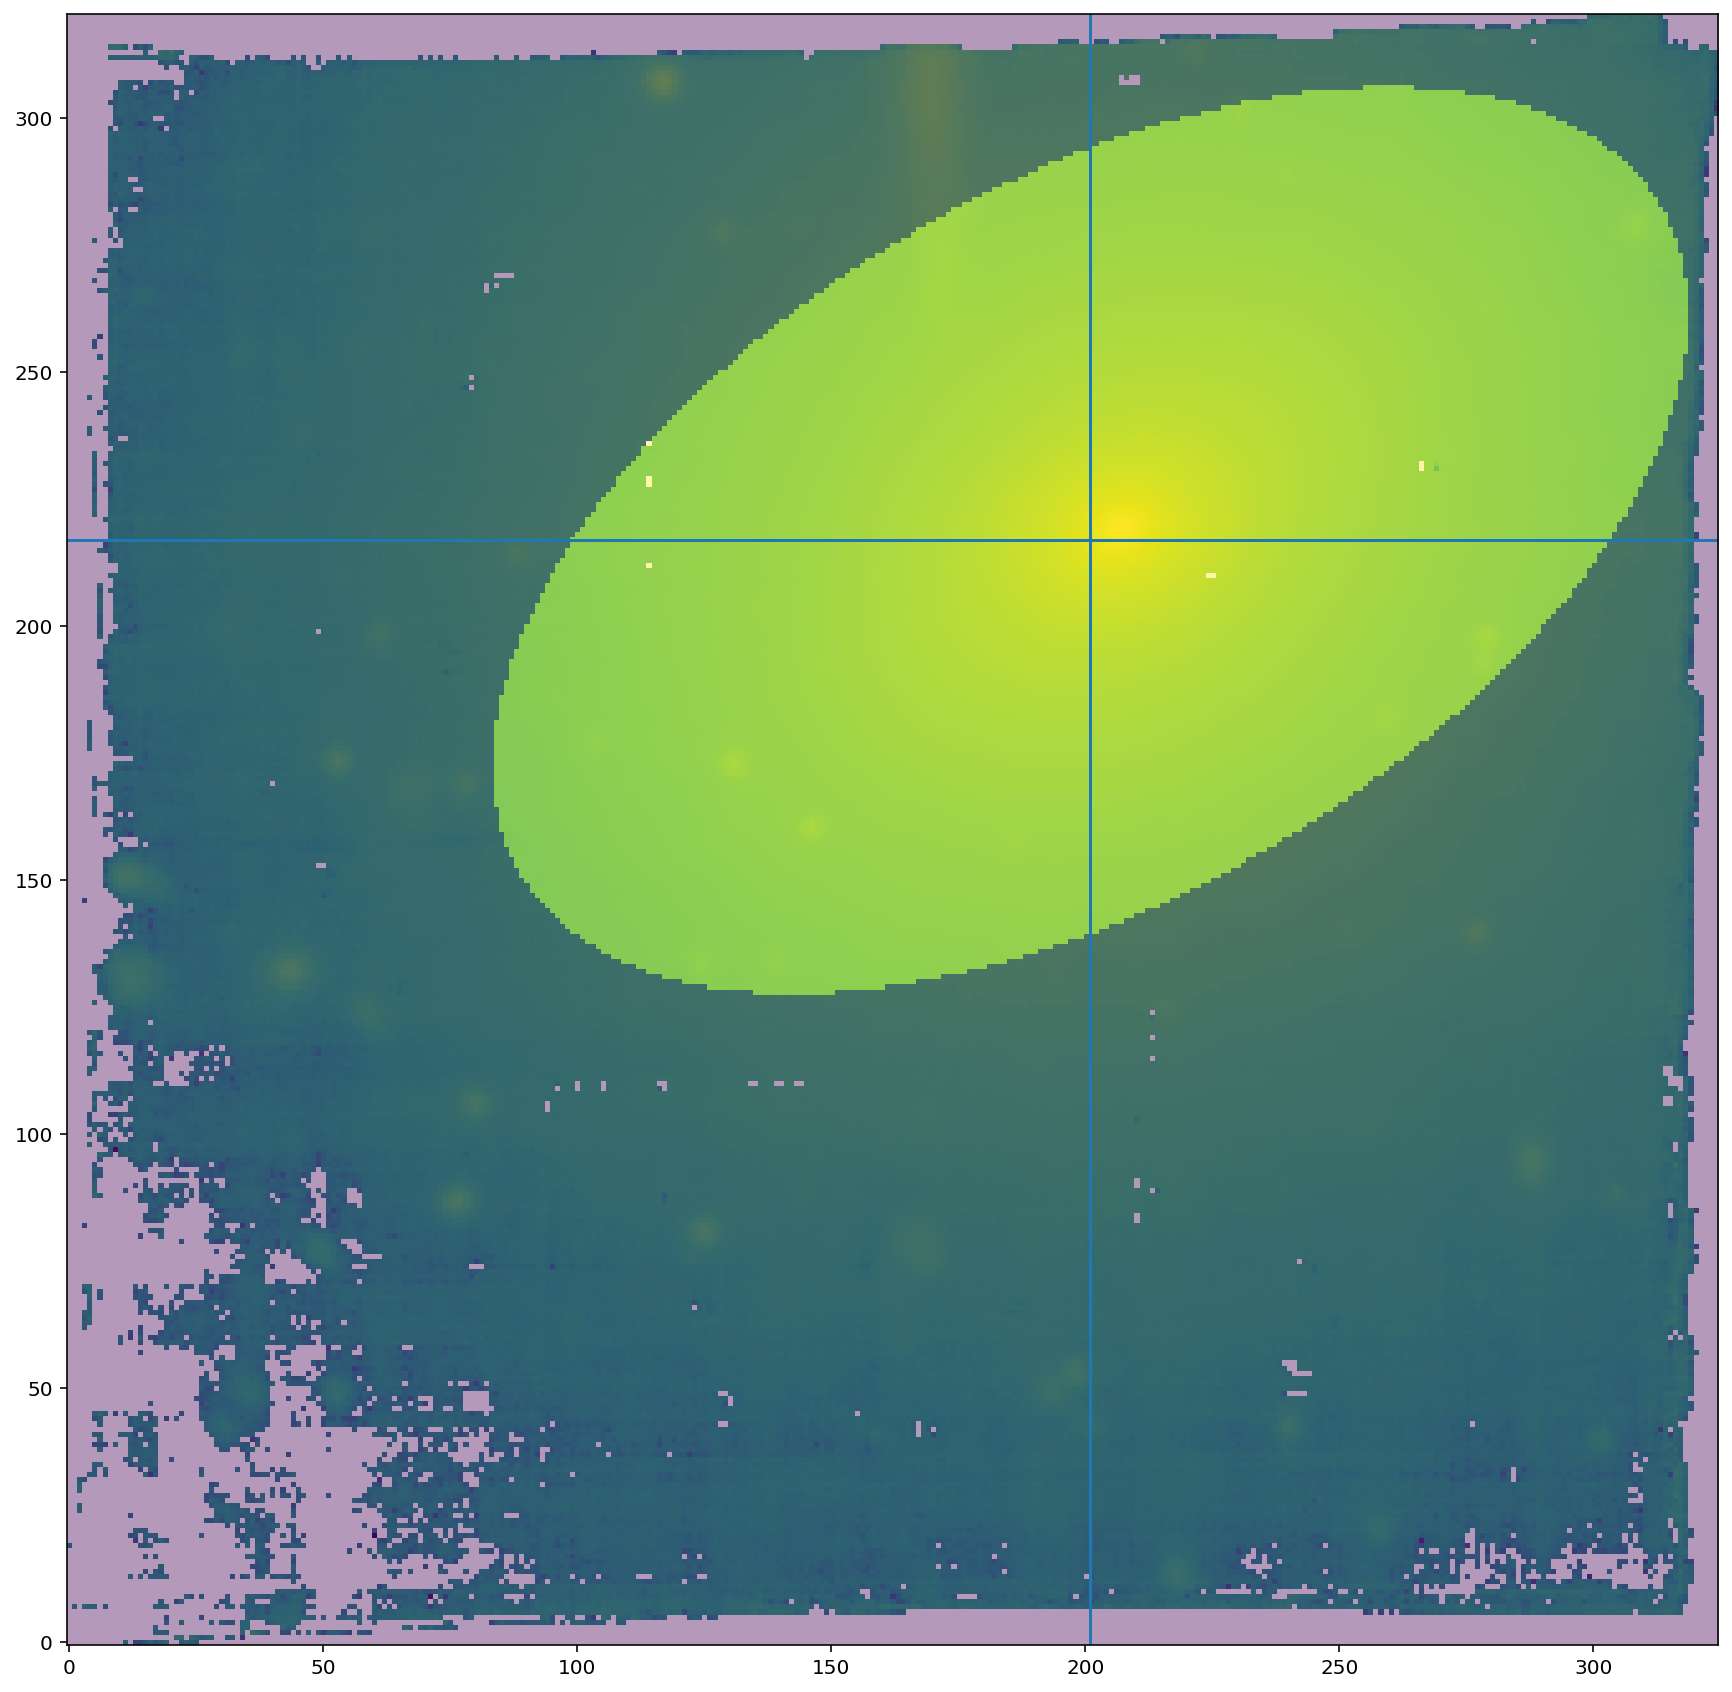

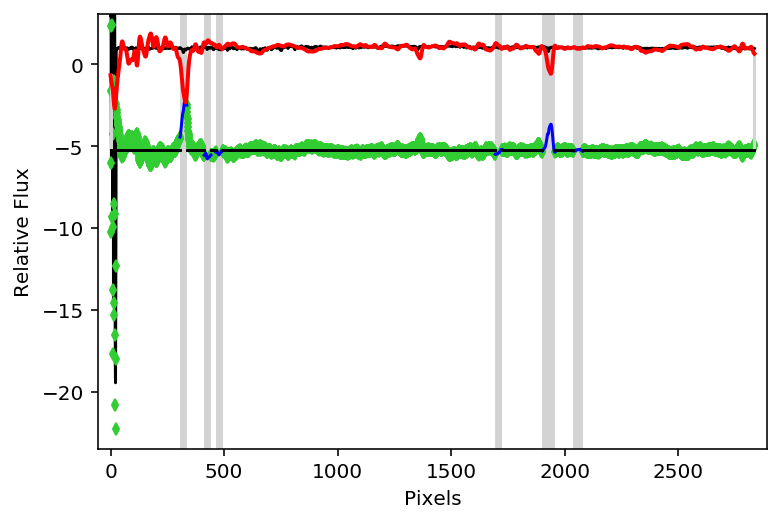

In [59]:
## LBOL for FCC255 anf FCC143

galaxy_name = "FCC143"
hdu = fits.open(f"/local/tspriggs/Fornax_data_cubes/{galaxy_name}center.fits")
s = np.shape(hdu[1].data)
plt.figure(figsize=(15,15))
flat_cube = np.nansum(hdu[1].data, 0)
# plt.imshow(np.log10(flat_cube), origin="lower", vmin=2, vmax=6)
gal_centre_pix = Table.read("exported_data/galaxy_centre_pix.dat", format="ascii")
gal_indx = np.argwhere(gal_centre_pix["Galaxy"] == galaxy_name)
gal_x = gal_centre_pix[gal_indx]["x_pix"]# 1 for FCC143
gal_y = gal_centre_pix[gal_indx]["y_pix"]

plt.axhline(gal_y)
plt.axvline(gal_x)

Y, X = np.mgrid[:s[1], :s[2]]
# xe, ye, length, width, alpha = [gal_x, gal_y, 400, 200, -0.1] # FCC255
xe, ye, length, width, alpha = [gal_x, gal_y, 260, 140, 2.1] #FCC143 

elip_mask = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1 


star_mask_params = [[1,1,1]]
star_mask_sum = np.sum([(Y - yc)**2 + (X - xc)**2 <= rc**2 for xc,yc,rc in star_mask_params],0).astype(bool)
    
    
total_mask = ((np.isnan(hdu[1].data[1,:,:])==False) & (elip_mask==True) & (star_mask_sum==False))
indx_mask = np.where(total_mask==True)

plt.imshow(np.log10(flat_cube), origin="lower")
plt.imshow(total_mask,origin="lower", alpha=0.4)




#sum_mask = (np.isnan(hdu[1].data[1,:,:])==False) & (elip_mask==True)
# plt.imshow(sum_mask, origin="lower", alpha=0.5)

#indx_mask = np.where(sum_mask==True)


plt.figure()

raw_data_cube = np.copy(hdu[1].data)
h1 = hdu[1].header
good_spectra = np.zeros((s[0], len(indx_mask[0])))

for i, (y, x)  in enumerate(zip(tqdm(indx_mask[0]), indx_mask[1])):
    good_spectra[:,i] = raw_data_cube[:,y,x]

print("Collapsing cube now....")    
    
gal_lin = np.nansum(good_spectra, 1)
        
print("Cube has been collapsed...")
# dM = 31.718  #FCC255
dM = 31.22 #FCC143 

c = 299792458.0 
# gal_vel = 1379 #FCC143
# gal_vel =  #FCC255
z = gal_vel*1e3 / c

L_bol = ppxf_L_tot(int_spec=gal_lin, header=h1, redshift=z, vel=gal_vel, dist_mod=dM, dM_err=[0.24, 0.24])#dM_err=[dM_err_up, dM_err_lo])

print(L_bol)

Text(0.5, 0, 'Fornax Galaxy Name')

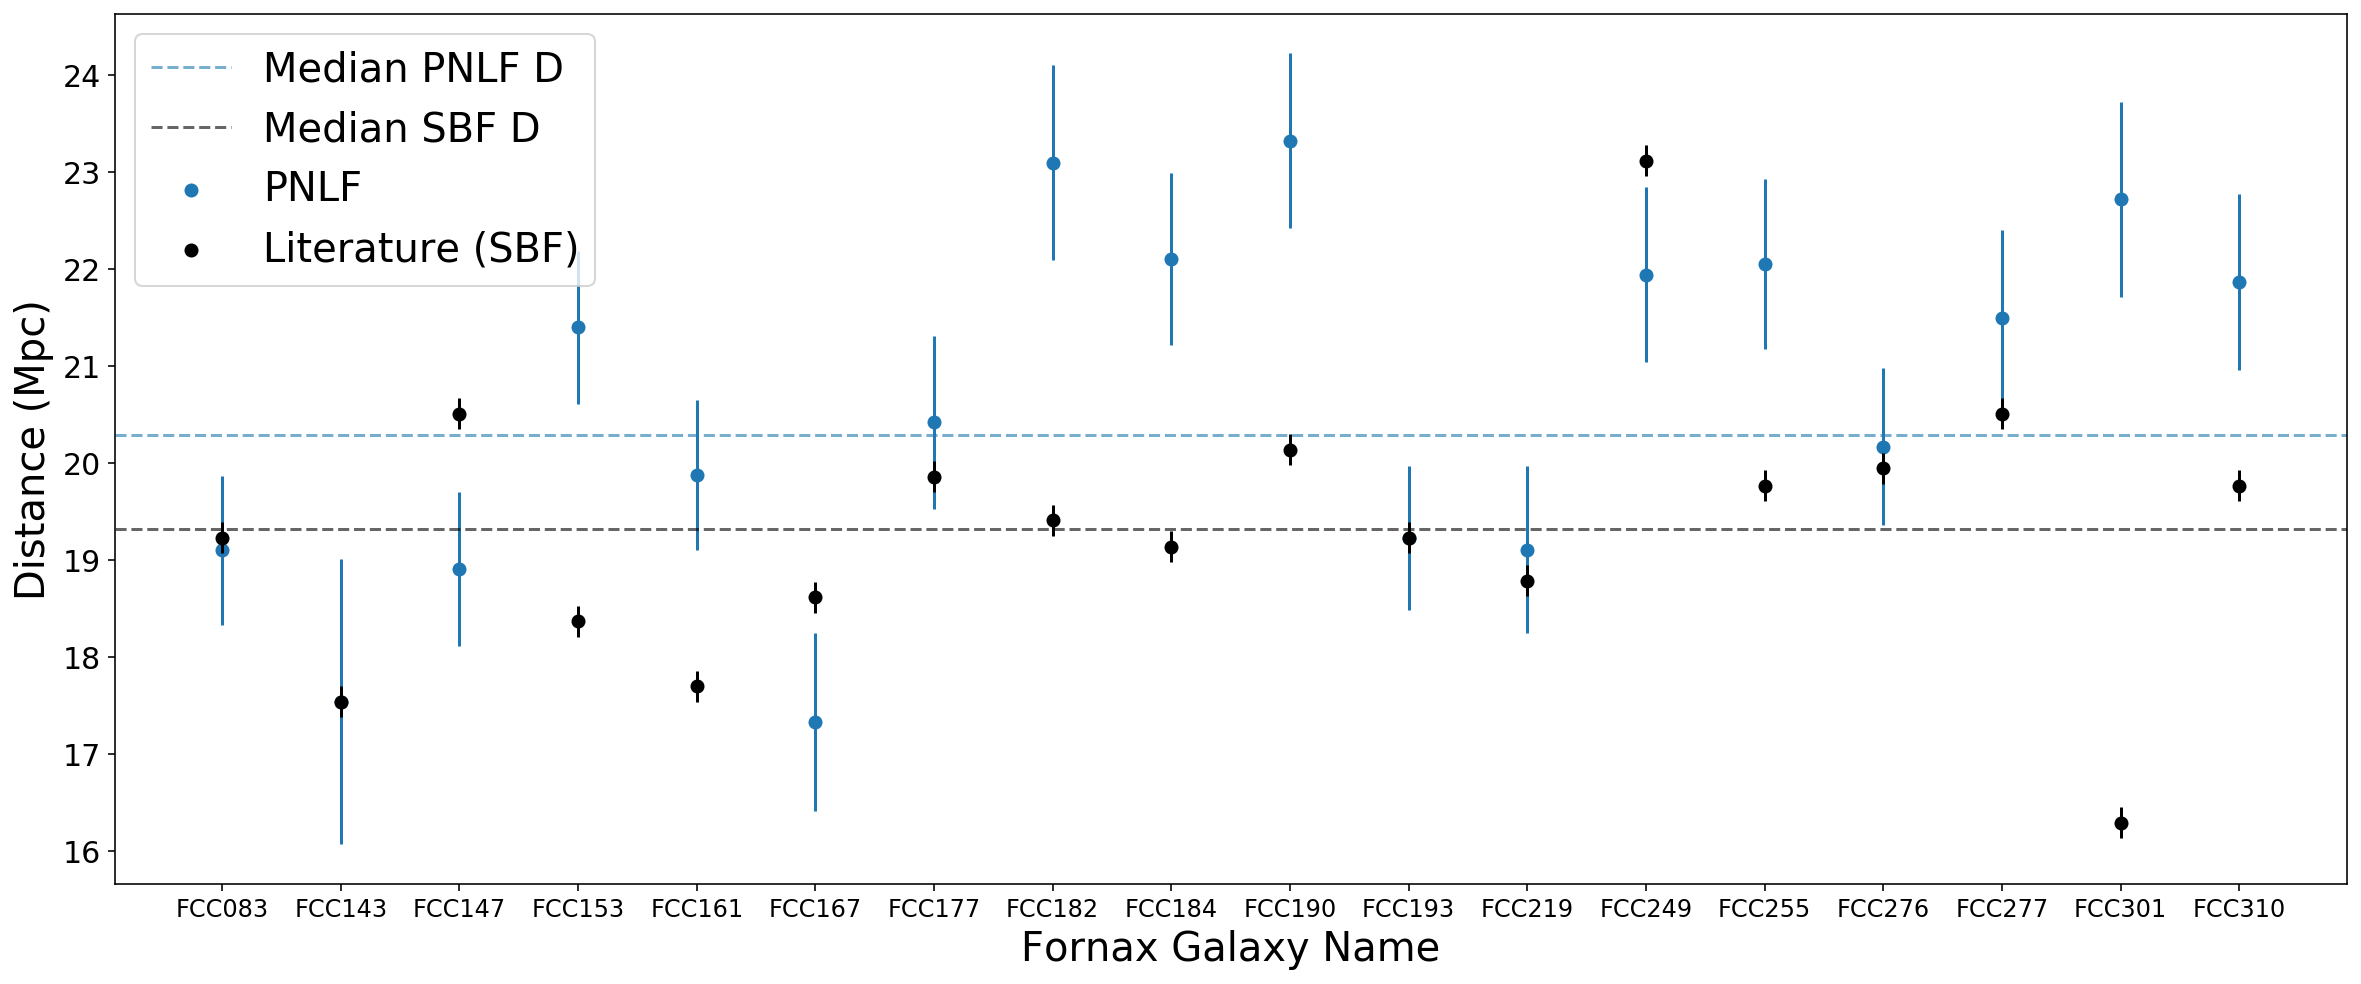

In [17]:
plt.figure(figsize=(20,8))
plt.scatter(galaxy_df["Galaxy"], galaxy_df["D PNLF"], label="PNLF", zorder=0)
plt.scatter(galaxy_df["Galaxy"], galaxy_df["lit D"], label="Literature (SBF)", c="k")
plt.errorbar(galaxy_df["Galaxy"], galaxy_df["D PNLF"], yerr=galaxy_df["D PNLF err"], ls="None", zorder=1)
plt.errorbar(galaxy_df["Galaxy"], galaxy_df["lit D"], yerr=0.16, ls="None", c="k")
plt.axhline(galaxy_df["D PNLF"].loc[galaxy_df["PNe N"]>20].median(), ls="--", alpha=0.6, label="Median PNLF D")
plt.axhline(galaxy_df["lit D"].median(), c="k", ls="--", alpha=0.6, label="Median SBF D")
plt.legend(loc="upper left", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.ylabel("Distance (Mpc)", fontsize=20)
plt.xlabel("Fornax Galaxy Name", fontsize=20)
# plt.savefig("Plots/Distance_comp_lit.png", bbox_inches='tight')

Text(0.5, 0, 'Fornax Galaxy Name')

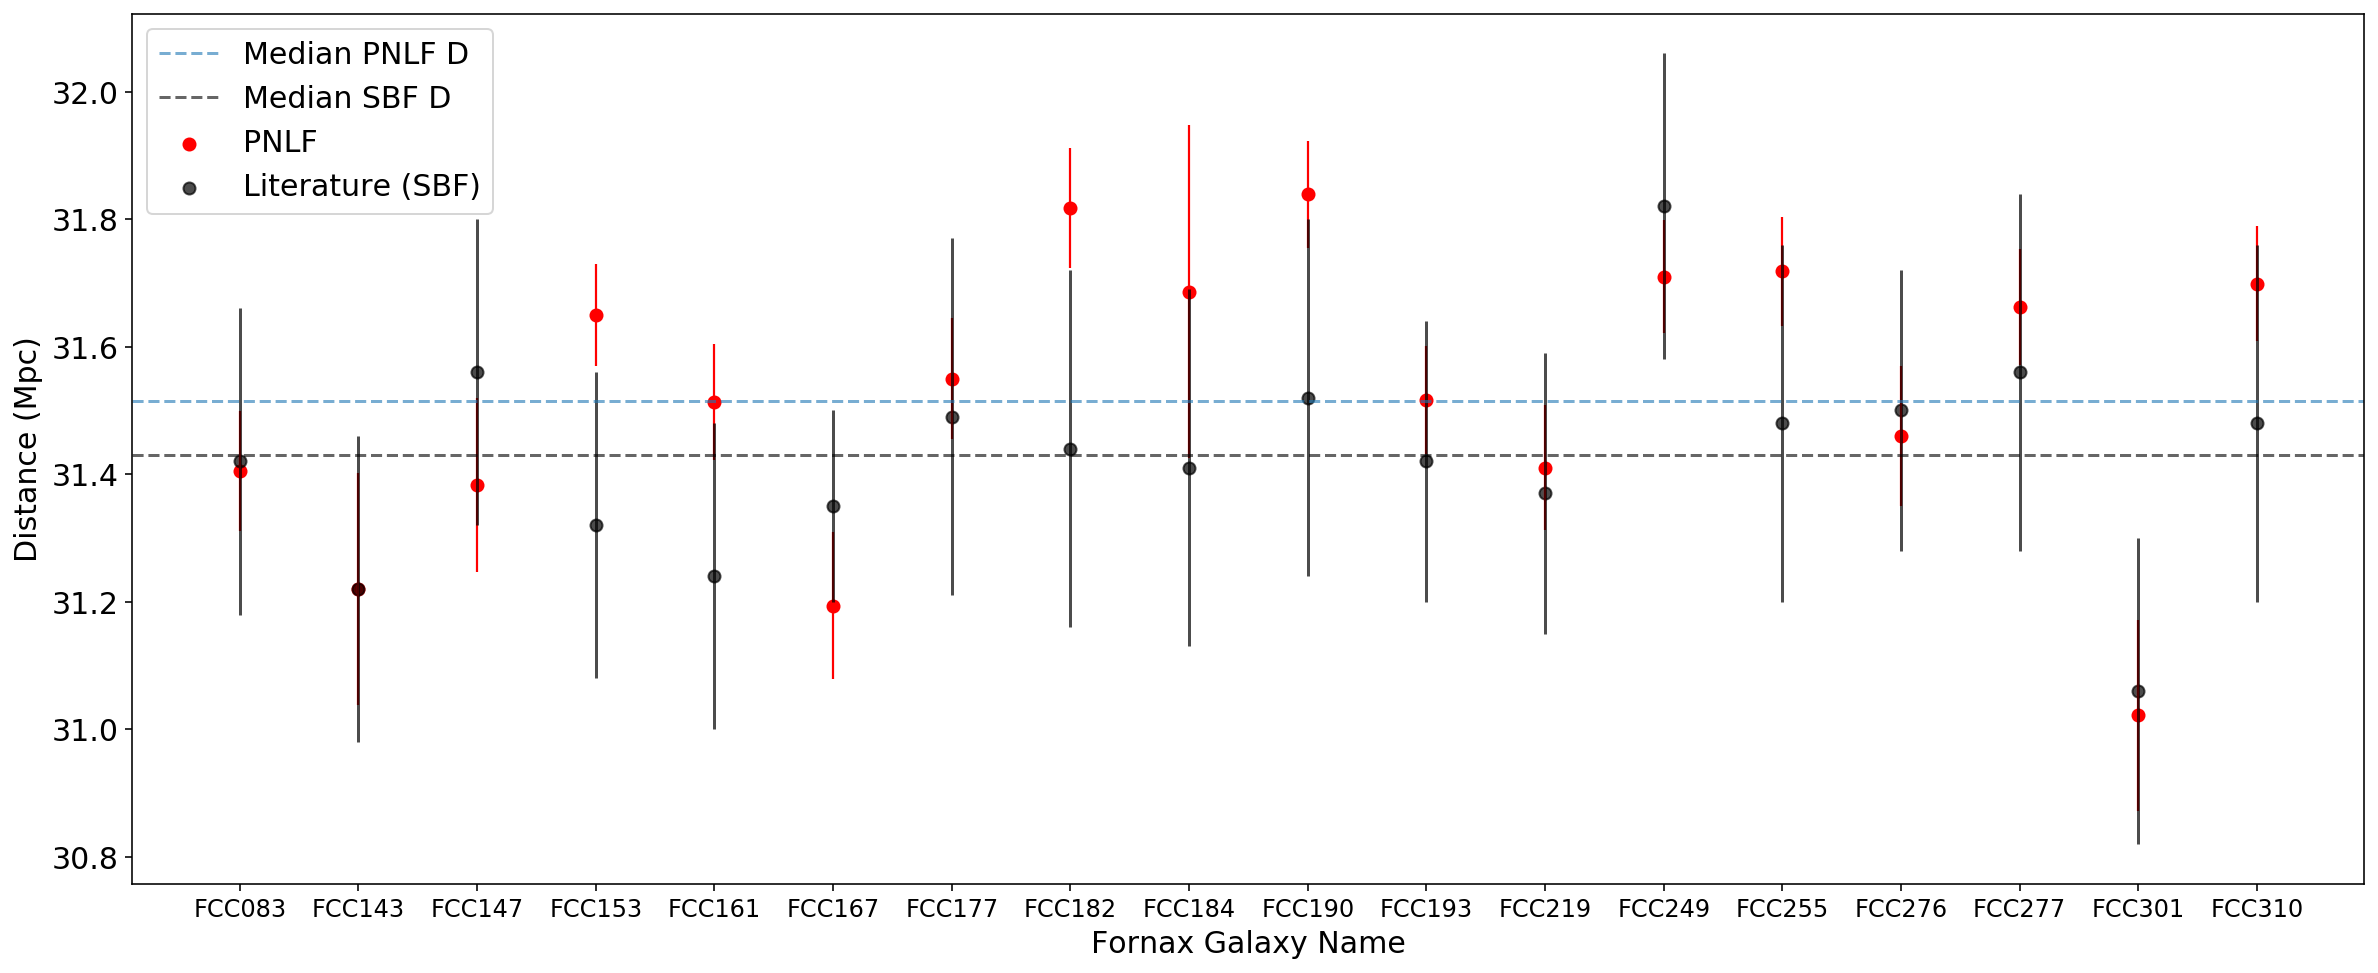

In [40]:
plt.figure(figsize=(20,8))
plt.scatter(galaxy_df["Galaxy"], galaxy_df["dM PNLF"], label="PNLF", c="r")
plt.scatter(galaxy_df["Galaxy"], galaxy_df["lit dM"], label="Literature (SBF)", c="k", alpha=0.7)

plt.errorbar(galaxy_df["Galaxy"], galaxy_df["dM PNLF"], yerr=galaxy_df["dM PNLF err"], ls="None", c="r" ,lw=1.1)
plt.errorbar(galaxy_df["Galaxy"], galaxy_df["lit dM"], yerr=galaxy_df["lit dM err"], ls="None", c="k", alpha=0.7)

plt.axhline(galaxy_df["dM PNLF"].loc[galaxy_df["PNe N"]>20].median(), ls="--", alpha=0.6, label="Median PNLF D")
plt.axhline(galaxy_df["lit dM"].median(), c="k", ls="--", alpha=0.6, label="Median SBF D")

plt.legend(loc="upper left", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.ylabel("Distance (Mpc)", fontsize=15)
plt.xlabel("Fornax Galaxy Name", fontsize=15)
# plt.savefig("Plots/Distance_comp_lit.png", bbox_inches='tight')

## Find and set centres for each pointing

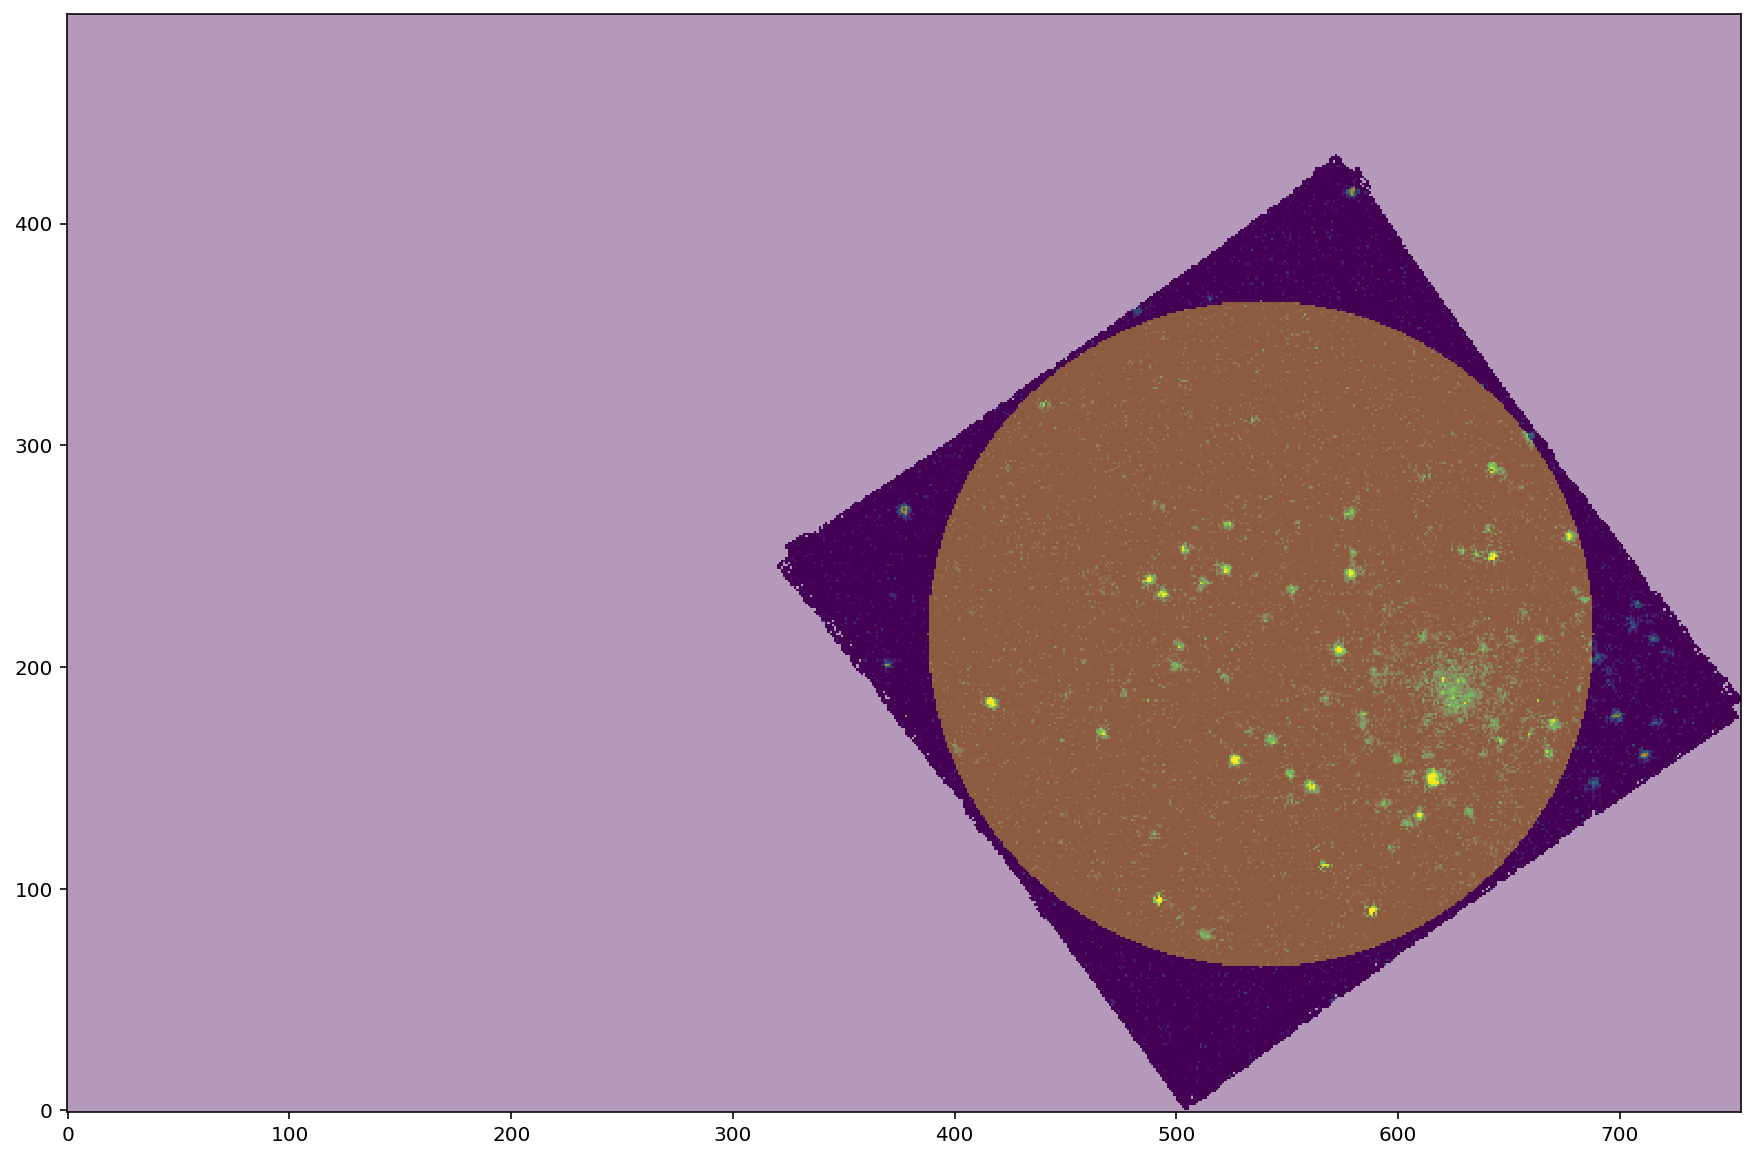

In [78]:
galaxy_name = "FCC276"


RAW_DIR = "/local/tspriggs/Fornax_data_cubes/"+galaxy_name
DATA_DIR = "galaxy_data/"+galaxy_name+"_data/"
EXPORT_DIR = "exported_data/"+galaxy_name+"/"
PLOT_DIR = "Plots/"+galaxy_name+"/"+galaxy_name
    
raw_data_cube = RAW_DIR+"center.fits" # read in raw data cube

orig_hdulist = fits.open(raw_data_cube)
h1 = orig_hdulist[1].header

A_rN_plot = np.load(EXPORT_DIR+galaxy_name+"_A_rN_cen.npy")
hdulist = fits.open(DATA_DIR+galaxy_name+"_residuals_list.fits")
hdr = hdulist[0].header
    
x_data = hdr["XAXIS"]
y_data = hdr["YAXIS"]
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)
s = np.shape(A_rN_plot_shape)


n_pixels = 9    # minicube FOV in pixels
c = 299792458.0 # speed of light



# OPEN 2D maps of A/rN


# OPEN yaml file
with open("galaxy_info.yaml", "r") as yaml_data:
    galaxy_info = yaml.load(yaml_data, Loader=yaml.FullLoader)
    
galaxy_data = galaxy_info[galaxy_name]

gal_vel = galaxy_data["velocity"]
MUSE_centre_xy = galaxy_data["centre"]



Y, X = np.mgrid[:s[0], :s[1]]


plt.figure(figsize=(15,15))
plt.imshow(A_rN_plot_shape, origin="lower", vmin=2, vmax=8)


RA = h1["CRVAL1"]
DEC = h1["CRVAL2"]

wcs = WCS(h1,naxis=2)
MUSE_cen = utils.skycoord_to_pixel(SkyCoord(ra=Angle(RA, u.deg), dec=Angle(DEC, u.deg), frame="fk5"), wcs)

# MUSE_x = h1["CRPIX1"]
# MUSE_y = h1["CRPIX2"]
MUSE_x = 538
MUSE_y = 215
sum_within_circ =  (Y - MUSE_y)**2 + (X - MUSE_x)**2 <= 150**2
plt.imshow(sum_within_circ, origin="lower", alpha=0.4)

# Completeness testing

In [13]:
def open_data(choose_galaxy, loc):
    # Load in the residual data, in list form
    DATA_DIR = "galaxy_data/"+choose_galaxy+"_data/"

    hdulist = fits.open(DATA_DIR+choose_galaxy+loc+"_residuals_list.fits") # Path to data
    res_hdr = hdulist[0].header # extract header from residual cube
    
    x_data = res_hdr["XAXIS"]
    y_data = res_hdr["YAXIS"]
    
    wavelength = np.exp(hdulist[1].data)

    return x_data, y_data, hdulist, wavelength

def reconstructed_image(choose_galaxy, loc):
    CUBE_DIR = "/local/tspriggs/Fornax_data_cubes/"
    hdu  = fits.open(CUBE_DIR+choose_galaxy+loc+'.fits')
    data = hdu[1].data
    hdr  = hdu[1].header
    s    = np.shape(data)
    wave = hdr['CRVAL3']+(np.arange(s[0])-hdr['CRPIX3'])*hdr['CD3_3']

    cond = (wave >= 4900.0) & (wave <= 5100.0)
    data = np.sum(data[cond,:,:],axis=0)

    return data, wave


def moffat(amplitude, x_0, y_0, FWHM, beta):
    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((x_fit - x_0)**2 + (y_fit - y_0)**2) / gamma**2
    return amplitude * (1 + rr_gg)**(-beta)

def gaussian(x, amplitude, mean, stddev, bkg, grad, z):
    return (bkg + grad*x + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
                 (np.abs(amplitude)/3.) * np.exp(- 0.5 * (x - (mean - 47.9399*(1+z)))** 2 / (stddev**2.)))


# extract PSF values via yaml
galaxy_name = "FCC219"
loc = "center"

peak = 2.5

with open("galaxy_info.yaml", "r") as yaml_data:
    galaxy_info = yaml.load(yaml_data, Loader=yaml.FullLoader)
    
galaxy_data = galaxy_info[f"{galaxy_name}_{loc}"]

# Construct the PNe FOV coordinate grid for use when fitting PNe.
n_pixels = 9
coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]
x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])


image, wave = reconstructed_image(galaxy_name, loc)

x_data, y_data, hdulist, wavelength = open_data(galaxy_name, loc)

image = image.reshape([y_data, x_data])

# Get the residual noise of the galaxy image
rN = np.array([robust_sigma(hdulist[0].data[i]) for i in range(len(hdulist[0].data))])

Noise_map  = rN.reshape(y_data, x_data)

# mask out regions where sep masks

xe, ye, length, width, alpha = gal_mask_params

Y, X = np.mgrid[:y_data, :x_data]
elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1

star_mask_sum = np.sum([(Y - yc)**2 + (X - xc)**2 <= rc**2 for xc,yc,rc in star_mask_params],0).astype(bool)

mask_indx = np.array(np.where((elip_mask_gal+star_mask_sum)==True))

Noise_map[mask_indx[0], mask_indx[1]] = 0.0 #np.nan
image[mask_indx[0], mask_indx[1]] = 0.0 # np.nan
image[image<0] = 0

# Setup range of Absolute Magnitudes to be converted to 1D max A values

app_m = np.arange(26.6,30.0, 0.2) #bins_cens

total_flux = 10**((app_m + 13.74) / -2.5) # Ciardullo's flux calibration

flux = total_flux*1.0e20

init_FWHM = galaxy_data["FWHM"]
init_beta = galaxy_data['beta']

sum_init     = np.sum(moffat(1., n_pixels/2., n_pixels/2., init_FWHM, init_beta))
input_moff_A = flux / sum_init

# Make moffat models = F_5007 (x,y)
Moffat_models = np.array([moffat(moff_A, n_pixels/2., n_pixels/2., init_FWHM, init_beta) for moff_A in input_moff_A])

# A_5007 (x,y)
G_std = galaxy_data["LSF"] / 2.35482
Amp_x_y = ((Moffat_models) / (np.sqrt(2*np.pi) * G_std))
max_1D_A = np.array([np.max(A) for A in Amp_x_y])

N_data = len(np.nonzero(Noise_map)[0])

Noise_mask = Noise_map
ratio_counter = np.zeros(len(app_m)).astype(np.float128)

m_5007_detlim = -2.5*np.log10(total_flux) - 13.74

zeros = []
for i,a in enumerate(max_1D_A):
    ratio_counter[i] = (np.nansum(image[((a / Noise_mask) > peak)])/np.nansum(image)).astype(np.float128)

/local/tspriggs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in less
/local/tspriggs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in true_divide
/local/tspriggs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in greater


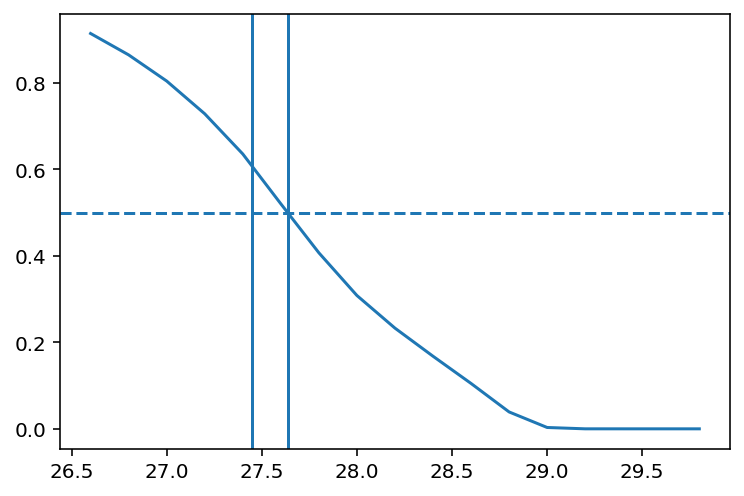

In [17]:
plt.plot(m_5007_detlim, ratio_counter)
plt.axhline(0.5, ls="--")
plt.axvline(27.45) #peak=3.0
plt.axvline(27.64) #peak=2.5

## Literature comparison

### FCC167

In [10]:
c = ascii.read("galaxy_data/FCC167_data/NGC1380_PNe_from_paper.txt", data_start=1)
lit_RA = list(c["RA"])
lit_Dec = list(c["Dec"])
lit_m = np.array(c["mag"])

x_y_lit = np.ones((len(x_PNe),2))
for i in np.arange(0, len(lit_RA)):
    x_y_lit[i] = utils.skycoord_to_pixel(SkyCoord(ra=Angle(lit_RA[i], u.hourangle), dec=Angle(lit_Dec[i], u.deg), frame="fk5"), wcs_obj)

smallest_sep = []
for r,d in zip(lit_RA, lit_Dec):
    sepa = []
    for r1,d1 in zip(PNe_df["Ra (J2000)"], PNe_df["Dec (J2000)"]):
        c1 = SkyCoord(Angle(r, u.hourangle), Angle(d, u.deg), frame="fk5")
        c2 = SkyCoord(Angle(r1, u.hourangle), Angle(d1, u.deg), frame="fk5")
        sepa.append(c1.separation(c2).degree)
    smallest_sep.append(sepa)
    
diff = np.array([np.min(smallest_sep[i]) for i in range(0, len(smallest_sep))])
potential_diff = diff[diff<0.001]
print(np.where(diff<0.001))

lit_index = np.squeeze(np.where(diff<0.001))

indx = np.array(([np.squeeze(np.where(smallest_sep[i] == np.min(smallest_sep[i]))) for i in range(0, len(smallest_sep))]))
#print(indx[[0,2,6,20]])
#print(lit_m[[0,2,6,20]])
PNe_df.loc[indx[np.where(diff<0.001)]]
F3D_index = indx[np.where(diff<0.001)]

matched_lit_m =lit_m[lit_index]
matched_F3D_m = PNe_df["m 5007"].loc[indx[np.where(diff<0.001)]]

# matched_F3D_m = PNe_df["m 5007"].loc[[138, 115, 82, 107]]

(array([ 0,  1,  2,  3,  7,  8, 12, 13, 16, 18, 19, 25, 28, 29, 32, 33, 36,
       37, 40]),)


In [20]:
print(indx[np.where(diff<0.001)])

[ 7 13  0 45  8 21  4 37 25 12 23 35 46 38 34 36 43 27 40]


Center PNe m5007
[26.585 26.725 26.809 27.203]
138    27.146558
115    26.883971
82     27.193419
107    27.573474
Name: m 5007, dtype: float64


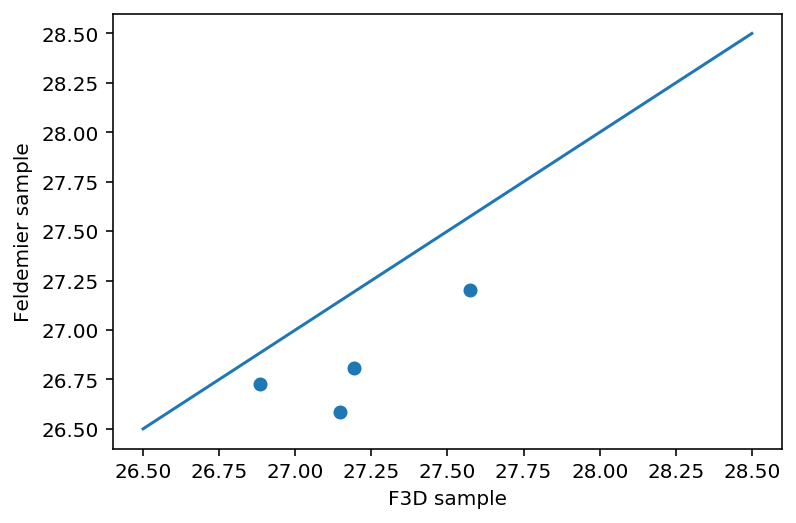

In [34]:
matched_lit_m =lit_m[lit_index]
matched_F3D_m = PNe_df["m 5007"].loc[[138, 115, 82, 107]] # center corrected list of indx

plt.scatter(matched_F3D_m, matched_lit_m)
plt.plot(np.arange(26.5,29), np.arange(26.5,29))
plt.xlabel("F3D sample")
plt.ylabel("Feldemier sample")

print("Center PNe m5007")
print(matched_lit_m)
print(matched_F3D_m)


Center PNe m5007
[26.718 26.77  26.821 26.952 27.079 27.079 27.107 27.188 27.201 27.321
 27.399 27.411 27.489 27.528 27.747 27.76  27.812]
13    27.574294
45    27.296383
8     27.438540
21    27.477897
4     27.868759
37    27.446263
25    27.561705
12    27.451270
23    27.629726
35    27.897316
46    27.784497
38    27.767381
34    27.985602
36    27.848569
43    28.111939
27    28.104020
40    28.629938
Name: m 5007, dtype: float64


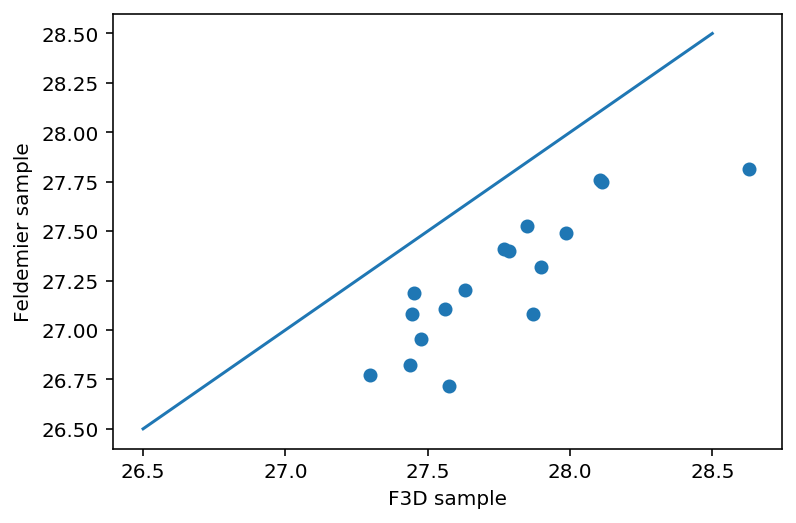

In [21]:
#halo
matched_lit_m =lit_m[[1, 3,  7,  8, 12, 13, 16, 18, 19, 25, 28, 29, 32, 33, 36, 37, 40]]
matched_F3D_m = PNe_df["m 5007"].loc[[13, 45 , 8 ,21 , 4 ,37 ,25 ,12, 23 ,35 ,46, 38, 34, 36 ,43 ,27, 40]] # center corrected list of indx

plt.scatter(matched_F3D_m, matched_lit_m)
plt.plot(np.arange(26.5,29), np.arange(26.5,29))
plt.xlabel("F3D sample")
plt.ylabel("Feldemier sample")

print("Center PNe m5007")
print(matched_lit_m)
print(matched_F3D_m)


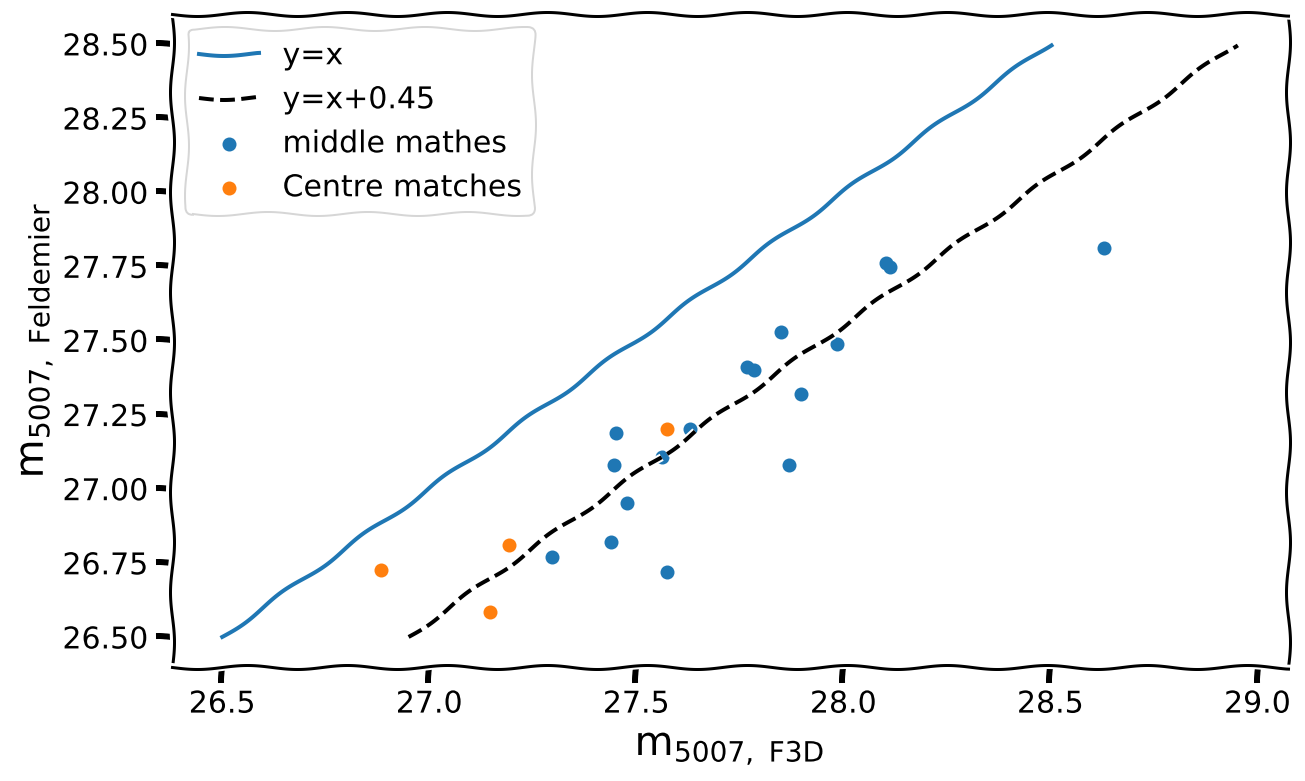

In [17]:
# plt.scatter(matched_F3D_m, matched_lit_m, label="middle matches")
mid_matched_lit_m = [26.718, 26.77,  26.821, 26.952, 27.079, 27.079, 27.107, 27.188, 27.201, 27.321, 27.399, 27.411, 27.489, 27.528, 27.747, 27.76,  27.812]
mid_matched_F3D_m = [ 27.574294, 27.296383, 27.438540, 27.477897, 27.868759, 27.446263, 27.561705, 27.451270, 27.629726, 27.897316, 27.784497, 27.767381, 
                      27.985602, 27.848569, 28.111939, 28.104020 ,28.629938]
with plt.xkcd(2, length=100, randomness=1):
    plt.figure(figsize=(10,6))
    plt.scatter(mid_matched_F3D_m, mid_matched_lit_m, label="middle mathes")
    plt.scatter([27.146, 26.884, 27.193, 27.573], [26.585, 26.725, 26.809, 27.203], label="Centre matches")
    plt.plot(np.arange(26.5,29), np.arange(26.5,29), label="y=x")
    plt.plot(np.arange(26.5,29)+0.45, np.arange(26.5,29), ls="--",c="k", label="y=x+0.45")
    plt.legend(fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel(r"$\rm m_{5007, \ F3D}$", fontsize=20)
    plt.ylabel(r"$\rm m_{5007, \ Feldemier}$", fontsize=20)
#     plt.savefig("Plots/FCC167/FCC167_lit_comparison.png", bbox_inches='tight')

Text(0, 0.5, 'Dec')

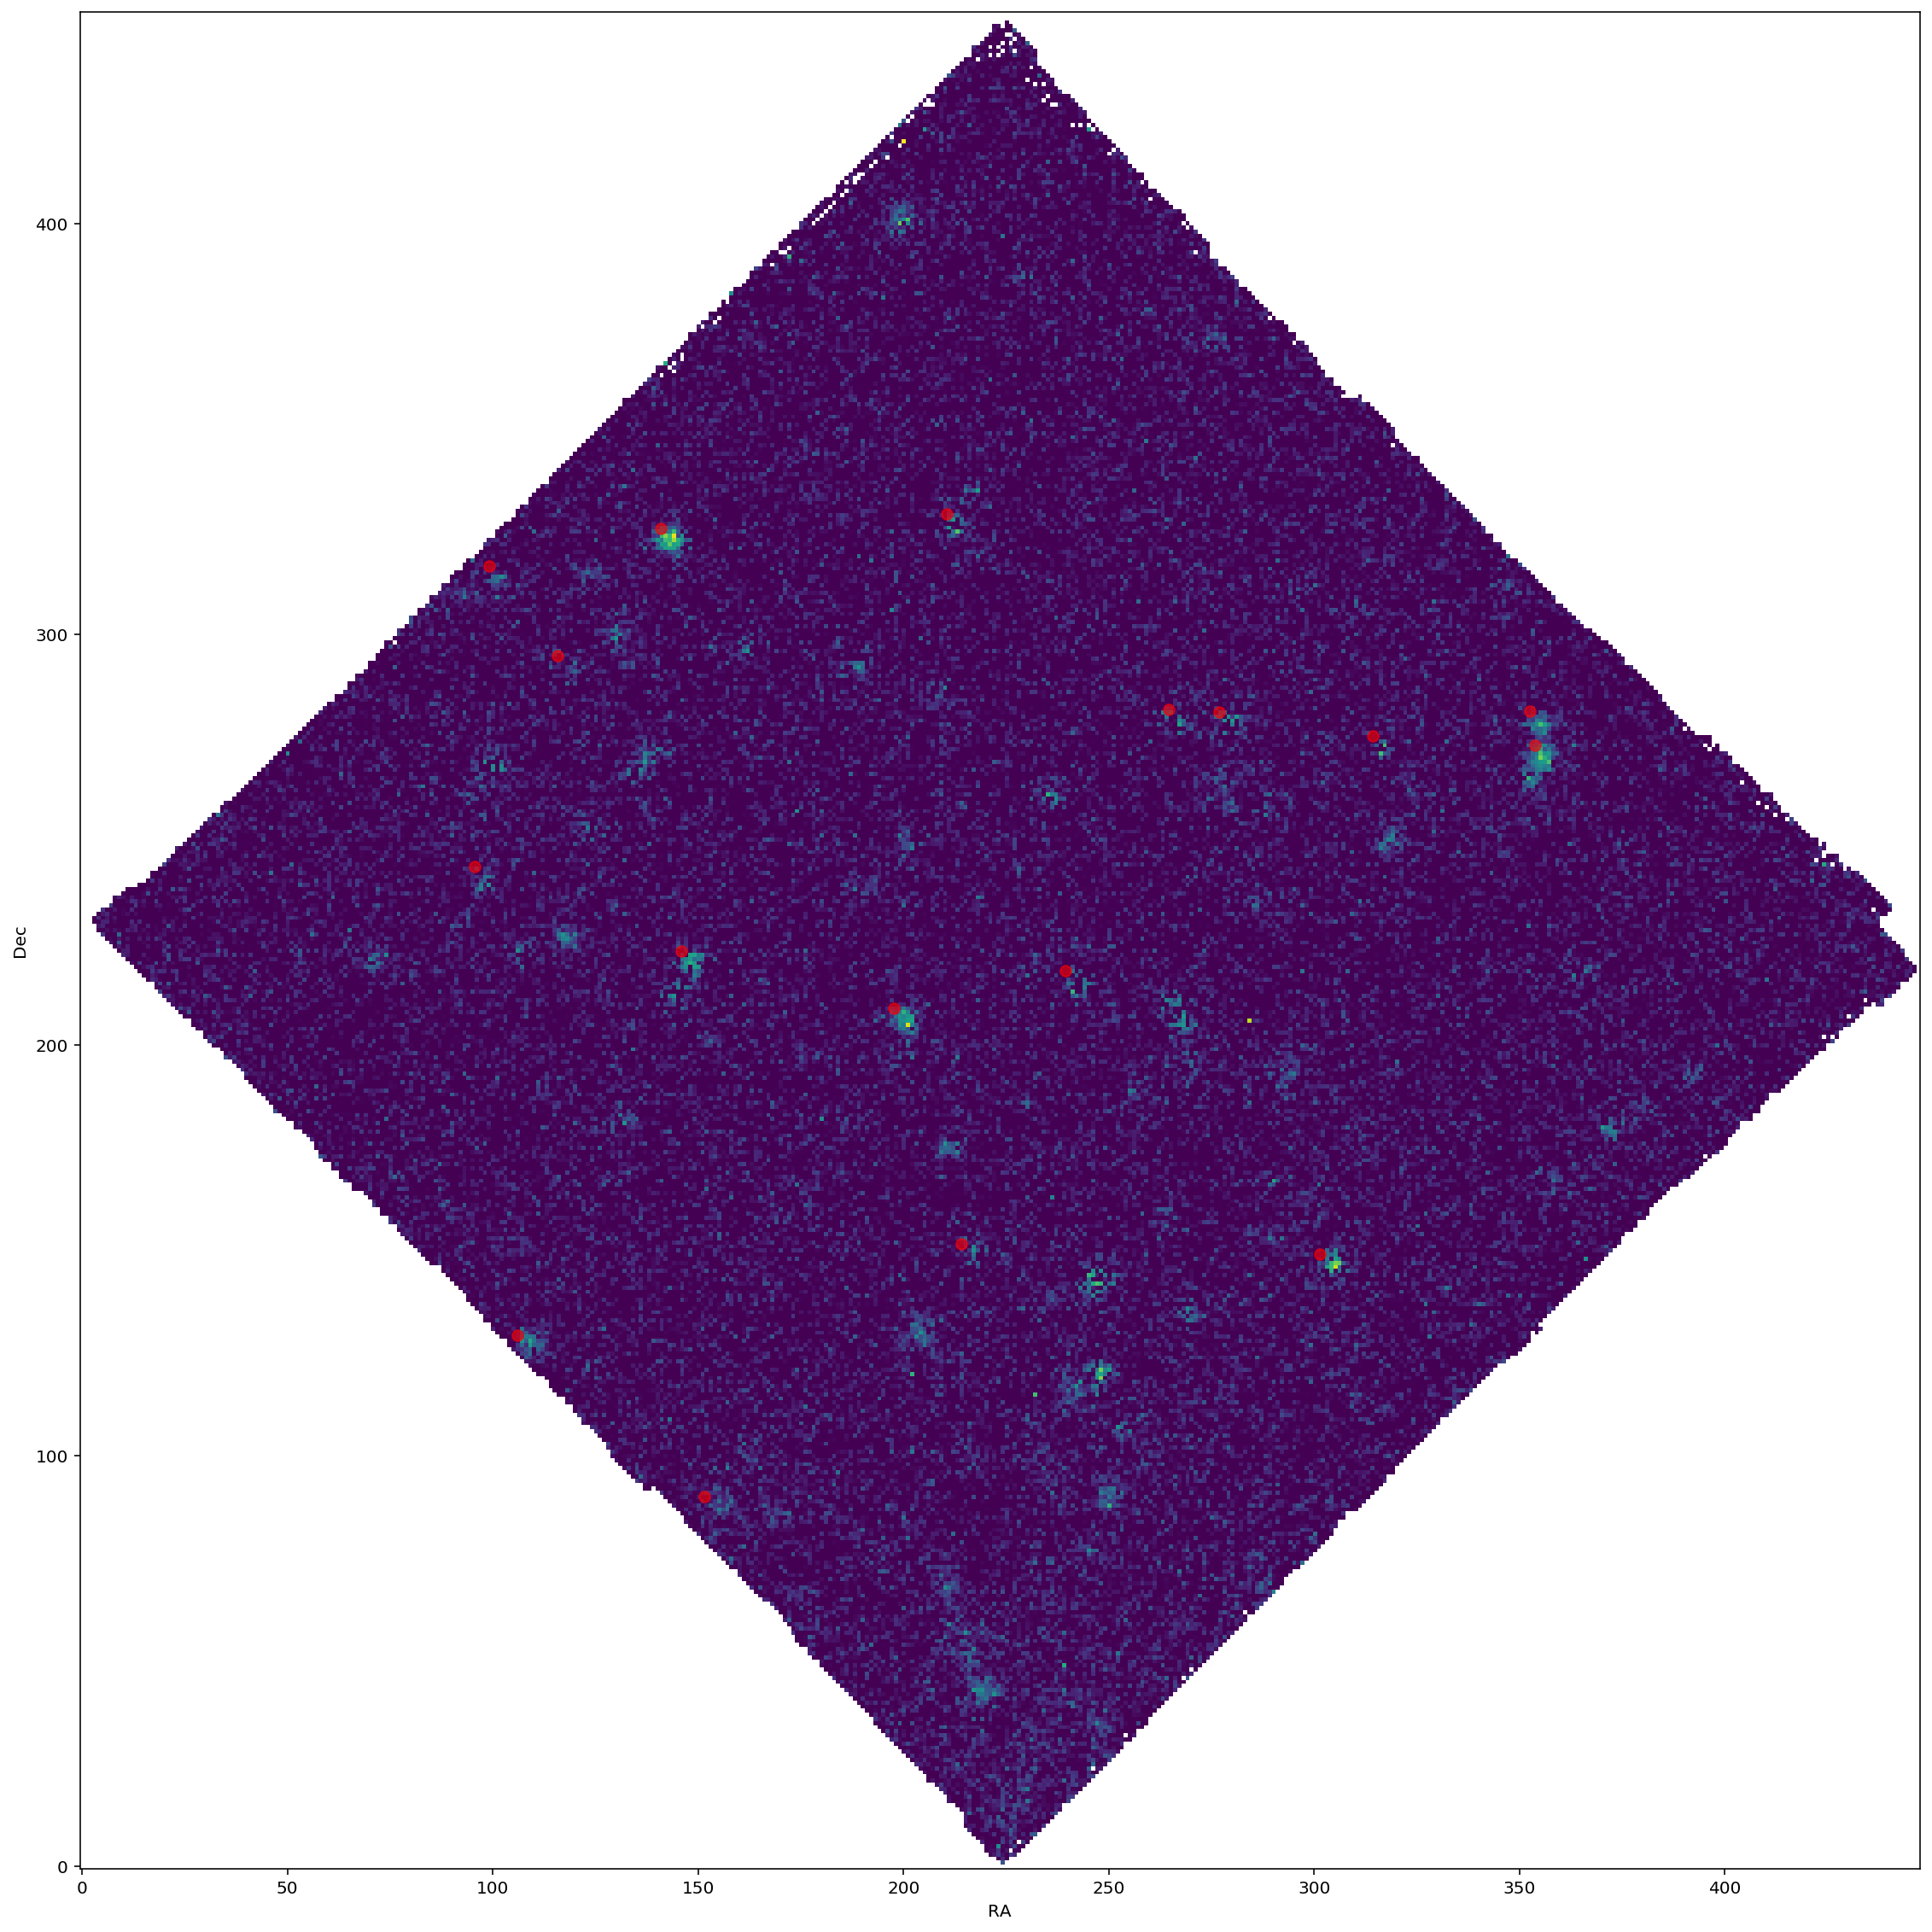

In [19]:
## Plot out the locations
#  1, 3,  7,  8, 12, 13, 16, 18, 19, 25, 28, 29, 32, 33, 36, 37, 40 halo PNe matches
# 0 and 2 are in the centre comparison set
fig = plt.figure(figsize=(20,20))
# fig.add_subplot(111, projection=wcs_obj)
plt.imshow(A_rN_plot_shape, origin='lower', cmap=plt.cm.viridis, vmin=1, vmax=8)
# plt.scatter([x_y_lit[i][0] for i in range(len(x_y_lit))], [x_y_lit[i][1] for i in range(len(x_y_lit))], color="r",s=40, alpha=0.6)
n= [1, 3,  7,  8, 12, 13, 16, 18, 19, 25, 28, 29, 32, 33, 36, 37, 40]
plt.scatter([x_y_lit[i][0] for i in n] , [x_y_lit[i][1] for i in n], color="r",s=40, alpha=0.6)
# 
# plt.xlim(0,450)
# plt.ylim(0,450)
plt.xlabel('RA')
plt.ylabel('Dec')

### FCC219

In [23]:
PNe_hdulist = fits.open("galaxy_data/FCC219_data/PNe1404.fit")
list_1404 = PNe_hdulist[1].data
list_1404 = list_1404[-47:]
RA_1404 =    [list_1404[i][7] for i in np.arange(0,len(list_1404))]
Dec_1404 =   [list_1404[i][8] for i in np.arange(0,len(list_1404))]
m5007_1404 = np.array([list_1404[i][4] for i in np.arange(0,len(list_1404))])

x_y_lit = np.ones((len(RA_1404),2))
for i in np.arange(0, len(list_1404)):
    x_y_lit[i] = utils.skycoord_to_pixel(SkyCoord(ra=Angle(RA_1404[i], u.hourangle), dec=Angle(Dec_1404[i], u.deg), frame="fk5"), wcs_obj)

smallest_sep = []
for r,d in zip(RA_1404, Dec_1404):
    sepa = []
    for r1,d1 in zip(PNe_df["Ra (J2000)"], PNe_df["Dec (J2000)"]):
        c1 = SkyCoord(Angle(r, u.hourangle), Angle(d, u.deg), frame="fk5")
        c2 = SkyCoord(Angle(r1, u.hourangle), Angle(d1, u.deg), frame="fk5")
        sepa.append(c1.separation(c2).degree)
    smallest_sep.append(sepa)
    


diff = np.array([np.min(smallest_sep[i]) for i in range(0, len(smallest_sep))])
potential_diff = diff[diff<0.001]

lit_index = np.squeeze(np.where(diff<0.001))

indx = np.array(([np.squeeze(np.where(smallest_sep[i] == np.min(smallest_sep[i]))) for i in range(0, len(smallest_sep))]))

F3D_index = indx[np.where(diff<0.001)]

matched_lit_m = m5007_1404[lit_index]
matched_F3D_m = PNe_df["m 5007"].loc[F3D_index]

print(lit_index)

[ 2  4  7 31 38 43]


In [13]:
matched_lit_m

array([27.53, 27.55, 27.7 ])

In [14]:
matched_F3D_m

14    27.642509
2     27.985619
17    27.739837
Name: m 5007, dtype: float64

Text(0, 0.5, 'Dec')

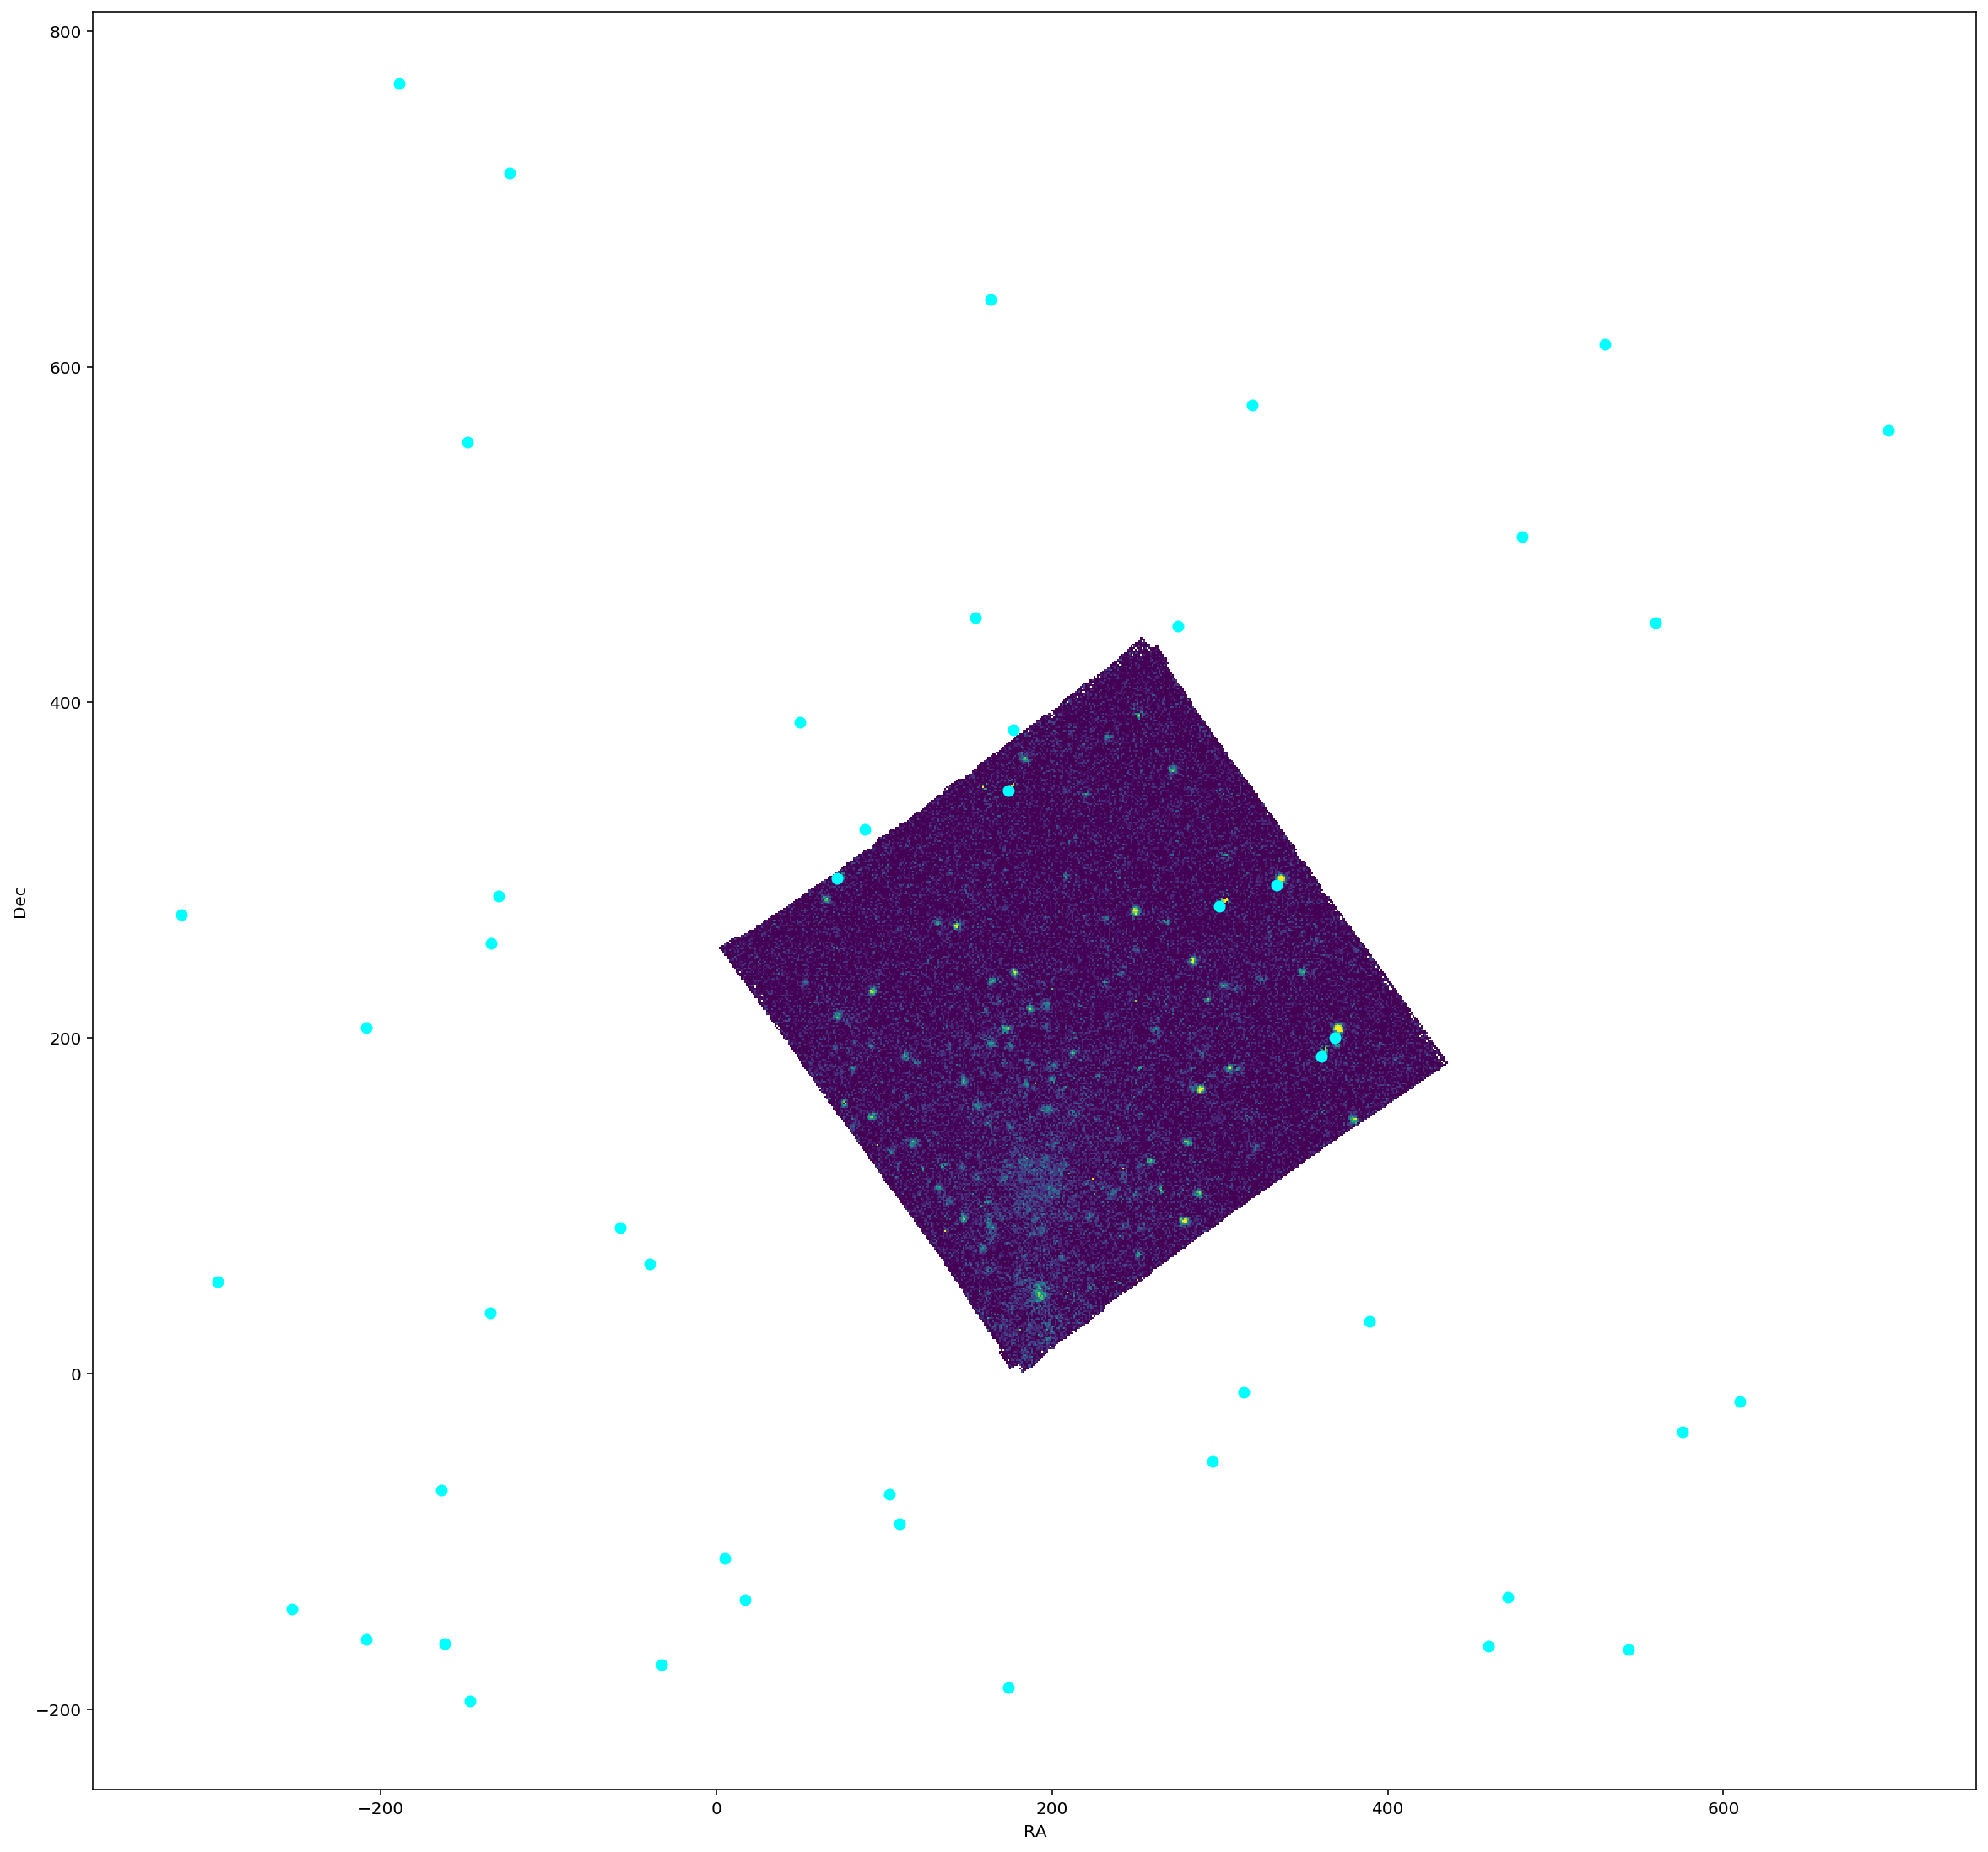

In [24]:
fig = plt.figure(figsize=(20,20))
# fig.add_subplot(111, projection=wcs_obj)
plt.imshow(A_rN_plot_shape, origin='lower', cmap=plt.cm.viridis, vmin=1, vmax=8)
plt.scatter([x_y_lit[i][0] for i in range(len(x_y_lit))], [x_y_lit[i][1] for i in range(len(x_y_lit))], color="cyan")
# n= [2,  4,  7, 31, 38, 43]
# plt.scatter([x_y_lit[i][0] for i in n] , [x_y_lit[i][1] for i in n], color="r",s=40, alpha=0.6)
# p = 43
# plt.scatter(x_y_lit[p][0], x_y_lit[p][1] , color="r",s=40, alpha=0.6)
# plt.xlim(0,500)
# plt.ylim(0,500)
plt.xlabel('RA')
plt.ylabel('Dec')

In [39]:
print("F3D: \n", matched_F3D_m)
print("lit: \n", matched_lit_m)

F3D: 
 14    27.642509
2     27.985619
17    27.739837
Name: m 5007, dtype: float64
lit: 
 [27.53 27.55 27.7 ]


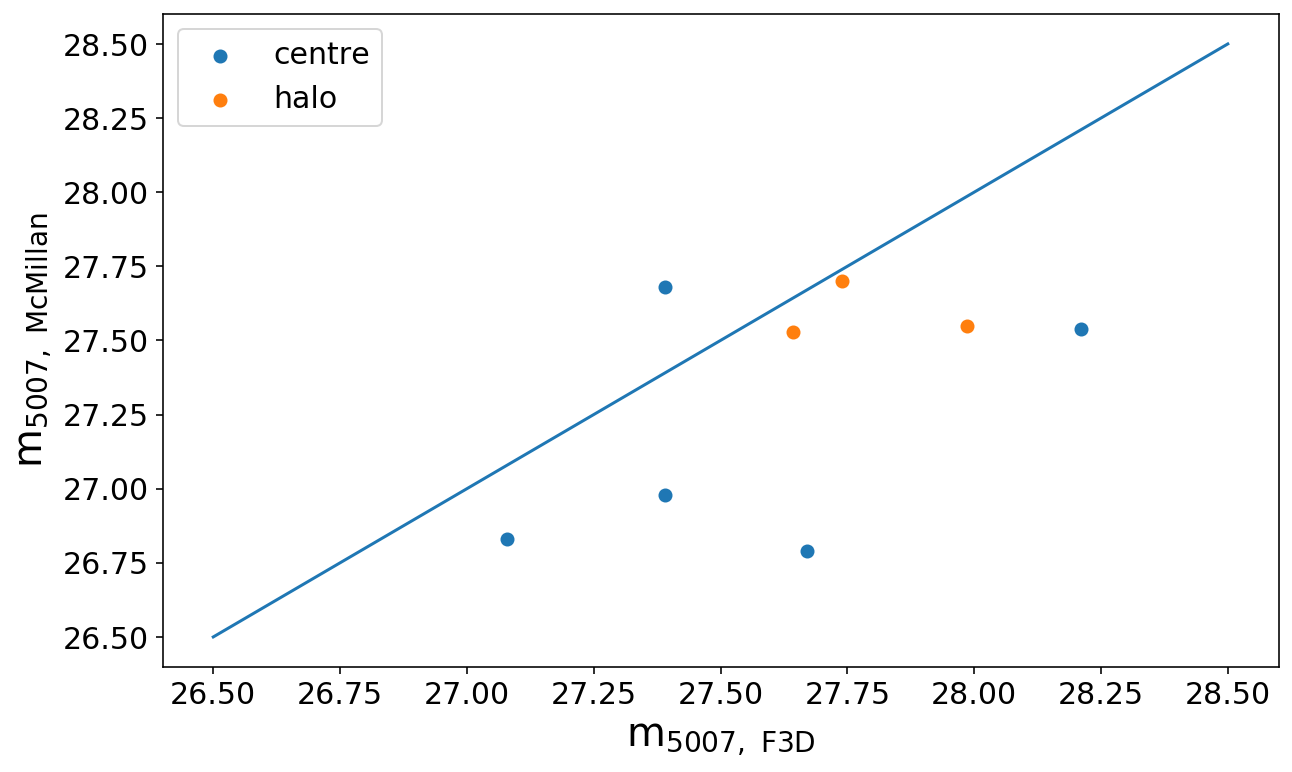

In [20]:
# matched_F3D_m = np.array(PNe_df["m 5007"].loc[[39,45,66,68,70]])
# matched_F3D_m.append()
# matched_lit_m = m5007_1404[[2 ,4 , 7, 31, 38, 43]]
# centre
plt.figure(figsize=(10,6))
centre_F3D = [27.67, 27.08, 27.39, 28.21, 27.39]
centre_lit = [26.79, 26.83, 26.98, 27.54, 27.68]

halo_lit   = [27.53, 27.55, 27.7 ]
halo_F3D   = [27.642509, 27.985619, 27.739837]
plt.scatter(centre_F3D, centre_lit, label="centre")
plt.scatter(halo_F3D, halo_lit, label="halo")
plt.plot(np.arange(26.5,29), np.arange(26.5,29))
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r"$\rm m_{5007, \ F3D}$", fontsize=20)
plt.ylabel(r"$\rm m_{5007, \ McMillan}$", fontsize=20)
plt.savefig(PLOT_DIR+"_lit_comparison.png", bbox_inches='tight')